## Pendulum Downward Using Lyapunov and Upward using LQR and Lyapunov

In [1]:
import scipy
import control
import numpy as np
import sympy as sp
from sympy.physics.vector import dynamicsymbols as dynamicsymbols

from pydrake.all import (LinearQuadraticRegulator, MathematicalProgram, Variables,
                         Solve, RealContinuousLyapunovEquation)

import matplotlib.pyplot as plt
import mpld3
import numpy as np
from IPython.display import Markdown, display
from pydrake.all import (Jacobian, MathematicalProgram, Polynomial,
                         RegionOfAttraction, RegionOfAttractionOptions, Solve,
                         SymbolicVectorSystem, ToLatex, Variable, Variables,
                         plot_sublevelset_expression)
from pydrake.examples.pendulum import PendulumParams
from pydrake.examples.van_der_pol import VanDerPolOscillator
from pydrake.symbolic import Polynomial

from underactuated import plot_2d_phase_portrait, running_as_notebook

from pydrake.all import (AddMultibodyPlantSceneGraph, ControllabilityMatrix,
                         DiagramBuilder, Linearize, LinearQuadraticRegulator,
                         MeshcatVisualizerCpp, Parser, Saturation, SceneGraph,
                         Simulator, StartMeshcat, WrapToSystem)

if running_as_notebook:
    mpld3.enable_notebook()

import math

In [2]:
from pydrake.examples.pendulum import PendulumParams, PendulumPlant

p = PendulumParams()

b = p.damping()
m = p.mass()
length = p.length()
g = p.gravity()
grav = p.gravity()

## Simple Pendulum Example

Take the Lyapunov function at the vertical down position and verify that it will grow as the alternations converge. 

In [4]:
# explicit dynamics
plant = PendulumPlant()
context = plant.CreateDefaultContext()
plant.get_input_port().FixValue(context, [0])
context.SetContinuousState([0, 0])

linearized_plant = Linearize(plant, context)

A = linearized_plant.A()
Q = np.eye(2)
P = RealContinuousLyapunovEquation(A, Q)
X1 = control.lyap(A.T, Q)

In [5]:
#doing the van der pol oscillator implicitly

from pydrake.solvers.mathematicalprogram import MathematicalProgram, SolverOptions, Solve
from pydrake.solvers.csdp import CsdpSolver
from pydrake.solvers.mosek import MosekSolver

negative_infinity = float('-inf')

def find_implicit_lambdas(x, xd, V, Vdot, g):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    prog.AddIndeterminates(xd)
        
    y = np.hstack([x, xd])
    
    l_deg = math.ceil(V.TotalDegree()/2) * 2
    
    lambda_ = prog.NewSosPolynomial(Variables(y), l_deg)[0]
    
    lambda_g = []
    
    for i in range(g.size): 
        gi_deg = max(l_deg + V.TotalDegree() - g[i].TotalDegree(), 0)
        lambda_g.append(prog.NewFreePolynomial(Variables(y), gi_deg))
        
    lambda_g = np.array(lambda_g)    
  
    prog.AddSosConstraint(-Vdot + lambda_*(V - 1) + lambda_g.dot(g))
        
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
                
    print("Lambda solution status: " + str(k))
    
    assert result.is_success()
    
    lambda_g_results = []
    
    for i in range(g.size):
        lambda_g_results.append(result.GetSolution(lambda_g[i]).RemoveTermsWithSmallCoefficients(1e-5))
    
    return result.GetSolution(lambda_).RemoveTermsWithSmallCoefficients(1e-5), np.array(lambda_g_results)

def find_implicit_V(x, xd, lambda_, lambda_g, g, V_degree):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    prog.AddIndeterminates(xd)
    
    y = np.hstack([x, xd])
        
    V, Q = prog.NewSosPolynomial(Variables(x), V_degree)
    Vdot = V.Jacobian(x).dot(xd)
    
    prog.AddSosConstraint(-Vdot + lambda_*(V - 1) + lambda_g.dot(g))
    
    prog.AddLinearCost(np.trace(Q))    
    #prog.AddLinearConstraint(V.ToExpression().Substitute({x[0]: 0, x[1]:0, xd[0]: 0, xd[1]: 0}) == 0)
    prog.AddLinearConstraint(V.ToExpression().Substitute({x[0]: 0, x[1]:0}) == 0)
    
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
                
    print("V solution status: " + str(k))
    
    assert result.is_success()
        
    return result.GetSolution(V), result.GetSolution(Q)


def problem_solver_implicit(S, V_degree):
    prog = MathematicalProgram()
    x = prog.NewIndeterminates(2, "x")
    xd = prog.NewIndeterminates(2, "xd")
        
    g0 = xd[0] - x[1]
    g1 = m*(length**2)*xd[1] + b*x[1] + m*grav*length*x[0]
    
    g = np.array([g0, g1])
    
    V = x.T@P@x
    Vdot = V.Jacobian(x).dot(xd)
    
    V = Polynomial(V)
    Vdot = Polynomial(Vdot)
    
    g_poly = []
    for i in range(g.size):
        g_poly.append(Polynomial(g[i]))
        
    g_poly = np.array(g_poly)
    
    display(Markdown("$ V(x)="+ToLatex(V.ToExpression(), 9)+"$"))
    for i in range(200):
        lambda_, lambda_g = find_implicit_lambdas(x, xd, V, Vdot, g_poly)
        
#         display(Markdown("$ \lambda(x)="+ToLatex(lambda_.ToExpression())+"$"))
#         display(Markdown("$ \lambda_g(x)="+ToLatex(lambda_g[0].ToExpression())+"$"))
#         display(Markdown("$ \lambda_g(x)="+ToLatex(lambda_g[1].ToExpression())+"$"))
#         print(alpha)
        
        V, Q = find_implicit_V(x, xd, lambda_, lambda_g, g_poly, V_degree)
        
        Vdot = V.Jacobian(x).dot(xd)
     
        display(Markdown("$ V(x)="+ToLatex(V.ToExpression(), 9)+"$"))
        
    return V, Q

V_degree = 2
V, Q = problem_solver_implicit(P, V_degree)

$ V(x)=(0.050968400x_{0} x_{1} + 25.785193680x_{0}^{2} + 1.313710499x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.058812414x_{0} x_{1} + 25.148088222x_{0}^{2} + 1.279074892x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.063062259x_{0} x_{1} + 24.528546646x_{0}^{2} + 1.245323622x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.064968877x_{0} x_{1} + 23.926033185x_{0}^{2} + 1.212707138x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.065348478x_{0} x_{1} + 23.339922999x_{0}^{2} + 1.181285676x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.064753292x_{0} x_{1} + 22.769838045x_{0}^{2} + 1.151047863x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.063553842x_{0} x_{1} + 22.215513589x_{0}^{2} + 1.121946112x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.061992585x_{0} x_{1} + 21.676668112x_{0}^{2} + 1.093914689x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.060223633x_{0} x_{1} + 21.152945734x_{0}^{2} + 1.066880944x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.058339288x_{0} x_{1} + 20.643961091x_{0}^{2} + 1.040774631x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.056388604x_{0} x_{1} + 20.149795307x_{0}^{2} + 1.015557919x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.054406766x_{0} x_{1} + 19.670145103x_{0}^{2} + 0.991179873x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.052421773x_{0} x_{1} + 19.204758276x_{0}^{2} + 0.967601764x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.050454735x_{0} x_{1} + 18.753462585x_{0}^{2} + 0.944795388x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.048502406x_{0} x_{1} + 18.316142151x_{0}^{2} + 0.922736190x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.046550772x_{0} x_{1} + 17.892808844x_{0}^{2} + 0.901409545x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.044636063x_{0} x_{1} + 17.483367450x_{0}^{2} + 0.880809951x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.042828506x_{0} x_{1} + 17.086447403x_{0}^{2} + 0.860871777x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.041147912x_{0} x_{1} + 16.700907971x_{0}^{2} + 0.841530250x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.039604207x_{0} x_{1} + 16.325870312x_{0}^{2} + 0.822734641x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.038198083x_{0} x_{1} + 15.960608778x_{0}^{2} + 0.804442296x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.036925433x_{0} x_{1} + 15.604530109x_{0}^{2} + 0.786617988x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.035772139x_{0} x_{1} + 15.257042083x_{0}^{2} + 0.769226494x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.034701269x_{0} x_{1} + 14.913413128x_{0}^{2} + 0.752037363x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.033720285x_{0} x_{1} + 14.573180316x_{0}^{2} + 0.735017676x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.032826816x_{0} x_{1} + 14.237446677x_{0}^{2} + 0.718212557x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.032002292x_{0} x_{1} + 13.907117504x_{0}^{2} + 0.701661190x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.031224626x_{0} x_{1} + 13.582843811x_{0}^{2} + 0.685393846x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.030475419x_{0} x_{1} + 13.265006543x_{0}^{2} + 0.669430315x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.029742875x_{0} x_{1} + 12.953754952x_{0}^{2} + 0.653780828x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.029021052x_{0} x_{1} + 12.649074979x_{0}^{2} + 0.638448301x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.028308617x_{0} x_{1} + 12.350856852x_{0}^{2} + 0.623430974x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.027607012x_{0} x_{1} + 12.058944681x_{0}^{2} + 0.608724382x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.026918866x_{0} x_{1} + 11.773166981x_{0}^{2} + 0.594322609x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.026246928x_{0} x_{1} + 11.493352623x_{0}^{2} + 0.580219039x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.025593606x_{0} x_{1} + 11.219337707x_{0}^{2} + 0.566406816x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.024960469x_{0} x_{1} + 10.950968160x_{0}^{2} + 0.552878978x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.024348432x_{0} x_{1} + 10.688099028x_{0}^{2} + 0.539628684x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.023757648x_{0} x_{1} + 10.430594662x_{0}^{2} + 0.526649260x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.023187837x_{0} x_{1} + 10.178325238x_{0}^{2} + 0.513934156x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.022638275x_{0} x_{1} + 9.931165462x_{0}^{2} + 0.501476970x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.022107885x_{0} x_{1} + 9.688993945x_{0}^{2} + 0.489271417x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.021595431x_{0} x_{1} + 9.451692346x_{0}^{2} + 0.477311367x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.021099692x_{0} x_{1} + 9.219144886x_{0}^{2} + 0.465590855x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.020615720x_{0} x_{1} + 8.991334957x_{0}^{2} + 0.454110153x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.020142052x_{0} x_{1} + 8.768215349x_{0}^{2} + 0.442867016x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.019679326x_{0} x_{1} + 8.549678618x_{0}^{2} + 0.431855288x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.019227384x_{0} x_{1} + 8.335617397x_{0}^{2} + 0.421068978x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.018785814x_{0} x_{1} + 8.125925767x_{0}^{2} + 0.410502354x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.018354398x_{0} x_{1} + 7.920499970x_{0}^{2} + 0.400149999x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.017933129x_{0} x_{1} + 7.719238837x_{0}^{2} + 0.390006766x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.017522304x_{0} x_{1} + 7.522043545x_{0}^{2} + 0.380067751x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.017119926x_{0} x_{1} + 7.328813612x_{0}^{2} + 0.370329734x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.016732277x_{0} x_{1} + 7.139462429x_{0}^{2} + 0.360784786x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.016355948x_{0} x_{1} + 6.953888888x_{0}^{2} + 0.351429912x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.015991160x_{0} x_{1} + 6.771998287x_{0}^{2} + 0.342260427x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.015637658x_{0} x_{1} + 6.593694899x_{0}^{2} + 0.333271507x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.015294729x_{0} x_{1} + 6.418882231x_{0}^{2} + 0.324458209x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.014961207x_{0} x_{1} + 6.247462956x_{0}^{2} + 0.315815489x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.014635600x_{0} x_{1} + 6.079339173x_{0}^{2} + 0.307338252x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.014316121x_{0} x_{1} + 5.914412950x_{0}^{2} + 0.299021365x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.014000898x_{0} x_{1} + 5.752586699x_{0}^{2} + 0.290859733x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.013684698x_{0} x_{1} + 5.593698448x_{0}^{2} + 0.282845202x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.013365103x_{0} x_{1} + 5.437612517x_{0}^{2} + 0.274970856x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.013038796x_{0} x_{1} + 5.284210864x_{0}^{2} + 0.267230267x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.012702156x_{0} x_{1} + 5.133356143x_{0}^{2} + 0.259616074x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.012350403x_{0} x_{1} + 4.984883001x_{0}^{2} + 0.252119420x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.012099064x_{0} x_{1} + 4.840036081x_{0}^{2} + 0.244816697x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.011966450x_{0} x_{1} + 4.699372127x_{0}^{2} + 0.237733835x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.012148593x_{0} x_{1} + 4.563590657x_{0}^{2} + 0.230936736x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.012135064x_{0} x_{1} + 4.429993373x_{0}^{2} + 0.224202374x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.012023099x_{0} x_{1} + 4.298939328x_{0}^{2} + 0.217575319x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.011843261x_{0} x_{1} + 4.170417850x_{0}^{2} + 0.211065052x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.011606664x_{0} x_{1} + 4.044474226x_{0}^{2} + 0.204678223x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.011267402x_{0} x_{1} + 3.921339974x_{0}^{2} + 0.198420361x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.010855508x_{0} x_{1} + 3.800043777x_{0}^{2} + 0.192250644x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.010549966x_{0} x_{1} + 3.681560564x_{0}^{2} + 0.186249505x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.010333458x_{0} x_{1} + 3.565831329x_{0}^{2} + 0.180404157x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.010178386x_{0} x_{1} + 3.452797806x_{0}^{2} + 0.174702766x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.010054140x_{0} x_{1} + 3.342358717x_{0}^{2} + 0.169133271x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.009941641x_{0} x_{1} + 3.234473440x_{0}^{2} + 0.163690371x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.009975593x_{0} x_{1} + 3.130050801x_{0}^{2} + 0.158441892x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.009946074x_{0} x_{1} + 3.028227903x_{0}^{2} + 0.153306381x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.009820316x_{0} x_{1} + 2.929118349x_{0}^{2} + 0.148292068x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.009629065x_{0} x_{1} + 2.832754005x_{0}^{2} + 0.143409642x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.009394353x_{0} x_{1} + 2.739136562x_{0}^{2} + 0.138664237x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.009131659x_{0} x_{1} + 2.648247172x_{0}^{2} + 0.134057468x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.008851749x_{0} x_{1} + 2.560053399x_{0}^{2} + 0.129588811x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.008561533x_{0} x_{1} + 2.474509410x_{0}^{2} + 0.125256176x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.008266223x_{0} x_{1} + 2.391566981x_{0}^{2} + 0.121057055x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.007969662x_{0} x_{1} + 2.311174193x_{0}^{2} + 0.116988590x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.007674672x_{0} x_{1} + 2.233273581x_{0}^{2} + 0.113047572x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.007383530x_{0} x_{1} + 2.157800040x_{0}^{2} + 0.109230421x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.007099169x_{0} x_{1} + 2.084679304x_{0}^{2} + 0.105533243x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.006825812x_{0} x_{1} + 2.013814416x_{0}^{2} + 0.101951170x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.006569723x_{0} x_{1} + 1.945047147x_{0}^{2} + 0.098476348x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.006344132x_{0} x_{1} + 1.878120915x_{0}^{2} + 0.095096557x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.006064789x_{0} x_{1} + 1.814274805x_{0}^{2} + 0.091865260x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.005743952x_{0} x_{1} + 1.753649731x_{0}^{2} + 0.088793259x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.005384609x_{0} x_{1} + 1.696230216x_{0}^{2} + 0.085881386x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.004979457x_{0} x_{1} + 1.641091998x_{0}^{2} + 0.083082949x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.004556271x_{0} x_{1} + 1.588169506x_{0}^{2} + 0.080397152x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.004132255x_{0} x_{1} + 1.537311240x_{0}^{2} + 0.077817496x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.003719706x_{0} x_{1} + 1.488457355x_{0}^{2} + 0.075341535x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.003360300x_{0} x_{1} + 1.441666565x_{0}^{2} + 0.072976167x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.002999656x_{0} x_{1} + 1.395795933x_{0}^{2} + 0.070655367x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.002901085x_{0} x_{1} + 1.352952609x_{0}^{2} + 0.068517083x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.002775932x_{0} x_{1} + 1.311584104x_{0}^{2} + 0.066444398x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.002635739x_{0} x_{1} + 1.271645992x_{0}^{2} + 0.064437901x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.002480937x_{0} x_{1} + 1.233056137x_{0}^{2} + 0.062494417x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.002193082x_{0} x_{1} + 1.194776911x_{0}^{2} + 0.060546790x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.002117354x_{0} x_{1} + 1.160387386x_{0}^{2} + 0.058822681x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.001857103x_{0} x_{1} + 1.126133563x_{0}^{2} + 0.057082428x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.001862439x_{0} x_{1} + 1.094730649x_{0}^{2} + 0.055513236x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.001776100x_{0} x_{1} + 1.064725891x_{0}^{2} + 0.054002218x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.001716553x_{0} x_{1} + 1.035988622x_{0}^{2} + 0.052555956x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.001684921x_{0} x_{1} + 1.008205567x_{0}^{2} + 0.051158157x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.001677205x_{0} x_{1} + 0.981008821x_{0}^{2} + 0.049790309x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.001666533x_{0} x_{1} + 0.954441706x_{0}^{2} + 0.048452106x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.001619463x_{0} x_{1} + 0.928450211x_{0}^{2} + 0.047137858x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.001532294x_{0} x_{1} + 0.902875734x_{0}^{2} + 0.045839757x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.001450097x_{0} x_{1} + 0.877665534x_{0}^{2} + 0.044560460x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.001384804x_{0} x_{1} + 0.852525017x_{0}^{2} + 0.043285580x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.001322288x_{0} x_{1} + 0.827437816x_{0}^{2} + 0.042012939x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.001223222x_{0} x_{1} + 0.802199824x_{0}^{2} + 0.040728217x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.001280834x_{0} x_{1} + 0.777612551x_{0}^{2} + 0.039490456x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.001315921x_{0} x_{1} + 0.752996308x_{0}^{2} + 0.038247905x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.001359411x_{0} x_{1} + 0.728570215x_{0}^{2} + 0.037014950x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.001435073x_{0} x_{1} + 0.704485766x_{0}^{2} + 0.035801587x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.001307794x_{0} x_{1} + 0.680340902x_{0}^{2} + 0.034564454x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.001332802x_{0} x_{1} + 0.657049686x_{0}^{2} + 0.033385954x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.001233949x_{0} x_{1} + 0.633751278x_{0}^{2} + 0.032195208x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.001226787x_{0} x_{1} + 0.610693000x_{0}^{2} + 0.031025182x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.001267187x_{0} x_{1} + 0.587317195x_{0}^{2} + 0.029842796x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.001335408x_{0} x_{1} + 0.563360833x_{0}^{2} + 0.028631428x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.001385372x_{0} x_{1} + 0.539461308x_{0}^{2} + 0.027419767x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.001393316x_{0} x_{1} + 0.516042893x_{0}^{2} + 0.026228080x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.001320970x_{0} x_{1} + 0.493075644x_{0}^{2} + 0.025052369x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.001202762x_{0} x_{1} + 0.470391808x_{0}^{2} + 0.023888833x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.001103438x_{0} x_{1} + 0.447954493x_{0}^{2} + 0.022741966x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.001060061x_{0} x_{1} + 0.425984745x_{0}^{2} + 0.021625175x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.001012664x_{0} x_{1} + 0.403864197x_{0}^{2} + 0.020500873x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000946973x_{0} x_{1} + 0.382762940x_{0}^{2} + 0.019427408x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.000874901x_{0} x_{1} + 0.363024023x_{0}^{2} + 0.018423595x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000794229x_{0} x_{1} + 0.345268861x_{0}^{2} + 0.017520991x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.000721482x_{0} x_{1} + 0.329191490x_{0}^{2} + 0.016704651x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000670878x_{0} x_{1} + 0.313798483x_{0}^{2} + 0.015924662x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000594477x_{0} x_{1} + 0.299311728x_{0}^{2} + 0.015188758x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000519307x_{0} x_{1} + 0.285572663x_{0}^{2} + 0.014490827x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000455621x_{0} x_{1} + 0.272608583x_{0}^{2} + 0.013832805x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000405973x_{0} x_{1} + 0.260382335x_{0}^{2} + 0.013212866x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000364537x_{0} x_{1} + 0.248704135x_{0}^{2} + 0.012621018x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000330596x_{0} x_{1} + 0.237499855x_{0}^{2} + 0.012053380x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.000302745x_{0} x_{1} + 0.226734020x_{0}^{2} + 0.011508016x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000279436x_{0} x_{1} + 0.216428918x_{0}^{2} + 0.010985898x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000251205x_{0} x_{1} + 0.206278470x_{0}^{2} + 0.010471338x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000226666x_{0} x_{1} + 0.196535310x_{0}^{2} + 0.009977489x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000205930x_{0} x_{1} + 0.187323639x_{0}^{2} + 0.009510540x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000189697x_{0} x_{1} + 0.178455748x_{0}^{2} + 0.009061085x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000173835x_{0} x_{1} + 0.169815685x_{0}^{2} + 0.008623124x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000159028x_{0} x_{1} + 0.161463444x_{0}^{2} + 0.008199689x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000145554x_{0} x_{1} + 0.153409301x_{0}^{2} + 0.007791304x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000133603x_{0} x_{1} + 0.145622949x_{0}^{2} + 0.007396443x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000127482x_{0} x_{1} + 0.138079331x_{0}^{2} + 0.007013925x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000118285x_{0} x_{1} + 0.130849674x_{0}^{2} + 0.006647126x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000108618x_{0} x_{1} + 0.123890726x_{0}^{2} + 0.006293976x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000099318x_{0} x_{1} + 0.117193038x_{0}^{2} + 0.005954038x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000090762x_{0} x_{1} + 0.110744208x_{0}^{2} + 0.005626701x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000083075x_{0} x_{1} + 0.104526785x_{0}^{2} + 0.005311087x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.000076624x_{0} x_{1} + 0.098498474x_{0}^{2} + 0.005005063x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000071178x_{0} x_{1} + 0.092634099x_{0}^{2} + 0.004707345x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000066653x_{0} x_{1} + 0.086903837x_{0}^{2} + 0.004416418x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000063016x_{0} x_{1} + 0.081270267x_{0}^{2} + 0.004130382x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000058908x_{0} x_{1} + 0.075770503x_{0}^{2} + 0.003851110x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000057274x_{0} x_{1} + 0.070240877x_{0}^{2} + 0.003567023x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000058076x_{0} x_{1} + 0.064361959x_{0}^{2} + 0.003272662x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000060825x_{0} x_{1} + 0.058294614x_{0}^{2} + 0.002964426x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000060507x_{0} x_{1} + 0.052435859x_{0}^{2} + 0.002666644x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.000056530x_{0} x_{1} + 0.047054635x_{0}^{2} + 0.002393008x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000049908x_{0} x_{1} + 0.042303483x_{0}^{2} + 0.002151331x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000042209x_{0} x_{1} + 0.038204893x_{0}^{2} + 0.001942813x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000034734x_{0} x_{1} + 0.034491964x_{0}^{2} + 0.001753955x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000028063x_{0} x_{1} + 0.031217333x_{0}^{2} + 0.001587402x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000022399x_{0} x_{1} + 0.028321596x_{0}^{2} + 0.001440134x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000017506x_{0} x_{1} + 0.025803038x_{0}^{2} + 0.001312052x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000013287x_{0} x_{1} + 0.023648981x_{0}^{2} + 0.001202509x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000010087x_{0} x_{1} + 0.021748206x_{0}^{2} + 0.001105852x_{1}^{2})$

Lambda solution status: 1


KeyboardInterrupt: 

In [57]:
#THIS CODE WORKS
from pydrake.solvers.mathematicalprogram import MathematicalProgram, SolverOptions, Solve
from pydrake.solvers.csdp import CsdpSolver
from pydrake.solvers.mosek import MosekSolver

def findLambda(x, V, Vdot, count):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    
    #V = Polynomial(V).RemoveTermsWithSmallCoefficients(1e-5).ToExpression()
    
    lambda_ = prog.NewSosPolynomial(Variables(x), 2)[0].ToExpression()
        
    prog.AddSosConstraint(-Vdot - lambda_*(1 - V))
    prog.AddSosConstraint(lambda_)
    
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
        
    print('Status of first solver on step ' + str(count) + ': ' + str(k))
    assert result.is_success()
    
    return result.GetSolution(lambda_)


def findV(x, lambda_, f, count):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    
    lambda_ = Polynomial(lambda_).RemoveTermsWithSmallCoefficients(1e-2).ToExpression()
        
    temp, Q = prog.NewSosPolynomial(Variables(x), 2)
    V = temp.ToExpression()
            
    prog.AddLinearConstraint(V.Substitute({x[0]: 0, x[1]:0}) == 0)
    
    Vdot = V.Jacobian(x).dot(f)
    
    prog.AddSosConstraint(-Vdot - lambda_*(1 - V))
    
#     prog.AddSosConstraint(np.trace(Q))
    
    A = Q[0, 0]
    B = 2*Q[1, 0]
    C = Q[1, 1]
    
    prog.AddCost(A)
    prog.AddCost(C)
    prog.AddCost(-B)
    
    solver = MosekSolver()
    result = solver.Solve(prog)
        
    k = result.get_solver_details().solution_status
                
    print('Status of second solver on step ' + str(count) + ': ' + str(k))
    assert result.is_success()
    
    return result.GetSolution(V), result.GetSolution(Q)

def setup_solver():  
    count = 0
    prog = MathematicalProgram()
    x = prog.NewIndeterminates(2, "x")
    
    f0 = x[1]
    f1 = (-b/(m*length**2))*x[1] - (grav/length)*(x[0])
    
    f = np.array([f0, f1])
    
    V = x.T@P@x
    
    display(Markdown("$V(x) = " + ToLatex(
    Polynomial(V).RemoveTermsWithSmallCoefficients(1e-5).ToExpression(),6) + "$"))
        
    #Vdot = x.T@P@A@x + x.T@A.T@P@x
    Vdot = V.Jacobian(x).dot(f)
    
    for i in range(20): 
        lambda_ = findLambda(x, V, Vdot, count)
        
#         display(Markdown("$\lambda (x) = " + ToLatex(
#         Polynomial(lambda_).RemoveTermsWithSmallCoefficients(1e-5).ToExpression(),6) + "$"))
        
        V, Q = findV(x, lambda_, f, count)
        
        display(Markdown("$V(x) = " + ToLatex(
        Polynomial(V).RemoveTermsWithSmallCoefficients(1e-5).ToExpression(),6) + "$"))
        
        Vdot = V.Jacobian(x).dot(f)
        
        count += 1
    return V, Q
    
    
V, Q = setup_solver()

$V(x) = (0.050968x_{0} x_{1} + 25.785194x_{0}^{2} + 1.313710x_{1}^{2})$

Status of first solver on step 0: 1
Status of second solver on step 0: 1


$V(x) = (0.004926x_{0} x_{1} + 3.587715x_{0}^{2} + 0.182810x_{1}^{2})$

Status of first solver on step 1: 1
Status of second solver on step 1: 1


$V(x) = (0.002776x_{0} x_{1} + 2.291521x_{0}^{2} + 0.116767x_{1}^{2})$

Status of first solver on step 2: 1
Status of second solver on step 2: 1


$V(x) = (0.001750x_{0} x_{1} + 1.805002x_{0}^{2} + 0.091980x_{1}^{2})$

Status of first solver on step 3: 1
Status of second solver on step 3: 1


$V(x) = (0.001158x_{0} x_{1} + 1.559421x_{0}^{2} + 0.079469x_{1}^{2})$

Status of first solver on step 4: 1
Status of second solver on step 4: 1


$V(x) = (0.000805x_{0} x_{1} + 1.375743x_{0}^{2} + 0.070111x_{1}^{2})$

Status of first solver on step 5: 1
Status of second solver on step 5: 1


$V(x) = (0.000602x_{0} x_{1} + 1.223411x_{0}^{2} + 0.062349x_{1}^{2})$

Status of first solver on step 6: 1
Status of second solver on step 6: 1


$V(x) = (1.099266x_{0}^{2} + 0.056028x_{1}^{2})$

Status of first solver on step 7: 1
Status of second solver on step 7: 1


$V(x) = (0.994957x_{0}^{2} + 0.050711x_{1}^{2})$

Status of first solver on step 8: 1
Status of second solver on step 8: 1


$V(x) = (0.896997x_{0}^{2} + 0.045719x_{1}^{2})$

Status of first solver on step 9: 1
Status of second solver on step 9: 1


$V(x) = (0.797317x_{0}^{2} + 0.040638x_{1}^{2})$

Status of first solver on step 10: 1
Status of second solver on step 10: 1


$V(x) = (0.691967x_{0}^{2} + 0.035268x_{1}^{2})$

Status of first solver on step 11: 1
Status of second solver on step 11: 1


$V(x) = (0.603885x_{0}^{2} + 0.030779x_{1}^{2})$

Status of first solver on step 12: 1
Status of second solver on step 12: 1


$V(x) = (0.532581x_{0}^{2} + 0.027145x_{1}^{2})$

Status of first solver on step 13: 1
Status of second solver on step 13: 1


$V(x) = (0.474302x_{0}^{2} + 0.024174x_{1}^{2})$

Status of first solver on step 14: 1
Status of second solver on step 14: 1


$V(x) = (0.423681x_{0}^{2} + 0.021594x_{1}^{2})$

Status of first solver on step 15: 1
Status of second solver on step 15: 1


$V(x) = (0.373772x_{0}^{2} + 0.019051x_{1}^{2})$

Status of first solver on step 16: 1
Status of second solver on step 16: 1


$V(x) = (0.332566x_{0}^{2} + 0.016950x_{1}^{2})$

Status of first solver on step 17: 1
Status of second solver on step 17: 1


$V(x) = (0.297182x_{0}^{2} + 0.015147x_{1}^{2})$

Status of first solver on step 18: 1
Status of second solver on step 18: 1


$V(x) = (0.266463x_{0}^{2} + 0.013581x_{1}^{2})$

Status of first solver on step 19: 1
Status of second solver on step 19: 1


$V(x) = 0$

### Pendulum Upright Example
Goal is to stabalize the pendulum in the upward position and certify the region of stability using Lyapunov analysis after we have found the controller.  

For this we first need to do a change or coordinates: $\tilde{\theta} = \theta - \pi$ 

The dynamics now become: 
$ml^2\ddot{\tilde{\theta}} + b\dot{\tilde{\theta}} - mgl\sin{\tilde{\theta}} = 0$

Here $\theta$ is the angle with the vertical when in the downward position as defined by default in Drake

In [8]:
p = PendulumParams()

# Add the Linearization
A = np.array([[0, 1], [p.mass()*p.gravity()*p.length(), -p.damping()]])
B = np.array([[0], [1]])
E = np.array([[1, 0], [0, p.mass()*p.length()*p.length()]])

# Add LQR Costs
Q = np.diag([10, 1])
R = [1]

# matrix needed for algorithm
S = np.array([[0], [0]])

In [9]:
E

array([[1.  , 0.  ],
       [0.  , 0.25]])

In [10]:
# solve the generalized care
X, L, G = control.care(A, B, Q, R, S, E)

In [11]:
# G = R^-1B^TXE is the gain matrix to become A - BG for closed loop
G

array([[10.74101105,  2.42596626]])

In [12]:
G_casted = np.insert(G, 1, 0)
G_casted

array([10.74101105,  0.        ,  2.42596626])

To do Lyapunov analysis: close the loop and solve the linear Lyapunov equation. Then, use the dynamics to find the ROA

In [13]:
A_closed = A - B@G
print(A_closed)
Q_ly = np.eye(2)
P = control.lyap(A_closed.T, Q_ly, E = E.T)
candidate_matrix = E.T@P@E

[[ 0.          1.        ]
 [-5.83601105 -2.52596626]]


In [14]:
P

array([[1.42110175, 0.08567496],
       [0.08567496, 0.82569391]])

In [167]:
candidate_matrix

array([[1.42110175, 0.02141874],
       [0.02141874, 0.05160587]])

u = -Gx. Remember to add this to the dynamics equations in the SOS program

In [12]:
# Use this as a starting candidate for ROA study

#doing the van der pol oscillator implicitly

from pydrake.solvers.mathematicalprogram import MathematicalProgram, SolverOptions, Solve
from pydrake.solvers.csdp import CsdpSolver
from pydrake.solvers.mosek import MosekSolver

negative_infinity = float('-inf')

def find_implicit_lambdas(x, xd, V, Vdot, g):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    prog.AddIndeterminates(xd)
        
    y = np.hstack([x, xd])
    
    l_deg = math.ceil(V.TotalDegree()/2) * 2
    
    lambda_ = prog.NewSosPolynomial(Variables(y), l_deg)[0]
    
    lambda_g = []
    
    for i in range(g.size): 
        gi_deg = max(l_deg + V.TotalDegree() - g[i].TotalDegree(), 0)
        lambda_g.append(prog.NewFreePolynomial(Variables(y), gi_deg))
        
    lambda_g = np.array(lambda_g)    
  
    prog.AddSosConstraint(-Vdot + lambda_*(V - 1) + lambda_g.dot(g))
        
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
                
    print("Lambda solution status: " + str(k))
    
    assert result.is_success()
    
    lambda_g_results = []
    
    for i in range(g.size):
        lambda_g_results.append(result.GetSolution(lambda_g[i]).RemoveTermsWithSmallCoefficients(1e-5))
    
    return result.GetSolution(lambda_).RemoveTermsWithSmallCoefficients(1e-5), np.array(lambda_g_results)

def find_implicit_V(x, xd, lambda_, lambda_g, g, V_degree):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    prog.AddIndeterminates(xd)
    
    y = np.hstack([x, xd])
        
    V, Q = prog.NewSosPolynomial(Variables(x), V_degree)
    Vdot = V.Jacobian(x).dot(xd)
    
    prog.AddSosConstraint(-Vdot + lambda_*(V - 1) + lambda_g.dot(g))
    
    prog.AddLinearCost(np.trace(Q))    
    #prog.AddLinearConstraint(V.ToExpression().Substitute({x[0]: 0, x[1]:0, xd[0]: 0, xd[1]: 0}) == 0)
    prog.AddLinearConstraint(V.ToExpression().Substitute({x[0]: 0, x[1]:0}) == 0)
    
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
                
    print("V solution status: " + str(k))
    
    assert result.is_success()
        
    return result.GetSolution(V), result.GetSolution(Q)


def problem_solver_implicit(S, V_degree, G):
    prog = MathematicalProgram()
    x = prog.NewIndeterminates(2, "x")
    xd = prog.NewIndeterminates(2, "xd")
    
    u = -G@x
    sinx = x[0]
    
    g0 = xd[0] - x[1]
    g1 = p.mass()*(p.length()**2)*xd[1] + p.damping()*x[1] - p.mass()*p.gravity()*p.length()*sinx - u[0]
    
    g = np.array([g0, g1])
    
    V = x.T@S@x
    Vdot = V.Jacobian(x).dot(xd)
    
    V = Polynomial(V)
    Vdot = Polynomial(Vdot)
    
    g_poly = []
    for i in range(g.size):
        g_poly.append(Polynomial(g[i]))
        
    g_poly = np.array(g_poly)
    
    display(Markdown("$ V(x)="+ToLatex(V.ToExpression(), 9)+"$"))
    for i in range(200):
        lambda_, lambda_g = find_implicit_lambdas(x, xd, V, Vdot, g_poly)
        
#         display(Markdown("$ \lambda(x)="+ToLatex(lambda_.ToExpression())+"$"))
#         display(Markdown("$ \lambda_g(x)="+ToLatex(lambda_g[0].ToExpression())+"$"))
#         display(Markdown("$ \lambda_g(x)="+ToLatex(lambda_g[1].ToExpression())+"$"))
#         print(alpha)
        
        V, Q = find_implicit_V(x, xd, lambda_, lambda_g, g_poly, V_degree)
        
        Vdot = V.Jacobian(x).dot(xd)
     
        display(Markdown("$ V(x)="+ToLatex(V.ToExpression(), 9)+"$"))
        
    return V, Q

V_degree = 2
V, Q = problem_solver_implicit(candidate_matrix, V_degree, G)

$ V(x)=(0.042837479x_{0} x_{1} + 1.421101750x_{0}^{2} + 0.051605869x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.047357625x_{0} x_{1} + 1.205675635x_{0}^{2} + 0.043871794x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.048533584x_{0} x_{1} + 1.019652540x_{0}^{2} + 0.036714577x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.047610659x_{0} x_{1} + 0.855844675x_{0}^{2} + 0.030523051x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.045095254x_{0} x_{1} + 0.714325033x_{0}^{2} + 0.025243582x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.040755836x_{0} x_{1} + 0.588159968x_{0}^{2} + 0.020762609x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.036765067x_{0} x_{1} + 0.495894193x_{0}^{2} + 0.017257504x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.032201380x_{0} x_{1} + 0.420800966x_{0}^{2} + 0.014172528x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.027171476x_{0} x_{1} + 0.352614294x_{0}^{2} + 0.011303443x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.022631136x_{0} x_{1} + 0.295438403x_{0}^{2} + 0.009037607x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.018165323x_{0} x_{1} + 0.242495173x_{0}^{2} + 0.007189290x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.014428247x_{0} x_{1} + 0.199457960x_{0}^{2} + 0.005685727x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.011315623x_{0} x_{1} + 0.164429424x_{0}^{2} + 0.004442596x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.008911707x_{0} x_{1} + 0.134994071x_{0}^{2} + 0.003533408x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.006919296x_{0} x_{1} + 0.107146047x_{0}^{2} + 0.002805545x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.005196581x_{0} x_{1} + 0.081258249x_{0}^{2} + 0.002240269x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.003817531x_{0} x_{1} + 0.066511605x_{0}^{2} + 0.001680244x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.002801920x_{0} x_{1} + 0.055395027x_{0}^{2} + 0.001271286x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.002110180x_{0} x_{1} + 0.047481902x_{0}^{2} + 0.000988053x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.001597174x_{0} x_{1} + 0.040731571x_{0}^{2} + 0.000782375x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.001212771x_{0} x_{1} + 0.033613972x_{0}^{2} + 0.000615058x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.000893115x_{0} x_{1} + 0.025873369x_{0}^{2} + 0.000462124x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.000676189x_{0} x_{1} + 0.020347703x_{0}^{2} + 0.000356673x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.000530214x_{0} x_{1} + 0.016525897x_{0}^{2} + 0.000285153x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000437610x_{0} x_{1} + 0.014038165x_{0}^{2} + 0.000239396x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000365328x_{0} x_{1} + 0.011948962x_{0}^{2} + 0.000202444x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000303818x_{0} x_{1} + 0.010055926x_{0}^{2} + 0.000169930x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000254964x_{0} x_{1} + 0.008521712x_{0}^{2} + 0.000143728x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000016 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000216112x_{0} x_{1} + 0.007303550x_{0}^{2} + 0.000122900x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000012 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000183588x_{0} x_{1} + 0.006246481x_{0}^{2} + 0.000105027x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000009 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000155658x_{0} x_{1} + 0.005318554x_{0}^{2} + 0.000089414x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000018 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000130151x_{0} x_{1} + 0.004475486x_{0}^{2} + 0.000075159x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000007 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000101537x_{0} x_{1} + 0.003488302x_{0}^{2} + 0.000058647x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000009 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000081289x_{0} x_{1} + 0.002801147x_{0}^{2} + 0.000047112x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000071136x_{0} x_{1} + 0.002447499x_{0}^{2} + 0.000041230x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000004 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000058445x_{0} x_{1} + 0.002012799x_{0}^{2} + 0.000033936x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000048029x_{0} x_{1} + 0.001654202x_{0}^{2} + 0.000027936x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000039598x_{0} x_{1} + 0.001364754x_{0}^{2} + 0.000023085x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000032399x_{0} x_{1} + 0.001118083x_{0}^{2} + 0.000018942x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000026189x_{0} x_{1} + 0.000905357x_{0}^{2} + 0.000015361x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000021086x_{0} x_{1} + 0.000733670x_{0}^{2} + 0.000012448x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000017151x_{0} x_{1} + 0.000599201x_{0}^{2} + 0.000010170x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000013188x_{0} x_{1} + 0.000456889x_{0}^{2} + 0.000007838x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000009972x_{0} x_{1} + 0.000344452x_{0}^{2} + 0.000005961x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000007640x_{0} x_{1} + 0.000264407x_{0}^{2} + 0.000004611x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000004 + 0.000000000x_{0} - 0.000000000x_{1} + 0.000005642x_{0} x_{1} + 0.000201509x_{0}^{2} + 0.000003505x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000003079x_{0} x_{1} + 0.000102878x_{0}^{2} + 0.000001849x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000001703x_{0} x_{1} + 0.000051948x_{0}^{2} + 0.000000980x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000000866x_{0} x_{1} + 0.000027327x_{0}^{2} + 0.000000511x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000000572x_{0} x_{1} + 0.000013832x_{0}^{2} + 0.000000294x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000000312x_{0} x_{1} + 0.000007017x_{0}^{2} + 0.000000156x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000008 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000153x_{0} x_{1} + 0.000003201x_{0}^{2} + 0.000000006x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000004 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000107x_{0} x_{1} + 0.000001589x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000004 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000073x_{0} x_{1} + 0.000000800x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000005 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000086x_{0} x_{1} + 0.000000366x_{0}^{2} + 0.000000006x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000062x_{0} x_{1} + 0.000000165x_{0}^{2} + 0.000000007x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000007 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000024x_{0} x_{1} + 0.000000104x_{0}^{2} + 0.000000006x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000004 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000000144x_{0} x_{1} + 0.000000209x_{0}^{2} + 0.000000041x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000005 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000032x_{0}^{2} + 0.000000005x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000005x_{0} x_{1} + 0.000000010x_{0}^{2} + 0.000000004x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000008x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000005x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000005x_{0}^{2} + 0.000000004x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000005x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000005x_{0}^{2} + 0.000000004x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000005x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000005x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000005x_{0}^{2} + 0.000000004x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000005x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000005x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000005x_{0}^{2} + 0.000000004x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000005x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000005x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000005x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000005x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000005x_{0}^{2} + 0.000000004x_{1}^{2})$

In [13]:
# now the states become sin(theta), theta_dot
# the controller K gets multiplies by K and the new state
# input this U in the equations of motion
# now linearize
# feed this linearization into the 

In [14]:
import sympy as sp
from sympy.physics.mechanics import dynamicsymbols as dynamicsymbols
from sympy import sin as symsin
from sympy import cos as symcos

In [11]:
theta, s, c = dynamicsymbols('theta s c')
t = sp.symbols('t')
theta_dot_initial = dynamicsymbols('theta_dot_initial')

theta_dot = sp.diff(theta, t)

m = p.mass()
grav = p.gravity()
length = p.length()
b = p.damping()

state = np.array([theta, theta_dot_initial])

V = state.T@candidate_matrix@state
print(type(V))
V = sp.simplify(V)

print(V)

subs_dict = {theta**2: (2-2*c), theta: s}
V = V.subs(subs_dict)

subs_dict_2 = {theta_dot_initial: theta_dot}
V = V.subs(subs_dict_2)

<class 'sympy.core.add.Add'>
1.42110175013269*theta(t)**2 + 0.0428374788479707*theta(t)*theta_dot_initial(t) + 0.0516058694571062*theta_dot_initial(t)**2


In [12]:
V

-2.84220350026538*c(t) + 0.0428374788479707*s(t)*Derivative(theta(t), t) + 0.0516058694571062*Derivative(theta(t), t)**2 + 2.84220350026538

In [16]:
candidate_matrix_new = np.array([[0.0516, 0, 0.021, 0], [0, 0, 0, -1.42], [0.021, 0, 0, 0], [0, -1.42, 0, 2.8422]])

print(np.linalg.eigvals(candidate_matrix_new))
print(np.linalg.eigvals(candidate_matrix))

[ 0.0590662  -0.0074662  -0.58786123  3.43006123]
[1.42143665 0.05127097]


In [14]:
# Use this as a starting candidate for ROA study

#doing the van der pol oscillator implicitly

from pydrake.solvers.mathematicalprogram import MathematicalProgram, SolverOptions, Solve
from pydrake.solvers.csdp import CsdpSolver
from pydrake.solvers.mosek import MosekSolver

negative_infinity = float('-inf')
coeff = 1e-5

def find_implicit_lambdas(x, xd, V, Vdot, g):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    prog.AddIndeterminates(xd)
        
    y = np.hstack([x, xd])
    
    l_deg = math.ceil(V.TotalDegree()/2) * 2
    
    lambda_ = prog.NewSosPolynomial(Variables(y), l_deg)[0]
    
    lambda_g = []
    
    for i in range(g.size): 
        gi_deg = max(l_deg + V.TotalDegree() - g[i].TotalDegree(), 0)
        lambda_g.append(prog.NewFreePolynomial(Variables(y), gi_deg))
        
    lambda_g = np.array(lambda_g)    
    
    s_deg = max(l_deg + V.TotalDegree() - 2, 0)
    lambda_s = prog.NewFreePolynomial(Variables(y), s_deg)
    
    trig = Polynomial(x[0]**2 + x[1]**2 - 1)
  
    prog.AddSosConstraint(-Vdot + lambda_*(V - 0.001) + lambda_g.dot(g) - lambda_s*trig)
        
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
                
    print("Lambda solution status: " + str(k))
    
    assert result.is_success()
    
    lambda_g_results = []
    
    for i in range(g.size):
        lambda_g_results.append(result.GetSolution(lambda_g[i]).RemoveTermsWithSmallCoefficients(coeff))
    
    return result.GetSolution(lambda_).RemoveTermsWithSmallCoefficients(coeff), np.array(lambda_g_results), \
result.GetSolution(lambda_s).RemoveTermsWithSmallCoefficients(coeff)

def find_implicit_V(x, xd, lambda_, lambda_g, lambda_s, g, V_degree):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    prog.AddIndeterminates(xd)
            
    V, Q = prog.NewSosPolynomial(Variables(x), V_degree)
    Vdot = V.Jacobian(x).dot(xd)
    
    trig = Polynomial(x[0]**2 + x[1]**2 - 1)
    prog.AddSosConstraint(-Vdot + lambda_*(V - 0.001) + lambda_g.dot(g) - lambda_s*trig)
    
    mgl = p.mass()*p.length()*p.gravity()
    
    prog.AddLinearCost(np.trace(Q))    
    prog.AddLinearConstraint(V.ToExpression().Substitute({x[0]: 1, x[1]:1, x[2]:0}) == 0)
    
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
                
    print("V solution status: " + str(k))
    
    assert result.is_success()
        
    return result.GetSolution(V), result.GetSolution(Q)


def problem_solver_implicit(S, V_degree, G):
    prog = MathematicalProgram()
    s = prog.NewIndeterminates(1, "s")
    c = prog.NewIndeterminates(1, "c")
    theta_dot = prog.NewIndeterminates(1, "theta_dot")
    
    xd = prog.NewIndeterminates(3, 'xd')
    
    state_V = np.hstack([theta_dot, c, s, [1]])
    
    x = np.hstack([s, c, theta_dot])
    
    u = -G@x
        
    g0 = xd[0] - c[0]*theta_dot[0]
    g1 = xd[1] + s[0]*theta_dot[0]
    g2 = p.mass()*(p.length()**2)*xd[2] + p.damping()*theta_dot[0] - p.mass()*p.gravity()*p.length()*s[0] - u
    
    g = np.array([g0, g1, g2])
    
    V = state_V.T@S@state_V
    Vdot = V.Jacobian(x).dot(xd)
    
    V = Polynomial(V)
    Vdot = Polynomial(Vdot)
    
    g_poly = []
    for i in range(g.size):
        g_poly.append(Polynomial(g[i]))
        
    g_poly = np.array(g_poly)
    
    display(Markdown("$ V(x)="+ToLatex(V.ToExpression(), 9)+"$"))
    for i in range(100):
        lambda_, lambda_g, lambda_s = find_implicit_lambdas(x, xd, V, Vdot, g_poly)
        
#         display(Markdown("$ \lambda(x)="+ToLatex(lambda_s.ToExpression())+"$"))
#         display(Markdown("$ \lambda_g(x)="+ToLatex(lambda_g[0].ToExpression())+"$"))
#         display(Markdown("$ \lambda_g(x)="+ToLatex(lambda_g[1].ToExpression())+"$"))
        
        V, Q = find_implicit_V(x, xd, lambda_, lambda_g, lambda_s, g_poly, V_degree)
        
        Vdot = V.Jacobian(x).dot(xd)
     
        display(Markdown("$ V(x)="+ToLatex(V.ToExpression(), 9)+"$"))
        
    return V, Q

V_degree = 2
V, Q = problem_solver_implicit(candidate_matrix_new, V_degree, G_casted)

$ V(x)=(2.842200000 - 2.840000000c_{0} + 0.042000000s_{0} theta_dot_{0} + 0.051600000theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(6.631793360 - 3.387416523s_{0} - 9.876103091c_{0} - 0.251230409theta_dot_{0} + 2.522214577s_{0} c_{0} + 0.063035176s_{0} theta_dot_{0} + 0.188193977c_{0} theta_dot_{0} + 0.432592411s_{0}^{2} + 3.676919265c_{0}^{2} + 0.016355774theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(4.827050655 - 3.249087412s_{0} - 6.404994502c_{0} - 0.781835261theta_dot_{0} + 2.153058722s_{0} c_{0} + 0.244560905s_{0} theta_dot_{0} + 0.537272752c_{0} theta_dot_{0} + 0.548011083s_{0}^{2} + 2.125961453c_{0}^{2} + 0.099469906theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(3.385157712 - 2.828007488s_{0} - 3.942289902c_{0} - 0.916412576theta_dot_{0} + 1.643554950s_{0} c_{0} + 0.353840973s_{0} theta_dot_{0} + 0.562569566c_{0} theta_dot_{0} + 0.592222481s_{0}^{2} + 1.149362248c_{0}^{2} + 0.194369965theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(2.348022709 - 2.305007373s_{0} - 2.390999328c_{0} - 0.719790985theta_dot_{0} + 1.172656128s_{0} c_{0} + 0.335402959s_{0} theta_dot_{0} + 0.384383149c_{0} theta_dot_{0} + 0.566166093s_{0}^{2} + 0.609161772c_{0}^{2} + 0.225200997theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(1.638172640 - 1.775554339s_{0} - 1.500766198c_{0} - 0.434242009theta_dot_{0} + 0.813290871s_{0} c_{0} + 0.237747839s_{0} theta_dot_{0} + 0.196491885c_{0} theta_dot_{0} + 0.481125035s_{0}^{2} + 0.343731993c_{0}^{2} + 0.165369266theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(1.153300173 - 1.312227672s_{0} - 0.994349928c_{0} - 0.256414199theta_dot_{0} + 0.565291128s_{0} c_{0} + 0.154054283s_{0} theta_dot_{0} + 0.102358227c_{0} theta_dot_{0} + 0.373461822s_{0}^{2} + 0.214524476c_{0}^{2} + 0.098790769theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.816006385 - 0.943357596s_{0} - 0.688639323c_{0} - 0.152988628theta_dot_{0} + 0.397685385s_{0} c_{0} + 0.094727423s_{0} theta_dot_{0} + 0.058260102c_{0} theta_dot_{0} + 0.272831536s_{0}^{2} + 0.145473613c_{0}^{2} + 0.060571315theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.573681725 - 0.660027414s_{0} - 0.487327991c_{0} - 0.088606366theta_dot_{0} + 0.280136405s_{0} c_{0} + 0.054691704s_{0} theta_dot_{0} + 0.033914261c_{0} theta_dot_{0} + 0.189943196s_{0}^{2} + 0.103594078c_{0}^{2} + 0.037714015theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.397950900 - 0.448144998s_{0} - 0.347746164c_{0} - 0.046459485theta_dot_{0} + 0.195747010s_{0} c_{0} + 0.027710197s_{0} theta_dot_{0} + 0.018748774c_{0} theta_dot_{0} + 0.126196001s_{0}^{2} + 0.075997251c_{0}^{2} + 0.022474402theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.274789469 - 0.299580356s_{0} - 0.249994604c_{0} - 0.019688411theta_dot_{0} + 0.136271603s_{0} c_{0} + 0.010981833s_{0} theta_dot_{0} + 0.008706470c_{0} theta_dot_{0} + 0.081653292s_{0}^{2} + 0.056860595c_{0}^{2} + 0.012058276theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.187367055 - 0.197945325s_{0} - 0.176787292c_{0} - 0.005458629theta_dot_{0} + 0.093380852s_{0} c_{0} + 0.002720274s_{0} theta_dot_{0} + 0.002738335c_{0} theta_dot_{0} + 0.052281842s_{0}^{2} + 0.041702868c_{0}^{2} + 0.004124260theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.127545235 - 0.132639119s_{0} - 0.122448845c_{0} - 0.000349593theta_dot_{0} + 0.063669284s_{0} c_{0} + 0.000195288s_{0} theta_dot_{0} + 0.000154283c_{0} theta_dot_{0} + 0.034484266s_{0}^{2} + 0.029389179c_{0}^{2} + 0.000300368theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.090593235 - 0.092657025s_{0} - 0.088529048c_{0} + 0.000227048theta_dot_{0} + 0.045272906s_{0} c_{0} - 0.000115949s_{0} theta_dot_{0} - 0.000111098c_{0} theta_dot_{0} + 0.023691958s_{0}^{2} + 0.021627973c_{0}^{2} + 0.000033919theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.064310325 - 0.065117208s_{0} - 0.063501740c_{0} + 0.000272427theta_dot_{0} + 0.032149235s_{0} c_{0} - 0.000137828s_{0} theta_dot_{0} - 0.000134596c_{0} theta_dot_{0} + 0.016483556s_{0}^{2} + 0.015675833c_{0}^{2} + 0.000027748theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.045370403 - 0.045617609s_{0} - 0.045122611c_{0} + 0.000280491theta_dot_{0} + 0.022684233s_{0} c_{0} - 0.000140839s_{0} theta_dot_{0} - 0.000139650c_{0} theta_dot_{0} + 0.011466541s_{0}^{2} + 0.011219044c_{0}^{2} + 0.000028296theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.032037975 - 0.032043805s_{0} - 0.032031514c_{0} + 0.000251104theta_dot_{0} + 0.016018664s_{0} c_{0} - 0.000125415s_{0} theta_dot_{0} - 0.000125687c_{0} theta_dot_{0} + 0.008012412s_{0}^{2} + 0.008006267c_{0}^{2} + 0.000023891theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.023145530 - 0.023050454s_{0} - 0.023240221c_{0} + 0.000197315theta_dot_{0} + 0.011572369s_{0} c_{0} - 0.000098159s_{0} theta_dot_{0} - 0.000099154c_{0} theta_dot_{0} + 0.005738947s_{0}^{2} + 0.005833829c_{0}^{2} + 0.000016315theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.017253922 - 0.017163356s_{0} - 0.017344164c_{0} + 0.000131987theta_dot_{0} + 0.008626555s_{0} c_{0} - 0.000065613s_{0} theta_dot_{0} - 0.000066375c_{0} theta_dot_{0} + 0.004268320s_{0}^{2} + 0.004358723c_{0}^{2} + 0.000009476theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.013731464 - 0.013680461s_{0} - 0.013781735c_{0} + 0.000064161theta_dot_{0} + 0.006865268s_{0} c_{0} - 0.000031942s_{0} theta_dot_{0} - 0.000032217c_{0} theta_dot_{0} + 0.003407414s_{0}^{2} + 0.003458049c_{0}^{2} + 0.000003864theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.012076781 - 0.012066482s_{0} - 0.012086717c_{0} + 0.000014675theta_dot_{0} + 0.006038198s_{0} c_{0} - 0.000007331s_{0} theta_dot_{0} - 0.000007344c_{0} theta_dot_{0} + 0.003014051s_{0}^{2} + 0.003024168c_{0}^{2} + 0.000000745theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011681885 - 0.011682666s_{0} - 0.011680798c_{0} + 0.000000714theta_dot_{0} + 0.005840777s_{0} c_{0} - 0.000000392s_{0} theta_dot_{0} - 0.000000322c_{0} theta_dot_{0} + 0.002920868s_{0}^{2} + 0.002919934c_{0}^{2} + 0.000000914theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656501 - 0.011656487s_{0} - 0.011656153c_{0} + 0.000000032theta_dot_{0} + 0.005828068s_{0} c_{0} - 0.000000013s_{0} theta_dot_{0} - 0.000000018c_{0} theta_dot_{0} + 0.002914119s_{0}^{2} + 0.002913952c_{0}^{2} + 0.000000548theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656351 - 0.011656244s_{0} - 0.011656180c_{0} - 0.000000004theta_dot_{0} + 0.005828027s_{0} c_{0} + 0.000000001s_{0} theta_dot_{0} + 0.000000002c_{0} theta_dot_{0} + 0.002914039s_{0}^{2} + 0.002914007c_{0}^{2} + 0.000000277theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656532 - 0.011657358s_{0} - 0.011655502c_{0} + 0.000000007theta_dot_{0} + 0.005828151s_{0} c_{0} - 0.000000010s_{0} theta_dot_{0} + 0.000000003c_{0} theta_dot_{0} + 0.002914553s_{0}^{2} + 0.002913625c_{0}^{2} + 0.000000154theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656576 - 0.011656897s_{0} - 0.011656141c_{0} + 0.000000001theta_dot_{0} + 0.005828220s_{0} c_{0} - 0.000000007s_{0} theta_dot_{0} + 0.000000005c_{0} theta_dot_{0} + 0.002914310s_{0}^{2} + 0.002913932c_{0}^{2} + 0.000000104theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656442 - 0.011656371s_{0} - 0.011656329c_{0} - 0.000000001theta_dot_{0} + 0.005828120s_{0} c_{0} + 0.000000003s_{0} theta_dot_{0} - 0.000000003c_{0} theta_dot_{0} + 0.002914080s_{0}^{2} + 0.002914058c_{0}^{2} + 0.000000090theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656428 - 0.011656338s_{0} - 0.011656328c_{0} + 0.000000008theta_dot_{0} + 0.005828100s_{0} c_{0} - 0.000000017s_{0} theta_dot_{0} + 0.000000009c_{0} theta_dot_{0} + 0.002914071s_{0}^{2} + 0.002914067c_{0}^{2} + 0.000000073theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656540 - 0.011654401s_{0} - 0.011658547c_{0} - 0.000000003theta_dot_{0} + 0.005828197s_{0} c_{0} + 0.000000000s_{0} theta_dot_{0} + 0.000000002c_{0} theta_dot_{0} + 0.002913069s_{0}^{2} + 0.002915141c_{0}^{2} + 0.000000040theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656515 - 0.011655974s_{0} - 0.011656923c_{0} - 0.000000005theta_dot_{0} + 0.005828177s_{0} c_{0} - 0.000000012s_{0} theta_dot_{0} + 0.000000017c_{0} theta_dot_{0} + 0.002913865s_{0}^{2} + 0.002914340c_{0}^{2} + 0.000000073theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656421 - 0.011656232s_{0} - 0.011656429c_{0} + 0.000000001theta_dot_{0} + 0.005828103s_{0} c_{0} - 0.000000004s_{0} theta_dot_{0} + 0.000000003c_{0} theta_dot_{0} + 0.002914019s_{0}^{2} + 0.002914118c_{0}^{2} + 0.000000065theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656586 - 0.011656609s_{0} - 0.011656451c_{0} - 0.000000003theta_dot_{0} + 0.005828229s_{0} c_{0} + 0.000000005s_{0} theta_dot_{0} - 0.000000002c_{0} theta_dot_{0} + 0.002914161s_{0}^{2} + 0.002914082c_{0}^{2} + 0.000000047theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656551 - 0.011656369s_{0} - 0.011656607c_{0} - 0.000000002theta_dot_{0} + 0.005828203s_{0} c_{0} + 0.000000005s_{0} theta_dot_{0} - 0.000000003c_{0} theta_dot_{0} + 0.002914051s_{0}^{2} + 0.002914170c_{0}^{2} + 0.000000052theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656467 - 0.011656331s_{0} - 0.011656385c_{0} + 0.000000030theta_dot_{0} + 0.005828113s_{0} c_{0} - 0.000000011s_{0} theta_dot_{0} - 0.000000019c_{0} theta_dot_{0} + 0.002914054s_{0}^{2} + 0.002914081c_{0}^{2} + 0.000000063theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656484 - 0.011656397s_{0} - 0.011656408c_{0} + 0.000000000theta_dot_{0} + 0.005828152s_{0} c_{0} + 0.000000002s_{0} theta_dot_{0} - 0.000000002c_{0} theta_dot_{0} + 0.002914082s_{0}^{2} + 0.002914088c_{0}^{2} + 0.000000058theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656531 - 0.011657342s_{0} - 0.011655576c_{0} - 0.000000010theta_dot_{0} + 0.005828175s_{0} c_{0} - 0.000000011s_{0} theta_dot_{0} + 0.000000022c_{0} theta_dot_{0} + 0.002914548s_{0}^{2} + 0.002913665c_{0}^{2} + 0.000000065theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656545 - 0.011656523s_{0} - 0.011656443c_{0} - 0.000000005theta_dot_{0} + 0.005828203s_{0} c_{0} + 0.000000004s_{0} theta_dot_{0} + 0.000000001c_{0} theta_dot_{0} + 0.002914129s_{0}^{2} + 0.002914089c_{0}^{2} + 0.000000059theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656423 - 0.011656363s_{0} - 0.011656296c_{0} + 0.000000000theta_dot_{0} + 0.005828109s_{0} c_{0} - 0.000000001s_{0} theta_dot_{0} + 0.000000001c_{0} theta_dot_{0} + 0.002914080s_{0}^{2} + 0.002914047c_{0}^{2} + 0.000000068theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656428 - 0.011656457s_{0} - 0.011656238c_{0} - 0.000000001theta_dot_{0} + 0.005828123s_{0} c_{0} + 0.000000002s_{0} theta_dot_{0} - 0.000000001c_{0} theta_dot_{0} + 0.002914127s_{0}^{2} + 0.002914018c_{0}^{2} + 0.000000081theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656513 - 0.011656339s_{0} - 0.011656512c_{0} + 0.000000020theta_dot_{0} + 0.005828162s_{0} c_{0} - 0.000000015s_{0} theta_dot_{0} - 0.000000006c_{0} theta_dot_{0} + 0.002914045s_{0}^{2} + 0.002914132c_{0}^{2} + 0.000000070theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656517 - 0.011656916s_{0} - 0.011655972c_{0} + 0.000000005theta_dot_{0} + 0.005828171s_{0} c_{0} - 0.000000005s_{0} theta_dot_{0} + 0.000000000c_{0} theta_dot_{0} + 0.002914337s_{0}^{2} + 0.002913864c_{0}^{2} + 0.000000054theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656505 - 0.011656408s_{0} - 0.011656441c_{0} - 0.000000003theta_dot_{0} + 0.005828163s_{0} c_{0} + 0.000000001s_{0} theta_dot_{0} + 0.000000002c_{0} theta_dot_{0} + 0.002914082s_{0}^{2} + 0.002914099c_{0}^{2} + 0.000000064theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656412 - 0.011656256s_{0} - 0.011656380c_{0} - 0.000000002theta_dot_{0} + 0.005828096s_{0} c_{0} + 0.000000001s_{0} theta_dot_{0} + 0.000000001c_{0} theta_dot_{0} + 0.002914033s_{0}^{2} + 0.002914095c_{0}^{2} + 0.000000069theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656518 - 0.011656698s_{0} - 0.011656203c_{0} - 0.000000011theta_dot_{0} + 0.005828179s_{0} c_{0} + 0.000000013s_{0} theta_dot_{0} - 0.000000002c_{0} theta_dot_{0} + 0.002914226s_{0}^{2} + 0.002913978c_{0}^{2} + 0.000000056theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656405 - 0.011656313s_{0} - 0.011656303c_{0} - 0.000000003theta_dot_{0} + 0.005828096s_{0} c_{0} + 0.000000000s_{0} theta_dot_{0} + 0.000000003c_{0} theta_dot_{0} + 0.002914060s_{0}^{2} + 0.002914055c_{0}^{2} + 0.000000065theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656421 - 0.011656118s_{0} - 0.011656526c_{0} + 0.000000015theta_dot_{0} + 0.005828101s_{0} c_{0} - 0.000000003s_{0} theta_dot_{0} - 0.000000012c_{0} theta_dot_{0} + 0.002913959s_{0}^{2} + 0.002914163c_{0}^{2} + 0.000000072theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656597 - 0.011656542s_{0} - 0.011656541c_{0} - 0.000000004theta_dot_{0} + 0.005828238s_{0} c_{0} + 0.000000002s_{0} theta_dot_{0} + 0.000000001c_{0} theta_dot_{0} + 0.002914125s_{0}^{2} + 0.002914124c_{0}^{2} + 0.000000048theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656468 - 0.011656517s_{0} - 0.011656249c_{0} - 0.000000001theta_dot_{0} + 0.005828137s_{0} c_{0} + 0.000000005s_{0} theta_dot_{0} - 0.000000004c_{0} theta_dot_{0} + 0.002914147s_{0}^{2} + 0.002914013c_{0}^{2} + 0.000000060theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656397 - 0.011656188s_{0} - 0.011656411c_{0} + 0.000000000theta_dot_{0} + 0.005828085s_{0} c_{0} - 0.000000004s_{0} theta_dot_{0} + 0.000000004c_{0} theta_dot_{0} + 0.002914003s_{0}^{2} + 0.002914114c_{0}^{2} + 0.000000061theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656395 - 0.011656420s_{0} - 0.011656178c_{0} - 0.000000001theta_dot_{0} + 0.005828086s_{0} c_{0} - 0.000000006s_{0} theta_dot_{0} + 0.000000007c_{0} theta_dot_{0} + 0.002914119s_{0}^{2} + 0.002913998c_{0}^{2} + 0.000000059theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656553 - 0.011656815s_{0} - 0.011656164c_{0} - 0.000000003theta_dot_{0} + 0.005828201s_{0} c_{0} - 0.000000001s_{0} theta_dot_{0} + 0.000000004c_{0} theta_dot_{0} + 0.002914275s_{0}^{2} + 0.002913950c_{0}^{2} + 0.000000044theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656471 - 0.011656715s_{0} - 0.011656052c_{0} + 0.000000010theta_dot_{0} + 0.005828138s_{0} c_{0} + 0.000000003s_{0} theta_dot_{0} - 0.000000013c_{0} theta_dot_{0} + 0.002914244s_{0}^{2} + 0.002913913c_{0}^{2} + 0.000000054theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656449 - 0.011656529s_{0} - 0.011656196c_{0} + 0.000000003theta_dot_{0} + 0.005828125s_{0} c_{0} + 0.000000004s_{0} theta_dot_{0} - 0.000000007c_{0} theta_dot_{0} + 0.002914158s_{0}^{2} + 0.002913992c_{0}^{2} + 0.000000058theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656570 - 0.011656028s_{0} - 0.011656926c_{0} + 0.000000058theta_dot_{0} + 0.005828181s_{0} c_{0} - 0.000000030s_{0} theta_dot_{0} - 0.000000028c_{0} theta_dot_{0} + 0.002913877s_{0}^{2} + 0.002914326c_{0}^{2} + 0.000000038theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656596 - 0.011656648s_{0} - 0.011656435c_{0} - 0.000000004theta_dot_{0} + 0.005828236s_{0} c_{0} + 0.000000005s_{0} theta_dot_{0} - 0.000000000c_{0} theta_dot_{0} + 0.002914179s_{0}^{2} + 0.002914072c_{0}^{2} + 0.000000041theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656322 - 0.011655761s_{0} - 0.011656653c_{0} - 0.000000002theta_dot_{0} + 0.005828031s_{0} c_{0} + 0.000000018s_{0} theta_dot_{0} - 0.000000015c_{0} theta_dot_{0} + 0.002913808s_{0}^{2} + 0.002914254c_{0}^{2} + 0.000000084theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656232 - 0.011656137s_{0} - 0.011656083c_{0} - 0.000000002theta_dot_{0} + 0.005827986s_{0} c_{0} + 0.000000003s_{0} theta_dot_{0} - 0.000000001c_{0} theta_dot_{0} + 0.002914015s_{0}^{2} + 0.002913988c_{0}^{2} + 0.000000064theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656506 - 0.011656422s_{0} - 0.011656444c_{0} + 0.000000006theta_dot_{0} + 0.005828169s_{0} c_{0} - 0.000000004s_{0} theta_dot_{0} - 0.000000002c_{0} theta_dot_{0} + 0.002914090s_{0}^{2} + 0.002914101c_{0}^{2} + 0.000000055theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656540 - 0.011656503s_{0} - 0.011656434c_{0} + 0.000000011theta_dot_{0} + 0.005828192s_{0} c_{0} - 0.000000003s_{0} theta_dot_{0} - 0.000000008c_{0} theta_dot_{0} + 0.002914120s_{0}^{2} + 0.002914085c_{0}^{2} + 0.000000048theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656527 - 0.011656652s_{0} - 0.011656238c_{0} + 0.000000006theta_dot_{0} + 0.005828172s_{0} c_{0} - 0.000000004s_{0} theta_dot_{0} - 0.000000001c_{0} theta_dot_{0} + 0.002914199s_{0}^{2} + 0.002913992c_{0}^{2} + 0.000000044theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656562 - 0.011656992s_{0} - 0.011656004c_{0} - 0.000000001theta_dot_{0} + 0.005828201s_{0} c_{0} - 0.000000004s_{0} theta_dot_{0} + 0.000000005c_{0} theta_dot_{0} + 0.002914363s_{0}^{2} + 0.002913869c_{0}^{2} + 0.000000043theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656587 - 0.011656633s_{0} - 0.011656409c_{0} + 0.000000013theta_dot_{0} + 0.005828221s_{0} c_{0} - 0.000000009s_{0} theta_dot_{0} - 0.000000004c_{0} theta_dot_{0} + 0.002914173s_{0}^{2} + 0.002914061c_{0}^{2} + 0.000000035theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656455 - 0.011656366s_{0} - 0.011656372c_{0} - 0.000000008theta_dot_{0} + 0.005828129s_{0} c_{0} + 0.000000005s_{0} theta_dot_{0} + 0.000000003c_{0} theta_dot_{0} + 0.002914075s_{0}^{2} + 0.002914079c_{0}^{2} + 0.000000061theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656495 - 0.011656506s_{0} - 0.011656319c_{0} + 0.000000005theta_dot_{0} + 0.005828156s_{0} c_{0} + 0.000000000s_{0} theta_dot_{0} - 0.000000005c_{0} theta_dot_{0} + 0.002914134s_{0}^{2} + 0.002914040c_{0}^{2} + 0.000000052theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656575 - 0.011656610s_{0} - 0.011656364c_{0} + 0.000000048theta_dot_{0} + 0.005828195s_{0} c_{0} - 0.000000025s_{0} theta_dot_{0} - 0.000000023c_{0} theta_dot_{0} + 0.002914163s_{0}^{2} + 0.002914041c_{0}^{2} + 0.000000034theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656619 - 0.011656710s_{0} - 0.011656408c_{0} + 0.000000021theta_dot_{0} + 0.005828244s_{0} c_{0} - 0.000000008s_{0} theta_dot_{0} - 0.000000012c_{0} theta_dot_{0} + 0.002914202s_{0}^{2} + 0.002914051c_{0}^{2} + 0.000000031theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656572 - 0.011656755s_{0} - 0.011656271c_{0} + 0.000000000theta_dot_{0} + 0.005828217s_{0} c_{0} - 0.000000004s_{0} theta_dot_{0} + 0.000000004c_{0} theta_dot_{0} + 0.002914240s_{0}^{2} + 0.002913998c_{0}^{2} + 0.000000043theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656412 - 0.011656318s_{0} - 0.011656320c_{0} - 0.000000002theta_dot_{0} + 0.005828102s_{0} c_{0} + 0.000000003s_{0} theta_dot_{0} - 0.000000001c_{0} theta_dot_{0} + 0.002914061s_{0}^{2} + 0.002914062c_{0}^{2} + 0.000000064theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656437 - 0.011656224s_{0} - 0.011656473c_{0} - 0.000000009theta_dot_{0} + 0.005828121s_{0} c_{0} + 0.000000008s_{0} theta_dot_{0} + 0.000000001c_{0} theta_dot_{0} + 0.002914008s_{0}^{2} + 0.002914133c_{0}^{2} + 0.000000066theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656571 - 0.011656535s_{0} - 0.011656481c_{0} + 0.000000000theta_dot_{0} + 0.005828216s_{0} c_{0} + 0.000000001s_{0} theta_dot_{0} - 0.000000001c_{0} theta_dot_{0} + 0.002914128s_{0}^{2} + 0.002914101c_{0}^{2} + 0.000000050theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656495 - 0.011656871s_{0} - 0.011655966c_{0} - 0.000000001theta_dot_{0} + 0.005828154s_{0} c_{0} - 0.000000004s_{0} theta_dot_{0} + 0.000000006c_{0} theta_dot_{0} + 0.002914320s_{0}^{2} + 0.002913868c_{0}^{2} + 0.000000052theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656447 - 0.011656416s_{0} - 0.011656287c_{0} + 0.000000009theta_dot_{0} + 0.005828120s_{0} c_{0} - 0.000000007s_{0} theta_dot_{0} - 0.000000002c_{0} theta_dot_{0} + 0.002914100s_{0}^{2} + 0.002914036c_{0}^{2} + 0.000000053theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656423 - 0.011656290s_{0} - 0.011656362c_{0} - 0.000000003theta_dot_{0} + 0.005828105s_{0} c_{0} - 0.000000001s_{0} theta_dot_{0} + 0.000000004c_{0} theta_dot_{0} + 0.002914044s_{0}^{2} + 0.002914080c_{0}^{2} + 0.000000061theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656586 - 0.011656532s_{0} - 0.011656496c_{0} + 0.000000002theta_dot_{0} + 0.005828216s_{0} c_{0} - 0.000000001s_{0} theta_dot_{0} - 0.000000001c_{0} theta_dot_{0} + 0.002914122s_{0}^{2} + 0.002914104c_{0}^{2} + 0.000000039theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656611 - 0.011656573s_{0} - 0.011656541c_{0} - 0.000000000theta_dot_{0} + 0.005828246s_{0} c_{0} + 0.000000000s_{0} theta_dot_{0} + 0.000000000c_{0} theta_dot_{0} + 0.002914136s_{0}^{2} + 0.002914120c_{0}^{2} + 0.000000037theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656471 - 0.011656662s_{0} - 0.011656122c_{0} - 0.000000004theta_dot_{0} + 0.005828139s_{0} c_{0} - 0.000000009s_{0} theta_dot_{0} + 0.000000012c_{0} theta_dot_{0} + 0.002914222s_{0}^{2} + 0.002913953c_{0}^{2} + 0.000000052theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656617 - 0.011656724s_{0} - 0.011656396c_{0} + 0.000000007theta_dot_{0} + 0.005828245s_{0} c_{0} + 0.000000002s_{0} theta_dot_{0} - 0.000000009c_{0} theta_dot_{0} + 0.002914211s_{0}^{2} + 0.002914047c_{0}^{2} + 0.000000041theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656443 - 0.011656501s_{0} - 0.011656211c_{0} - 0.000000000theta_dot_{0} + 0.005828122s_{0} c_{0} + 0.000000005s_{0} theta_dot_{0} - 0.000000005c_{0} theta_dot_{0} + 0.002914146s_{0}^{2} + 0.002914001c_{0}^{2} + 0.000000061theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656467 - 0.011656160s_{0} - 0.011656615c_{0} + 0.000000001theta_dot_{0} + 0.005828141s_{0} c_{0} - 0.000000005s_{0} theta_dot_{0} + 0.000000004c_{0} theta_dot_{0} + 0.002913970s_{0}^{2} + 0.002914197c_{0}^{2} + 0.000000065theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656448 - 0.011656241s_{0} - 0.011656484c_{0} - 0.000000005theta_dot_{0} + 0.005828127s_{0} c_{0} - 0.000000002s_{0} theta_dot_{0} + 0.000000007c_{0} theta_dot_{0} + 0.002914014s_{0}^{2} + 0.002914135c_{0}^{2} + 0.000000063theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656469 - 0.011656500s_{0} - 0.011656207c_{0} + 0.000000055theta_dot_{0} + 0.005828111s_{0} c_{0} - 0.000000024s_{0} theta_dot_{0} - 0.000000030c_{0} theta_dot_{0} + 0.002914137s_{0}^{2} + 0.002913991c_{0}^{2} + 0.000000043theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656469 - 0.011656186s_{0} - 0.011656532c_{0} + 0.000000046theta_dot_{0} + 0.005828114s_{0} c_{0} - 0.000000023s_{0} theta_dot_{0} - 0.000000023c_{0} theta_dot_{0} + 0.002913981s_{0}^{2} + 0.002914154c_{0}^{2} + 0.000000043theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656656 - 0.011655870s_{0} - 0.011657311c_{0} + 0.000000045theta_dot_{0} + 0.005828258s_{0} c_{0} - 0.000000025s_{0} theta_dot_{0} - 0.000000020c_{0} theta_dot_{0} + 0.002913774s_{0}^{2} + 0.002914494c_{0}^{2} + 0.000000028theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656580 - 0.011656196s_{0} - 0.011656849c_{0} - 0.000000002theta_dot_{0} + 0.005828224s_{0} c_{0} + 0.000000002s_{0} theta_dot_{0} + 0.000000001c_{0} theta_dot_{0} + 0.002913957s_{0}^{2} + 0.002914284c_{0}^{2} + 0.000000049theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656460 - 0.011656542s_{0} - 0.011656211c_{0} - 0.000000002theta_dot_{0} + 0.005828138s_{0} c_{0} - 0.000000002s_{0} theta_dot_{0} + 0.000000004c_{0} theta_dot_{0} + 0.002914161s_{0}^{2} + 0.002913995c_{0}^{2} + 0.000000061theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656454 - 0.011656290s_{0} - 0.011656440c_{0} + 0.000000003theta_dot_{0} + 0.005828125s_{0} c_{0} + 0.000000002s_{0} theta_dot_{0} - 0.000000005c_{0} theta_dot_{0} + 0.002914038s_{0}^{2} + 0.002914113c_{0}^{2} + 0.000000055theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656610 - 0.011656458s_{0} - 0.011656606c_{0} + 0.000000048theta_dot_{0} + 0.005828223s_{0} c_{0} - 0.000000024s_{0} theta_dot_{0} - 0.000000024c_{0} theta_dot_{0} + 0.002914078s_{0}^{2} + 0.002914153c_{0}^{2} + 0.000000039theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656445 - 0.011656042s_{0} - 0.011656664c_{0} + 0.000000003theta_dot_{0} + 0.005828119s_{0} c_{0} - 0.000000010s_{0} theta_dot_{0} + 0.000000007c_{0} theta_dot_{0} + 0.002913916s_{0}^{2} + 0.002914227c_{0}^{2} + 0.000000053theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656450 - 0.011656293s_{0} - 0.011656436c_{0} - 0.000000002theta_dot_{0} + 0.005828124s_{0} c_{0} + 0.000000009s_{0} theta_dot_{0} - 0.000000007c_{0} theta_dot_{0} + 0.002914042s_{0}^{2} + 0.002914114c_{0}^{2} + 0.000000059theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656479 - 0.011656369s_{0} - 0.011656427c_{0} - 0.000000012theta_dot_{0} + 0.005828150s_{0} c_{0} + 0.000000007s_{0} theta_dot_{0} + 0.000000005c_{0} theta_dot_{0} + 0.002914069s_{0}^{2} + 0.002914098c_{0}^{2} + 0.000000059theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656537 - 0.011656670s_{0} - 0.011656271c_{0} - 0.000000002theta_dot_{0} + 0.005828193s_{0} c_{0} + 0.000000006s_{0} theta_dot_{0} - 0.000000005c_{0} theta_dot_{0} + 0.002914205s_{0}^{2} + 0.002914005c_{0}^{2} + 0.000000053theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656484 - 0.011656754s_{0} - 0.011656041c_{0} + 0.000000002theta_dot_{0} + 0.005828143s_{0} c_{0} - 0.000000008s_{0} theta_dot_{0} + 0.000000006c_{0} theta_dot_{0} + 0.002914262s_{0}^{2} + 0.002913906c_{0}^{2} + 0.000000048theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656554 - 0.011656497s_{0} - 0.011656481c_{0} + 0.000000001theta_dot_{0} + 0.005828205s_{0} c_{0} + 0.000000000s_{0} theta_dot_{0} - 0.000000001c_{0} theta_dot_{0} + 0.002914113s_{0}^{2} + 0.002914105c_{0}^{2} + 0.000000048theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656463 - 0.011655822s_{0} - 0.011656812c_{0} + 0.000000098theta_dot_{0} + 0.005828080s_{0} c_{0} - 0.000000055s_{0} theta_dot_{0} - 0.000000044c_{0} theta_dot_{0} + 0.002913798s_{0}^{2} + 0.002914293c_{0}^{2} + 0.000000039theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656524 - 0.011656187s_{0} - 0.011656721c_{0} - 0.000000003theta_dot_{0} + 0.005828180s_{0} c_{0} + 0.000000005s_{0} theta_dot_{0} - 0.000000002c_{0} theta_dot_{0} + 0.002913969s_{0}^{2} + 0.002914236c_{0}^{2} + 0.000000044theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656495 - 0.011656083s_{0} - 0.011656747c_{0} + 0.000000001theta_dot_{0} + 0.005828156s_{0} c_{0} - 0.000000006s_{0} theta_dot_{0} + 0.000000005c_{0} theta_dot_{0} + 0.002913923s_{0}^{2} + 0.002914255c_{0}^{2} + 0.000000050theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656487 - 0.011656551s_{0} - 0.011656255c_{0} + 0.000000005theta_dot_{0} + 0.005828150s_{0} c_{0} - 0.000000007s_{0} theta_dot_{0} + 0.000000002c_{0} theta_dot_{0} + 0.002914158s_{0}^{2} + 0.002914010c_{0}^{2} + 0.000000052theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656398 - 0.011657060s_{0} - 0.011655541c_{0} - 0.000000003theta_dot_{0} + 0.005828083s_{0} c_{0} - 0.000000016s_{0} theta_dot_{0} + 0.000000019c_{0} theta_dot_{0} + 0.002914440s_{0}^{2} + 0.002913681c_{0}^{2} + 0.000000067theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656410 - 0.011656652s_{0} - 0.011655968c_{0} + 0.000000012theta_dot_{0} + 0.005828092s_{0} c_{0} + 0.000000002s_{0} theta_dot_{0} - 0.000000014c_{0} theta_dot_{0} + 0.002914230s_{0}^{2} + 0.002913887c_{0}^{2} + 0.000000066theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656447 - 0.011656257s_{0} - 0.011656472c_{0} - 0.000000002theta_dot_{0} + 0.005828128s_{0} c_{0} + 0.000000006s_{0} theta_dot_{0} - 0.000000004c_{0} theta_dot_{0} + 0.002914023s_{0}^{2} + 0.002914131c_{0}^{2} + 0.000000061theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011656402 - 0.011656106s_{0} - 0.011656405c_{0} + 0.000000084theta_dot_{0} + 0.005828039s_{0} c_{0} - 0.000000043s_{0} theta_dot_{0} - 0.000000041c_{0} theta_dot_{0} + 0.002913960s_{0}^{2} + 0.002914110c_{0}^{2} + 0.000000048theta_dot_{0}^{2})$

In [45]:
# finding the control input itself using alternations

from pydrake.solvers.mathematicalprogram import MathematicalProgram, SolverOptions, Solve
from pydrake.solvers.csdp import CsdpSolver
from pydrake.solvers.mosek import MosekSolver

negative_infinity = float('-inf')
coeff = 1e-5

def find_implicit_lambdas(x, xd, V, Vdot, g):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    prog.AddIndeterminates(xd)
    
    
    print(g[2])
        
    y = np.hstack([x, xd])
    
    l_deg = math.ceil(V.TotalDegree()/2) * 2
    
    lambda_ = prog.NewSosPolynomial(Variables(y), l_deg)[0]
        
    lambda_g = []
    
    for i in range(g.size): 
        gi_deg = max(l_deg + V.TotalDegree() - g[i].TotalDegree(), 0)
        lambda_g.append(prog.NewFreePolynomial(Variables(y), gi_deg))
        
    lambda_g = np.array(lambda_g)    
    
    s_deg = max(l_deg + V.TotalDegree() - 2, 0)
    lambda_s = prog.NewFreePolynomial(Variables(y), s_deg)
    
    trig = Polynomial(x[0]**2 + x[1]**2 - 1)
  
    prog.AddSosConstraint(-Vdot + lambda_*(V - 0.001) + lambda_g.dot(g) - lambda_s*trig)
        
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
                
    print("Lambda solution status: " + str(k))
    
    assert result.is_success()
    
    lambda_g_results = []
    
    for i in range(g.size):
        lambda_g_results.append(result.GetSolution(lambda_g[i]).RemoveTermsWithSmallCoefficients(coeff))
    
    return result.GetSolution(lambda_).RemoveTermsWithSmallCoefficients(coeff), np.array(lambda_g_results), \
result.GetSolution(lambda_s).RemoveTermsWithSmallCoefficients(coeff)

def find_implicit_V(x, xd, lambda_, lambda_g, lambda_s, g, V_degree):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    prog.AddIndeterminates(xd)
            
    V, Q = prog.NewSosPolynomial(Variables(x), V_degree)
    Vdot = V.Jacobian(x).dot(xd)
    
    # the u business
    u = prog.NewFreePolynomial(Variables(x), 1)
    
    g2 = Polynomial(p.mass()*(p.length()**2)*xd[2] + p.damping()*x[2] \
                    - p.mass()*p.gravity()*p.length()*x[0]) - u
    g[2] = g2
    
    trig = Polynomial(x[0]**2 + x[1]**2 - 1)
    prog.AddSosConstraint(-Vdot + lambda_*(V - 0.001) + lambda_g.dot(g) - lambda_s*trig)
    
    mgl = p.mass()*p.length()*p.gravity()
    
    prog.AddLinearCost(np.trace(Q))    
    prog.AddLinearConstraint(V.ToExpression().Substitute({x[0]: 1, x[1]:1, x[2]:0}) == 0)
    
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
                
    print("V solution status: " + str(k))
    
    assert result.is_success()
        
    return result.GetSolution(V), result.GetSolution(Q), result.GetSolution(u)


def problem_solver_implicit(S, V_degree, G):
    prog = MathematicalProgram()
    s = prog.NewIndeterminates(1, "s")
    c = prog.NewIndeterminates(1, "c")
    theta_dot = prog.NewIndeterminates(1, "theta_dot")
    
    xd = prog.NewIndeterminates(3, 'xd')
    
    state_V = np.hstack([theta_dot, c, s, [1]])
    
    x = np.hstack([s, c, theta_dot])
    
    u = -G@x
        
    g0 = xd[0] - x[1]*x[2]
    g1 = xd[1] + x[0]*x[2]
    g2 = p.mass()*(p.length()**2)*xd[2] + p.damping()*x[2] - p.mass()*p.gravity()*p.length()*x[0] - u
    
    g = np.array([g0, g1, g2])
    
    V = state_V.T@S@state_V
    Vdot = V.Jacobian(x).dot(xd)
    
    V = Polynomial(V)
    Vdot = Polynomial(Vdot)
    
    g_poly = []
    for i in range(g.size):
        g_poly.append(Polynomial(g[i]))
        
    g_poly = np.array(g_poly)
    
    display(Markdown("$ V(x)="+ToLatex(V.ToExpression(), 9)+"$"))
    for i in range(50):
        lambda_, lambda_g, lambda_s = find_implicit_lambdas(x, xd, V, Vdot, g_poly)
        
#         display(Markdown("$ \lambda(x)="+ToLatex(lambda_s.ToExpression())+"$"))
#         display(Markdown("$ \lambda_g(x)="+ToLatex(lambda_g[0].ToExpression())+"$"))
#         display(Markdown("$ \lambda_g(x)="+ToLatex(lambda_g[1].ToExpression())+"$"))
        
        V, Q, u = find_implicit_V(x, xd, lambda_, lambda_g, lambda_s, g_poly, V_degree)
        
        g2 = Polynomial(p.mass()*(p.length()**2)*xd[2] + p.damping()*x[2] \
                    - p.mass()*p.gravity()*p.length()*x[0]) - u
        g_poly[2] = g2
        
        Vdot = V.Jacobian(x).dot(xd)
     
        display(Markdown("$ V(x)="+ToLatex(V.ToExpression(), 9)+"$"))
        
        display(Markdown("$ u(x)="+ToLatex(u.ToExpression(), 9)+"$"))
        
    return V, Q, u, x

V_degree = 2
V, Q, u, x = problem_solver_implicit(candidate_matrix_new, V_degree, G_casted)

$ V(x)=(2.842200000 - 2.840000000c_{0} + 0.042000000s_{0} theta_dot_{0} + 0.051600000theta_dot_{0}^{2})$

0.25*xd(2) + 2.5259662559187128*theta_dot(0) + 5.8360110520799973*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(4.115838798 - 3.043749965s_{0} - 5.187773415c_{0} + 0.646126512theta_dot_{0} + 1.912004561s_{0} c_{0} - 0.208852596s_{0} theta_dot_{0} - 0.437262844c_{0} theta_dot_{0} + 0.565844074s_{0}^{2} + 1.637835948c_{0}^{2} + 0.097994607theta_dot_{0}^{2})$

$ u(x)=(4.265839193 - 7.895268924s_{0} - 2.631571825c_{0} - 1.633031763theta_dot_{0})$

-4.2658391926383619*1 + 0.25*xd(2) + 1.7330317632312897*theta_dot(0) + 2.6315718254680505*c(0) + 2.9902689243741225*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(1.856012689 - 1.680752094s_{0} - 2.031093193c_{0} - 0.120119558theta_dot_{0} + 0.918374557s_{0} c_{0} + 0.073894958s_{0} theta_dot_{0} + 0.046212920c_{0} theta_dot_{0} + 0.381147815s_{0}^{2} + 0.556310231c_{0}^{2} + 0.151898160theta_dot_{0}^{2})$

$ u(x)=(-2.805842352 - 4.432979261s_{0} + 2.646306921c_{0} - 1.767166298theta_dot_{0})$

2.8058423515251798*1 + 0.25*xd(2) + 1.8671662980723105*theta_dot(0) + -2.646306920571309*c(0) + -0.47202073874917083*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(1.065362655 - 1.089273881s_{0} - 1.041381645c_{0} - 0.090351494theta_dot_{0} + 0.532373749s_{0} c_{0} + 0.046394420s_{0} theta_dot_{0} + 0.043955050c_{0} theta_dot_{0} + 0.278432233s_{0}^{2} + 0.254486891c_{0}^{2} + 0.012766049theta_dot_{0}^{2})$

$ u(x)=(0.951325570 - 6.670392089s_{0} - 0.265395108c_{0} - 1.373060684theta_dot_{0})$

-0.95132556966426407*1 + 0.25*xd(2) + 1.4730606838736868*theta_dot(0) + 0.26539510840075703*c(0) + 1.7653920894428046*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.605915696 - 0.569926390s_{0} - 0.641857888c_{0} - 0.076882413theta_dot_{0} + 0.301388169s_{0} c_{0} + 0.030334638s_{0} theta_dot_{0} + 0.046544822c_{0} theta_dot_{0} + 0.134258029s_{0}^{2} + 0.170222384c_{0}^{2} + 0.037989413theta_dot_{0}^{2})$

$ u(x)=(-1.620048689 - 4.544350636s_{0} + 1.179685139c_{0} - 1.334123401theta_dot_{0})$

1.6200486889819004*1 + 0.25*xd(2) + 1.4341234011592572*theta_dot(0) + -1.1796851391787844*c(0) + -0.36064936368761291*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.394091342 - 0.386114565s_{0} - 0.402045978c_{0} - 0.061131204theta_dot_{0} + 0.196937303s_{0} c_{0} + 0.029174139s_{0} theta_dot_{0} + 0.031955263c_{0} theta_dot_{0} + 0.094583208s_{0}^{2} + 0.102548689c_{0}^{2} + 0.020800338theta_dot_{0}^{2})$

$ u(x)=(-0.570651935 - 4.948757182s_{0} - 0.002667528c_{0} - 0.809110900theta_dot_{0})$

0.57065193466820119*1 + 0.25*xd(2) + 0.90911089962920422*theta_dot(0) + 0.0026675277916991934*c(0) + 0.04375718179921062*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.239826674 - 0.234422899s_{0} - 0.245212237c_{0} - 0.029137842theta_dot_{0} + 0.119797964s_{0} c_{0} + 0.012896443s_{0} theta_dot_{0} + 0.016240659c_{0} theta_dot_{0} + 0.057308011s_{0}^{2} + 0.062702487c_{0}^{2} + 0.020914393theta_dot_{0}^{2})$

$ u(x)=(-0.624464241 - 4.824148501s_{0} + 0.046929919c_{0} - 0.539723773theta_dot_{0})$

0.62446424137752776*1 + 0.25*xd(2) + 0.63972377257935653*theta_dot(0) + -0.046929919368312492*c(0) + -0.080851498860972981*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.148815213 - 0.146316079s_{0} - 0.151294223c_{0} - 0.003255465theta_dot_{0} + 0.074357015s_{0} c_{0} + 0.000973962s_{0} theta_dot_{0} + 0.002281426c_{0} theta_dot_{0} + 0.035974583s_{0}^{2} + 0.038463491c_{0}^{2} + 0.010258675theta_dot_{0}^{2})$

$ u(x)=(-0.502623925 - 4.880678815s_{0} - 0.013750844c_{0} - 0.381461229theta_dot_{0})$

0.50262392512600473*1 + 0.25*xd(2) + 0.48146122927109425*theta_dot(0) + 0.013750843706320622*c(0) + -0.024321184842341026*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.091240645 - 0.090236425s_{0} - 0.092231572c_{0} + 0.008735517theta_dot_{0} + 0.045601202s_{0} c_{0} - 0.004555615s_{0} theta_dot_{0} - 0.004179167c_{0} theta_dot_{0} + 0.022314324s_{0}^{2} + 0.023311827c_{0}^{2} + 0.004416683theta_dot_{0}^{2})$

$ u(x)=(-0.434723941 - 4.925200068s_{0} - 0.053868942c_{0} - 0.326386507theta_dot_{0})$

0.43472394078610127*1 + 0.25*xd(2) + 0.42638650657722277*theta_dot(0) + 0.053868941888798552*c(0) + 0.020200067689061463*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.054935977 - 0.054598787s_{0} - 0.055265045c_{0} + 0.010528269theta_dot_{0} + 0.027460885s_{0} c_{0} - 0.005305996s_{0} theta_dot_{0} - 0.005221521c_{0} theta_dot_{0} + 0.013566933s_{0}^{2} + 0.013900037c_{0}^{2} + 0.002026282theta_dot_{0}^{2})$

$ u(x)=(-0.401271404 - 4.954682733s_{0} - 0.080079387c_{0} - 0.306472586theta_dot_{0})$

0.40127140423399765*1 + 0.25*xd(2) + 0.40647258561358812*theta_dot(0) + 0.080079387486830744*c(0) + 0.049682732523818274*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.030820300 - 0.030713580s_{0} - 0.030914143c_{0} + 0.006306965theta_dot_{0} + 0.015403008s_{0} c_{0} - 0.003148120s_{0} theta_dot_{0} - 0.003157587c_{0} theta_dot_{0} + 0.007652078s_{0}^{2} + 0.007752338c_{0}^{2} + 0.000736378theta_dot_{0}^{2})$

$ u(x)=(-0.404605702 - 4.958068268s_{0} - 0.079626595c_{0} - 0.302022588theta_dot_{0})$

0.40460570183955696*1 + 0.25*xd(2) + 0.40202258848734385*theta_dot(0) + 0.079626595417961188*c(0) + 0.053068267520763435*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.016654431 - 0.016610664s_{0} - 0.016689887c_{0} + 0.001636858theta_dot_{0} + 0.008322517s_{0} c_{0} - 0.000815993s_{0} theta_dot_{0} - 0.000820444c_{0} theta_dot_{0} + 0.004142002s_{0}^{2} + 0.004181603c_{0}^{2} + 0.000143842theta_dot_{0}^{2})$

$ u(x)=(-0.427620710 - 4.943545148s_{0} - 0.060659482c_{0} - 0.299887423theta_dot_{0})$

0.42762070973926863*1 + 0.25*xd(2) + 0.39988742251262022*theta_dot(0) + 0.060659482173013909*c(0) + 0.038545148319395039*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.012121180 - 0.012104477s_{0} - 0.012122466c_{0} + 0.000171759theta_dot_{0} + 0.006052085s_{0} c_{0} - 0.000085766s_{0} theta_dot_{0} - 0.000085926c_{0} theta_dot_{0} + 0.003022347s_{0}^{2} + 0.003031336c_{0}^{2} + 0.000017209theta_dot_{0}^{2})$

$ u(x)=(-0.450665695 - 4.932693984s_{0} - 0.040387295c_{0} - 0.299987796theta_dot_{0})$

0.45066569542199991*1 + 0.25*xd(2) + 0.39998779610418844*theta_dot(0) + 0.040387294806636047*c(0) + 0.027693983925695775*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011629279 - 0.011620710s_{0} - 0.011621819c_{0} + 0.000004345theta_dot_{0} + 0.005805802s_{0} c_{0} - 0.000002139s_{0} theta_dot_{0} - 0.000002143c_{0} theta_dot_{0} + 0.002903450s_{0}^{2} + 0.002904004c_{0}^{2} + 0.000005485theta_dot_{0}^{2})$

$ u(x)=(-0.466265553 - 4.923570005s_{0} - 0.028430424c_{0} - 0.299931545theta_dot_{0})$

0.46626555300529099*1 + 0.25*xd(2) + 0.39993154488485738*theta_dot(0) + 0.028430424391553778*c(0) + 0.018570004665085627*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011625760 - 0.011618781s_{0} - 0.011618817c_{0} - 0.000000127theta_dot_{0} + 0.005805315s_{0} c_{0} + 0.000000071s_{0} theta_dot_{0} + 0.000000066c_{0} theta_dot_{0} + 0.002903255s_{0}^{2} + 0.002903273c_{0}^{2} + 0.000004078theta_dot_{0}^{2})$

$ u(x)=(-0.481501127 - 4.913042836s_{0} - 0.017454867c_{0} - 0.299944084theta_dot_{0})$

0.48150112677250662*1 + 0.25*xd(2) + 0.39994408448094365*theta_dot(0) + 0.017454867390520587*c(0) + 0.0080428364710893874*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011608073 - 0.011597723s_{0} - 0.011597731c_{0} - 0.000000471theta_dot_{0} + 0.005792152s_{0} c_{0} + 0.000000238s_{0} theta_dot_{0} + 0.000000237c_{0} theta_dot_{0} + 0.002897618s_{0}^{2} + 0.002897622c_{0}^{2} + 0.000007965theta_dot_{0}^{2})$

$ u(x)=(-0.495190702 - 4.903427597s_{0} - 0.007722770c_{0} - 0.299987193theta_dot_{0})$

0.49519070185400627*1 + 0.25*xd(2) + 0.39998719348136613*theta_dot(0) + 0.0077227704378256727*c(0) + -0.0015724029000372397*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011605498 - 0.011594673s_{0} - 0.011594696c_{0} - 0.000000612theta_dot_{0} + 0.005790759s_{0} c_{0} + 0.000000336s_{0} theta_dot_{0} + 0.000000338c_{0} theta_dot_{0} + 0.002896556s_{0}^{2} + 0.002896568c_{0}^{2} + 0.000006405theta_dot_{0}^{2})$

$ u(x)=(-0.506915935 - 4.895117230s_{0} + 0.000553052c_{0} - 0.300009818theta_dot_{0})$

0.50691593542005697*1 + 0.25*xd(2) + 0.40000981837642891*theta_dot(0) + -0.00055305151777499089*c(0) + -0.0098827696706589307*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011623256 - 0.011616050s_{0} - 0.011616228c_{0} - 0.000000381theta_dot_{0} + 0.005803600s_{0} c_{0} + 0.000000201s_{0} theta_dot_{0} + 0.000000191c_{0} theta_dot_{0} + 0.002902669s_{0}^{2} + 0.002902758c_{0}^{2} + 0.000005671theta_dot_{0}^{2})$

$ u(x)=(-0.518162206 - 4.887131774s_{0} + 0.008489209c_{0} - 0.300032070theta_dot_{0})$

0.51816220591401174*1 + 0.25*xd(2) + 0.40003206965831739*theta_dot(0) + -0.0084892090178973999*c(0) + -0.017868225963172613*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011617755 - 0.011609519s_{0} - 0.011609537c_{0} - 0.000000287theta_dot_{0} + 0.005799829s_{0} c_{0} + 0.000000155s_{0} theta_dot_{0} + 0.000000152c_{0} theta_dot_{0} + 0.002900735s_{0}^{2} + 0.002900744c_{0}^{2} + 0.000005463theta_dot_{0}^{2})$

$ u(x)=(-0.527551471 - 4.880474402s_{0} + 0.015112596c_{0} - 0.300058224theta_dot_{0})$

0.52755147138222225*1 + 0.25*xd(2) + 0.40005822419340364*theta_dot(0) + -0.015112595593747308*c(0) + -0.024525597822839806*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011615919 - 0.011606874s_{0} - 0.011606899c_{0} - 0.000000128theta_dot_{0} + 0.005797998s_{0} c_{0} + 0.000000044s_{0} theta_dot_{0} + 0.000000041c_{0} theta_dot_{0} + 0.002899926s_{0}^{2} + 0.002899938c_{0}^{2} + 0.000005136theta_dot_{0}^{2})$

$ u(x)=(-0.535582875 - 4.874789375s_{0} + 0.020789781c_{0} - 0.300087829theta_dot_{0})$

0.53558287545108552*1 + 0.25*xd(2) + 0.40008782856764658*theta_dot(0) + -0.02078978110498083*c(0) + -0.030210624633329353*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011621123 - 0.011613247s_{0} - 0.011613164c_{0} - 0.000000319theta_dot_{0} + 0.005801803s_{0} c_{0} + 0.000000176s_{0} theta_dot_{0} + 0.000000167c_{0} theta_dot_{0} + 0.002901767s_{0}^{2} + 0.002901725c_{0}^{2} + 0.000005130theta_dot_{0}^{2})$

$ u(x)=(-0.542595144 - 4.869807721s_{0} + 0.025736725c_{0} - 0.300121471theta_dot_{0})$

0.54259514418015165*1 + 0.25*xd(2) + 0.40012147108231255*theta_dot(0) + -0.025736725090414692*c(0) + -0.035192278555596701*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011619354 - 0.011611308s_{0} - 0.011611515c_{0} - 0.000000377theta_dot_{0} + 0.005800724s_{0} c_{0} + 0.000000158s_{0} theta_dot_{0} + 0.000000189c_{0} theta_dot_{0} + 0.002901325s_{0}^{2} + 0.002901428c_{0}^{2} + 0.000006085theta_dot_{0}^{2})$

$ u(x)=(-0.549616356 - 4.864834449s_{0} + 0.030700045c_{0} - 0.300164283theta_dot_{0})$

0.54961635643591877*1 + 0.25*xd(2) + 0.4001642831507306*theta_dot(0) + -0.03070004458776664*c(0) + -0.040165551495744189*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011619137 - 0.011611217s_{0} - 0.011611189c_{0} - 0.000000196theta_dot_{0} + 0.005800826s_{0} c_{0} + 0.000000085s_{0} theta_dot_{0} + 0.000000057c_{0} theta_dot_{0} + 0.002901231s_{0}^{2} + 0.002901218c_{0}^{2} + 0.000005159theta_dot_{0}^{2})$

$ u(x)=(-0.554777297 - 4.861152424s_{0} + 0.034323118c_{0} - 0.300199188theta_dot_{0})$

0.55477729688083954*1 + 0.25*xd(2) + 0.40019918754146455*theta_dot(0) + -0.034323118010619498*c(0) + -0.043847575752849366*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011617253 - 0.011608883s_{0} - 0.011608887c_{0} - 0.000000226theta_dot_{0} + 0.005799254s_{0} c_{0} + 0.000000100s_{0} theta_dot_{0} + 0.000000074c_{0} theta_dot_{0} + 0.002900634s_{0}^{2} + 0.002900636c_{0}^{2} + 0.000006447theta_dot_{0}^{2})$

$ u(x)=(-0.559992321 - 4.857460667s_{0} + 0.038011551c_{0} - 0.300247656theta_dot_{0})$

0.55999232142128819*1 + 0.25*xd(2) + 0.40024765600518919*theta_dot(0) + -0.038011551295471513*c(0) + -0.047539332508175214*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011620132 - 0.011612052s_{0} - 0.011612024c_{0} - 0.000000006theta_dot_{0} + 0.005801214s_{0} c_{0} - 0.000000012s_{0} theta_dot_{0} - 0.000000038c_{0} theta_dot_{0} + 0.002901375s_{0}^{2} + 0.002901361c_{0}^{2} + 0.000004890theta_dot_{0}^{2})$

$ u(x)=(-0.563919545 - 4.854650032s_{0} + 0.040764085c_{0} - 0.300282796theta_dot_{0})$

0.5639195449531248*1 + 0.25*xd(2) + 0.40028279644146325*theta_dot(0) + -0.040764084951423786*c(0) + -0.05034996810961001*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011612769 - 0.011603122s_{0} - 0.011603083c_{0} - 0.000000210theta_dot_{0} + 0.005795644s_{0} c_{0} + 0.000000115s_{0} theta_dot_{0} + 0.000000116c_{0} theta_dot_{0} + 0.002898910s_{0}^{2} + 0.002898890c_{0}^{2} + 0.000005860theta_dot_{0}^{2})$

$ u(x)=(-0.567507411 - 4.852078513s_{0} + 0.043274454c_{0} - 0.300330644theta_dot_{0})$

0.56750741149847395*1 + 0.25*xd(2) + 0.40033064429670551*theta_dot(0) + -0.04327445363994871*c(0) + -0.052921486530924433*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011615876 - 0.011607238s_{0} - 0.011607255c_{0} - 0.000000460theta_dot_{0} + 0.005798444s_{0} c_{0} + 0.000000245s_{0} theta_dot_{0} + 0.000000250c_{0} theta_dot_{0} + 0.002900085s_{0}^{2} + 0.002900095c_{0}^{2} + 0.000005587theta_dot_{0}^{2})$

$ u(x)=(-0.571233391 - 4.849417396s_{0} + 0.045896373c_{0} - 0.300374890theta_dot_{0})$

0.57123339137762108*1 + 0.25*xd(2) + 0.40037489017815298*theta_dot(0) + -0.045896373021025269*c(0) + -0.055582603522910112*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011625054 - 0.011618342s_{0} - 0.011618326c_{0} - 0.000000201theta_dot_{0} + 0.005805099s_{0} c_{0} + 0.000000070s_{0} theta_dot_{0} + 0.000000067c_{0} theta_dot_{0} + 0.002903263s_{0}^{2} + 0.002903256c_{0}^{2} + 0.000004835theta_dot_{0}^{2})$

$ u(x)=(-0.574348171 - 4.847183990s_{0} + 0.048079958c_{0} - 0.300411725theta_dot_{0})$

0.57434817070686428*1 + 0.25*xd(2) + 0.40041172474999664*theta_dot(0) + -0.048079958370726324*c(0) + -0.057816009804494861*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011619619 - 0.011611773s_{0} - 0.011611793c_{0} - 0.000000396theta_dot_{0} + 0.005801192s_{0} c_{0} + 0.000000214s_{0} theta_dot_{0} + 0.000000211c_{0} theta_dot_{0} + 0.002901376s_{0}^{2} + 0.002901386c_{0}^{2} + 0.000005106theta_dot_{0}^{2})$

$ u(x)=(-0.577403848 - 4.845025364s_{0} + 0.050249760c_{0} - 0.300452930theta_dot_{0})$

0.57740384792404209*1 + 0.25*xd(2) + 0.40045292960256651*theta_dot(0) + -0.050249760337455381*c(0) + -0.059974635886096195*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011615592 - 0.011606485s_{0} - 0.011606546c_{0} - 0.000000274theta_dot_{0} + 0.005797769s_{0} c_{0} + 0.000000163s_{0} theta_dot_{0} + 0.000000163c_{0} theta_dot_{0} + 0.002899824s_{0}^{2} + 0.002899854c_{0}^{2} + 0.000006361theta_dot_{0}^{2})$

$ u(x)=(-0.579970876 - 4.843198825s_{0} + 0.052059949c_{0} - 0.300502834theta_dot_{0})$

0.57997087583727958*1 + 0.25*xd(2) + 0.40050283386924734*theta_dot(0) + -0.052059949333374572*c(0) + -0.061801174532514658*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011621767 - 0.011613820s_{0} - 0.011614242c_{0} - 0.000000406theta_dot_{0} + 0.005802203s_{0} c_{0} + 0.000000199s_{0} theta_dot_{0} + 0.000000213c_{0} theta_dot_{0} + 0.002901944s_{0}^{2} + 0.002902155c_{0}^{2} + 0.000006197theta_dot_{0}^{2})$

$ u(x)=(-0.582859000 - 4.841129079s_{0} + 0.054091285c_{0} - 0.300550798theta_dot_{0})$

0.58285899984583212*1 + 0.25*xd(2) + 0.40055079806006455*theta_dot(0) + -0.054091285091811256*c(0) + -0.063870920920167329*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011619168 - 0.011610878s_{0} - 0.011610771c_{0} - 0.000000339theta_dot_{0} + 0.005800350s_{0} c_{0} + 0.000000186s_{0} theta_dot_{0} + 0.000000179c_{0} theta_dot_{0} + 0.002901095s_{0}^{2} + 0.002901042c_{0}^{2} + 0.000005592theta_dot_{0}^{2})$

$ u(x)=(-0.584313749 - 4.840060134s_{0} + 0.055091921c_{0} - 0.300595581theta_dot_{0})$

0.58431374877605746*1 + 0.25*xd(2) + 0.40059558148471019*theta_dot(0) + -0.05509192057631955*c(0) + -0.064939866140610647*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011619032 - 0.011611183s_{0} - 0.011610924c_{0} - 0.000000400theta_dot_{0} + 0.005800559s_{0} c_{0} + 0.000000219s_{0} theta_dot_{0} + 0.000000160c_{0} theta_dot_{0} + 0.002901326s_{0}^{2} + 0.002901197c_{0}^{2} + 0.000006274theta_dot_{0}^{2})$

$ u(x)=(-0.585521474 - 4.839154662s_{0} + 0.055906928c_{0} - 0.300646194theta_dot_{0})$

0.58552147424655465*1 + 0.25*xd(2) + 0.40064619396330825*theta_dot(0) + -0.05590692773047979*c(0) + -0.065845338318861302*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011618124 - 0.011609883s_{0} - 0.011609966c_{0} - 0.000000460theta_dot_{0} + 0.005799750s_{0} c_{0} + 0.000000229s_{0} theta_dot_{0} + 0.000000229c_{0} theta_dot_{0} + 0.002900971s_{0}^{2} + 0.002901012c_{0}^{2} + 0.000007729theta_dot_{0}^{2})$

$ u(x)=(-0.586700136 - 4.838289829s_{0} + 0.056715341c_{0} - 0.300706491theta_dot_{0})$

0.58670013617765748*1 + 0.25*xd(2) + 0.40070649092080779*theta_dot(0) + -0.056715340671850314*c(0) + -0.066710170841005834*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011629486 - 0.011623300s_{0} - 0.011623344c_{0} - 0.000000508theta_dot_{0} + 0.005808010s_{0} c_{0} + 0.000000276s_{0} theta_dot_{0} + 0.000000274c_{0} theta_dot_{0} + 0.002904565s_{0}^{2} + 0.002904587c_{0}^{2} + 0.000003897theta_dot_{0}^{2})$

$ u(x)=(-0.588665751 - 4.836954330s_{0} + 0.058175393c_{0} - 0.300736922theta_dot_{0})$

0.58866575113441333*1 + 0.25*xd(2) + 0.4007369217781902*theta_dot(0) + -0.058175393015327759*c(0) + -0.068045670270792336*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011615200 - 0.011606473s_{0} - 0.011606305c_{0} - 0.000000255theta_dot_{0} + 0.005797779s_{0} c_{0} + 0.000000115s_{0} theta_dot_{0} + 0.000000116c_{0} theta_dot_{0} + 0.002899945s_{0}^{2} + 0.002899861c_{0}^{2} + 0.000006736theta_dot_{0}^{2})$

$ u(x)=(-0.590208095 - 4.835846456s_{0} + 0.059262142c_{0} - 0.300792136theta_dot_{0})$

0.59020809459833745*1 + 0.25*xd(2) + 0.40079213614221143*theta_dot(0) + -0.059262141648781082*c(0) + -0.069153544235721398*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011614351 - 0.011605375s_{0} - 0.011605396c_{0} - 0.000000129theta_dot_{0} + 0.005797225s_{0} c_{0} + 0.000000017s_{0} theta_dot_{0} + 0.000000013c_{0} theta_dot_{0} + 0.002899596s_{0}^{2} + 0.002899606c_{0}^{2} + 0.000006039theta_dot_{0}^{2})$

$ u(x)=(-0.590381938 - 4.835679741s_{0} + 0.059347035c_{0} - 0.300840382theta_dot_{0})$

0.59038193754061086*1 + 0.25*xd(2) + 0.40084038165858538*theta_dot(0) + -0.059347034639812099*c(0) + -0.069320259438090837*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011617995 - 0.011609855s_{0} - 0.011609802c_{0} - 0.000000375theta_dot_{0} + 0.005800024s_{0} c_{0} + 0.000000188s_{0} theta_dot_{0} + 0.000000190c_{0} theta_dot_{0} + 0.002900835s_{0}^{2} + 0.002900808c_{0}^{2} + 0.000005264theta_dot_{0}^{2})$

$ u(x)=(-0.591039335 - 4.835178013s_{0} + 0.059786254c_{0} - 0.300883831theta_dot_{0})$

0.59103933533444886*1 + 0.25*xd(2) + 0.40088383054476806*theta_dot(0) + -0.059786254186999011*c(0) + -0.069821986508757483*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011616595 - 0.011608078s_{0} - 0.011608127c_{0} - 0.000000437theta_dot_{0} + 0.005798964s_{0} c_{0} + 0.000000238s_{0} theta_dot_{0} + 0.000000241c_{0} theta_dot_{0} + 0.002900314s_{0}^{2} + 0.002900339c_{0}^{2} + 0.000005316theta_dot_{0}^{2})$

$ u(x)=(-0.592112614 - 4.834408311s_{0} + 0.060543566c_{0} - 0.300927572theta_dot_{0})$

0.59211261358496425*1 + 0.25*xd(2) + 0.40092757196091344*theta_dot(0) + -0.060543565642965064*c(0) + -0.070591688996305635*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011616608 - 0.011607757s_{0} - 0.011607721c_{0} + 0.000000007theta_dot_{0} + 0.005798529s_{0} c_{0} - 0.000000034s_{0} theta_dot_{0} - 0.000000047c_{0} theta_dot_{0} + 0.002900183s_{0}^{2} + 0.002900165c_{0}^{2} + 0.000005880theta_dot_{0}^{2})$

$ u(x)=(-0.593061612 - 4.833721566s_{0} + 0.061209714c_{0} - 0.300976618theta_dot_{0})$

0.59306161227320486*1 + 0.25*xd(2) + 0.40097661809742835*theta_dot(0) + -0.061209713749026208*c(0) + -0.071278433777627548*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011621088 - 0.011614204s_{0} - 0.011612810c_{0} - 0.000000436theta_dot_{0} + 0.005801930s_{0} c_{0} + 0.000000233s_{0} theta_dot_{0} + 0.000000202c_{0} theta_dot_{0} + 0.002902349s_{0}^{2} + 0.002901652c_{0}^{2} + 0.000006479theta_dot_{0}^{2})$

$ u(x)=(-0.594216313 - 4.832880505s_{0} + 0.062016244c_{0} - 0.301029561theta_dot_{0})$

0.59421631340933656*1 + 0.25*xd(2) + 0.40102956130034062*theta_dot(0) + -0.062016243681502263*c(0) + -0.072119495076919726*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011617347 - 0.011608689s_{0} - 0.011608706c_{0} - 0.000000185theta_dot_{0} + 0.005799073s_{0} c_{0} + 0.000000083s_{0} theta_dot_{0} + 0.000000081c_{0} theta_dot_{0} + 0.002900487s_{0}^{2} + 0.002900496c_{0}^{2} + 0.000006533theta_dot_{0}^{2})$

$ u(x)=(-0.594221277 - 4.832851530s_{0} + 0.062001313c_{0} - 0.301082796theta_dot_{0})$

0.59422127742091901*1 + 0.25*xd(2) + 0.4010827955838977*theta_dot(0) + -0.062001312975039934*c(0) + -0.072148470356809824*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011625284 - 0.011618676s_{0} - 0.011618580c_{0} - 0.000000298theta_dot_{0} + 0.005805313s_{0} c_{0} + 0.000000149s_{0} theta_dot_{0} + 0.000000124c_{0} theta_dot_{0} + 0.002903355s_{0}^{2} + 0.002903308c_{0}^{2} + 0.000004232theta_dot_{0}^{2})$

$ u(x)=(-0.594551174 - 4.832581271s_{0} + 0.062213432c_{0} - 0.301117357theta_dot_{0})$

0.59455117359654253*1 + 0.25*xd(2) + 0.4011173568343297*theta_dot(0) + -0.062213431671171056*c(0) + -0.072418729448227914*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011631630 - 0.011625940s_{0} - 0.011625971c_{0} - 0.000000324theta_dot_{0} + 0.005809624s_{0} c_{0} + 0.000000183s_{0} theta_dot_{0} + 0.000000176c_{0} theta_dot_{0} + 0.002905322s_{0}^{2} + 0.002905338c_{0}^{2} + 0.000003478theta_dot_{0}^{2})$

$ u(x)=(-0.595941107 - 4.831611909s_{0} + 0.063224722c_{0} - 0.301146656theta_dot_{0})$

0.5959411069923477*1 + 0.25*xd(2) + 0.40114665602074284*theta_dot(0) + -0.063224721639753664*c(0) + -0.073388090602063194*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011617797 - 0.011609613s_{0} - 0.011609556c_{0} - 0.000000419theta_dot_{0} + 0.005799866s_{0} c_{0} + 0.000000236s_{0} theta_dot_{0} + 0.000000222c_{0} theta_dot_{0} + 0.002900771s_{0}^{2} + 0.002900742c_{0}^{2} + 0.000005980theta_dot_{0}^{2})$

$ u(x)=(-0.596391369 - 4.831297093s_{0} + 0.063560228c_{0} - 0.301195348theta_dot_{0})$

0.59639136888174371*1 + 0.25*xd(2) + 0.40119534756689879*theta_dot(0) + -0.063560228499172311*c(0) + -0.073702907477832369*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011617134 - 0.011608760s_{0} - 0.011608742c_{0} - 0.000000247theta_dot_{0} + 0.005799198s_{0} c_{0} + 0.000000102s_{0} theta_dot_{0} + 0.000000087c_{0} theta_dot_{0} + 0.002900593s_{0}^{2} + 0.002900584c_{0}^{2} + 0.000006442theta_dot_{0}^{2})$

$ u(x)=(-0.596810982 - 4.830989197s_{0} + 0.063853241c_{0} - 0.301248333theta_dot_{0})$

0.59681098202909355*1 + 0.25*xd(2) + 0.40124833303531493*theta_dot(0) + -0.063853240986886273*c(0) + -0.07401080298538254*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011621068 - 0.011613120s_{0} - 0.011613189c_{0} - 0.000000287theta_dot_{0} + 0.005801745s_{0} c_{0} + 0.000000137s_{0} theta_dot_{0} + 0.000000127c_{0} theta_dot_{0} + 0.002901734s_{0}^{2} + 0.002901768c_{0}^{2} + 0.000005081theta_dot_{0}^{2})$

$ u(x)=(-0.596707431 - 4.831046946s_{0} + 0.063775777c_{0} - 0.301291079theta_dot_{0})$

0.5967074308645548*1 + 0.25*xd(2) + 0.40129107873489822*theta_dot(0) + -0.063775776915885249*c(0) + -0.073953054448836042*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011622436 - 0.011615205s_{0} - 0.011615169c_{0} - 0.000000321theta_dot_{0} + 0.005803223s_{0} c_{0} + 0.000000149s_{0} theta_dot_{0} + 0.000000147c_{0} theta_dot_{0} + 0.002902369s_{0}^{2} + 0.002902351c_{0}^{2} + 0.000004974theta_dot_{0}^{2})$

$ u(x)=(-0.596724651 - 4.830989738s_{0} + 0.063759591c_{0} - 0.301334282theta_dot_{0})$

0.59672465120385609*1 + 0.25*xd(2) + 0.40133428183289876*theta_dot(0) + -0.063759591482763958*c(0) + -0.074010261941752198*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011626273 - 0.011619778s_{0} - 0.011619829c_{0} - 0.000000339theta_dot_{0} + 0.005805840s_{0} c_{0} + 0.000000173s_{0} theta_dot_{0} + 0.000000174c_{0} theta_dot_{0} + 0.002903737s_{0}^{2} + 0.002903762c_{0}^{2} + 0.000005223theta_dot_{0}^{2})$

$ u(x)=(-0.597311811 - 4.830570881s_{0} + 0.064183957c_{0} - 0.301376843theta_dot_{0})$

0.59731181071916339*1 + 0.25*xd(2) + 0.40137684250673467*theta_dot(0) + -0.064183957174608022*c(0) + -0.074429119258025089*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011617804 - 0.011609173s_{0} - 0.011609206c_{0} - 0.000000244theta_dot_{0} + 0.005799513s_{0} c_{0} + 0.000000136s_{0} theta_dot_{0} + 0.000000141c_{0} theta_dot_{0} + 0.002900526s_{0}^{2} + 0.002900543c_{0}^{2} + 0.000004850theta_dot_{0}^{2})$

$ u(x)=(-0.597645536 - 4.830332561s_{0} + 0.064423930c_{0} - 0.301417902theta_dot_{0})$

0.59764553600553827*1 + 0.25*xd(2) + 0.40141790192146054*theta_dot(0) + -0.064423930130103196*c(0) + -0.074667439470176511*s(0)
Lambda solution status: 1
V solution status: 1


$ V(x)=(0.011618108 - 0.011609989s_{0} - 0.011609929c_{0} - 0.000000271theta_dot_{0} + 0.005800105s_{0} c_{0} + 0.000000116s_{0} theta_dot_{0} + 0.000000097c_{0} theta_dot_{0} + 0.002900870s_{0}^{2} + 0.002900840c_{0}^{2} + 0.000005495theta_dot_{0}^{2})$

$ u(x)=(-0.597731798 - 4.830232084s_{0} + 0.064460729c_{0} - 0.301466133theta_dot_{0})$

In [100]:
u

<Polynomial "-0.59773179827160239*1 + -0.3014661331948062*theta_dot(0) + 0.064460728667436365*c(0) + -4.8302320842011817*s(0)">

In [101]:
u.monomial_to_coefficient_map()

{<Monomial "1">: <Expression "-0.59773179827160239">,
 <Monomial "theta_dot(0)">: <Expression "-0.3014661331948062">,
 <Monomial "c(0)">: <Expression "0.064460728667436365">,
 <Monomial "s(0)">: <Expression "-4.8302320842011817">}

In [102]:
G

array([[10.74101105,  2.42596626]])

In [51]:
dv_0 = x[1]*x[2]
dv_1 = -x[0]*x[2]
dv_2 = (-p.damping()/(p.mass()*p.length()**2))*x[2] + (p.gravity()/p.length())*x[0] + u.ToExpression()

x_dot = np.array([dv_0, dv_1, dv_2])

In [96]:
from pydrake.symbolic import Variable
from pydrake.systems.primitives import SymbolicVectorSystem
import pydrake.forwarddiff

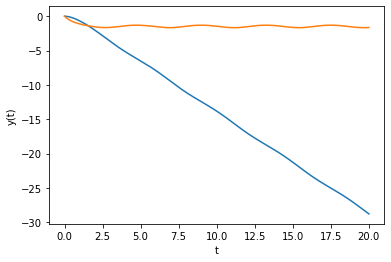

In [49]:
import matplotlib.pyplot as plt
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

t = Variable("t")
td = Variable("td")

x = np.hstack([t, td])
u_new = G@x

#u_new = [39.5*t + 8.5*td]

dv_0 = td
dv_1 = (-p.damping()/(p.mass()*p.length()**2))*td + (p.gravity()/p.length())*pydrake.forwarddiff.sin(t) \
+ (-0.5977 - 0.3015*td + 0.0645*pydrake.forwarddiff.cos(t) - 4.8302*pydrake.forwarddiff.sin(t))/(p.mass()*p.length()**2)

# dv_1 = (-p.damping()/(p.mass()*p.length()**2))*td + (p.gravity()/p.length())*pydrake.forwarddiff.sin(t) - u_new[0]

x_dot = np.array([dv_0, dv_1])

continuous_vector_system = SymbolicVectorSystem(state=x, dynamics=x_dot, output=x)
# Create a simple block diagram containing our system.
builder = DiagramBuilder()
system = builder.AddSystem(continuous_vector_system)
logger = LogVectorOutput(system.get_output_port(0), builder)
diagram = builder.Build()

# Set the initial conditions, x(0).
context = diagram.CreateDefaultContext()
context.SetContinuousState([0, 0])

# Create the simulator, and simulate for 10 seconds.
simulator = Simulator(diagram, context)
simulator.AdvanceTo(20)

# Plot the results.
log = logger.FindLog(context)
plt.figure()
plt.plot(log.sample_times(), log.data().transpose())
plt.xlabel('t')
plt.ylabel('y(t)');

In [112]:
d = log.data()

In [113]:
np.rad2deg(d.view()[0][-1])

102.2687372313661

In [129]:
G

array([[10.74101105,  2.42596626]])

In [125]:
R

[1]

In [126]:
B

array([[0],
       [1]])

In [127]:
X

array([[15.23206699, 10.74101105],
       [10.74101105,  9.70386502]])

In [128]:
B.T@X@E

array([[10.74101105,  2.42596626]])

In [17]:
# finding the bound

from pydrake.solvers.mathematicalprogram import MathematicalProgram, SolverOptions, Solve
from pydrake.solvers.csdp import CsdpSolver
from pydrake.solvers.mosek import MosekSolver

negative_infinity = float('-inf')
coeff = 1e-2

def find_implicit_lambdas(x, xd, V, Vdot, g):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    prog.AddIndeterminates(xd)
    rho = prog.NewContinuousVariables(1, 'rho')[0]
        
    y = np.hstack([x, xd])
    
    l_deg = math.ceil(Vdot.TotalDegree()/2) * 2
    
    lambda_ = prog.NewSosPolynomial(Variables(y), l_deg)[0]
    
    lambda_g = []
    
    for i in range(g.size): 
        gi_deg = max(l_deg + Vdot.TotalDegree() - g[i].TotalDegree(), 0)
        lambda_g.append(prog.NewFreePolynomial(Variables(y), gi_deg))
        
    lambda_g = np.array(lambda_g)    
    
    s_deg = max(l_deg + Vdot.TotalDegree() - 2, 0)
    lambda_s = prog.NewFreePolynomial(Variables(y), s_deg)
    
    trig = Polynomial(x[0]**2 + x[1]**2 - 1)    
    # level set as optimization variable
    prog.AddSosConstraint(Polynomial(x.dot(x))*(V - rho) -lambda_*Vdot + lambda_g.dot(g) + lambda_s*trig)
    
    prog.AddLinearCost(-rho)
        
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
                
    print("Lambda solution status: " + str(k))
    
    assert result.is_success()
    
    lambda_g_results = []
    
    for i in range(g.size):
        lambda_g_results.append(result.GetSolution(lambda_g[i]).RemoveTermsWithSmallCoefficients(coeff))
    
    return result.GetSolution(lambda_).RemoveTermsWithSmallCoefficients(coeff), np.array(lambda_g_results), \
result.GetSolution(lambda_s).RemoveTermsWithSmallCoefficients(coeff), result.GetSolution(rho)


def problem_solver_implicit(S, V_degree, G):
    prog = MathematicalProgram()
    s = prog.NewIndeterminates(1, "s")
    c = prog.NewIndeterminates(1, "c")
    theta_dot = prog.NewIndeterminates(1, "theta_dot")
    
    xd = prog.NewIndeterminates(3, 'xd')
    
    state_V = np.hstack([theta_dot, c, s, [1]])
    
    x = np.hstack([s, c, theta_dot])
    
    u = -G@x
        
    g0 = xd[0] - c[0]*theta_dot[0]
    g1 = xd[1] + s[0]*theta_dot[0]
    g2 = p.mass()*(p.length()**2)*xd[2] + p.damping()*theta_dot[0] - p.mass()*p.gravity()*p.length()*s[0] - u
    
    g = np.array([g0, g1, g2])
    
    V = state_V.T@S@state_V
    Vdot = V.Jacobian(x).dot(xd)
    
    V = Polynomial(V)
    Vdot = Polynomial(Vdot)
    
    g_poly = []
    for i in range(g.size):
        g_poly.append(Polynomial(g[i]))
        
    g_poly = np.array(g_poly)
    
    display(Markdown("$ V(x)="+ToLatex(V.ToExpression(), 9)+"$"))
    for i in range(1):
        lambda_, lambda_g, lambda_s, rho = find_implicit_lambdas(x, xd, V, Vdot, g_poly)
        
#         display(Markdown("$ \lambda(x)="+ToLatex(lambda_s.ToExpression())+"$"))
#         display(Markdown("$ \lambda_g(x)="+ToLatex(lambda_g[0].ToExpression())+"$"))
#         display(Markdown("$ \lambda_g(x)="+ToLatex(lambda_g[1].ToExpression())+"$"))
        
        #V, Q = find_implicit_V(x, xd, lambda_, lambda_g, lambda_s, g_poly, V_degree)
        print(rho)
        
        Vdot = V.Jacobian(x).dot(xd)
     
        display(Markdown("$ V(x)="+ToLatex(V.ToExpression(), 9)+"$"))
        
    return V, Q

V_degree = 2
V, Q = problem_solver_implicit(candidate_matrix_new, V_degree, G_casted)

$ V(x)=(2.842200000 - 2.840000000c_{0} + 0.042000000s_{0} theta_dot_{0} + 0.051600000theta_dot_{0}^{2})$

Lambda solution status: 1
0.0021999878517211164


$ V(x)=(2.842200000 - 2.840000000c_{0} + 0.042000000s_{0} theta_dot_{0} + 0.051600000theta_dot_{0}^{2})$

In [199]:
var_list = list(V.indeterminates())
s = var_list[0]
c = var_list[1]
theta_dot = var_list[2]

In [200]:
# Plot the results as contour plots.
nq = 151
nqd = 151
q = np.linspace(-2 * np.pi, 2 * np.pi, nq)
qd = np.linspace(-50 * p.mass()*p.gravity()*p.length(), 50 * p.mass()*p.gravity()*p.length(), nqd)
Q, QD = np.meshgrid(q, qd)
Energy = .5 * p.mass() * p.length()**2 * QD**2 + p.mass()*p.gravity()*p.length() * (1 - np.cos(Q))
Vplot = Q.copy()
env = {s: 0., c: 1., theta_dot: 0}
for i in range(nq):
    for j in range(nqd):
        env[s] = np.sin(Q[i, j])
        env[c] = np.cos(Q[i, j])
        env[theta_dot] = QD[i, j]
        Vplot[i, j] = V.Evaluate(env)

# plt.rc("text", usetex=True)
fig, ax = plt.subplots()
ax.contour(Q, QD, Vplot)
ax.contour(Q, QD, Vplot, levels = [0.009], colors = 'r')
ax.contour(Q, QD, Energy, alpha=0.5, linestyles="dashed")
ax.set_xlabel("theta")
ax.set_ylabel("thetadot")
ax.set_title("V (solid) and Mechanical Energy (dashed)")

AttributeError: 'pydrake.examples.acrobot.AcrobotParams' object has no attribute 'mass'

In [40]:
G

array([[10.74101105,  2.42596626]])

In [225]:
prog = MathematicalProgram()
s = prog.NewIndeterminates(1, 's')
c = prog.NewIndeterminates(1, 'c')
theta = prog.NewIndeterminates(1, 'theta')

state = np.hstack([s, c, theta])

V, Q = prog.NewSosPolynomial(Variables(state), 2)

display(Markdown("$"+ToLatex(Q)+"$"))

$\begin{bmatrix} S_{0,0} & S_{1,0} & S_{2,0} & S_{3,0} \\ S_{1,0} & S_{1,1} & S_{2,1} & S_{3,1} \\ S_{2,0} & S_{2,1} & S_{2,2} & S_{3,2} \\ S_{3,0} & S_{3,1} & S_{3,2} & S_{3,3} \end{bmatrix}$

In [29]:
display(Markdown("$"+ToLatex(V.ToExpression())+"$"))

AttributeError: 'Add' object has no attribute 'ToExpression'

In [36]:
G_explicit

array([[39.4932081 ,  8.55245308]])

## Acrobot Example

In [28]:
from pydrake.examples.acrobot import (AcrobotGeometry, AcrobotInput,
                                      AcrobotPlant, AcrobotState, AcrobotParams)

In [29]:
p = AcrobotParams()

In [30]:
p.m2

<bound method PyCapsule.m2 of AcrobotParams([1.0, 1.0, 1.0, 2.0, 0.5, 1.0, 0.083, 0.33, 0.1, 0.1, 9.81])>

In [31]:
plant = AcrobotPlant()
context = plant.CreateDefaultContext()
type(plant)

pydrake.examples.acrobot.AcrobotPlant

In [32]:
plant.MassMatrix(context)

array([[4.663, 2.33 ],
       [2.33 , 1.33 ]])

In [197]:
plant.DynamicsBiasTerm(context)


















array([0., 0.])

## Searching for Pendulum Control Input Explicitly

In [7]:
# explicit linearization
A_explicit = np.array([[0, 1], [p.gravity()/p.length(), -p.damping()/(p.mass()*p.length()*p.length())]])
B_explicit = np.array([[0], [1]])

Q_explicit = np.diag([10, 1])
R_explicit = [1]

X_explicit, L_explicit, G_explicit = control.care(A_explicit, B_explicit, Q_explicit, R_explicit)

In [14]:
G_explicit
G_explicit_casted = np.insert(G_explicit, 1, 0)
G_explicit_casted

array([39.4932081 ,  0.        ,  8.55245308])

In [12]:
A_cl_ex = A_explicit - B_explicit@G_explicit
Q_ly_ex = np.eye(2)
P_ex = control.lyap(A_cl_ex.T, Q_ly_ex)

In [13]:
P_ex

array([[1.39102074, 0.0251595 ],
       [0.0251595 , 0.05866096]])

In [51]:
#THIS CODE WORKS
from pydrake.solvers.mathematicalprogram import MathematicalProgram, SolverOptions, Solve
from pydrake.solvers.csdp import CsdpSolver
from pydrake.solvers.mosek import MosekSolver

def findLambda(x, V, Vdot, count, f):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
        
    l_deg = math.ceil(V.TotalDegree()/2) * 2
    
    lambda_, Q_l = prog.NewSosPolynomial(Variables(x), l_deg)
    
    s_deg = max(l_deg + V.TotalDegree() - 2, 0)
    
    lambda_s = prog.NewFreePolynomial(Variables(x), s_deg)
    
    u = prog.NewFreePolynomial(Variables(x), 1)
    f2 = Polynomial((-b/(m*length**2))*x[2] + (grav/length)*x[0]) + u
    f[2] = f2
    
    Vdot = V.Jacobian(x).dot(f)
    
    trig = Polynomial(x[0]**2 + x[1]**2 - 1)
    prog.AddSosConstraint(-Vdot - lambda_*(1 - V) + lambda_s*trig)
    
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
        
    print('Status of first solver on step ' + str(count) + ': ' + str(k))
    assert result.is_success()
    
    return result.GetSolution(lambda_), result.GetSolution(lambda_s), result.GetSolution(u)


def findV(x, lambda_, lambda_s, u, f, count):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)    
    
    V, Q = prog.NewSosPolynomial(Variables(x), 2)
            
    prog.AddLinearConstraint(V.ToExpression().Substitute({x[0]: 0, x[1]:1, x[2]: 0}) == 0)
    
    f2 = Polynomial((-b/(m*length**2))*x[2] + (grav/length)*x[0]) + u
    f[2] = f2
    
    Vdot = V.Jacobian(x).dot(f)
    
    trig = Polynomial(x[0]**2 + x[1]**2 - 1)
    prog.AddSosConstraint(-Vdot - lambda_*(1 - V) + lambda_s*trig)
    
    prog.AddLinearCost(np.trace(Q))
    
#     A = Q[0, 0]
#     B = 2*Q[1, 0]
#     C = Q[1, 1]
    
#     prog.AddCost(A)
#     prog.AddCost(C)
#     prog.AddCost(-B)
    
    solver = MosekSolver()
    result = solver.Solve(prog)
        
    k = result.get_solver_details().solution_status
                
    print('Status of second solver on step ' + str(count) + ': ' + str(k))
    assert result.is_success()
    
    return result.GetSolution(V), result.GetSolution(Q)

def setup_solver(P, G):  
    count = 0
    prog = MathematicalProgram()
    s = prog.NewIndeterminates(1, "s")
    c = prog.NewIndeterminates(1, "c")
    theta_dot = prog.NewIndeterminates(1, "\dot{O}")
    
    x = np.hstack([s, c, theta_dot])
    
    f0 = Polynomial(x[1] * x[2])
    f1 = Polynomial(-x[0] * x[2])
    f2 = Polynomial((-b/(m*length**2))*x[2] + (grav/length)*x[0] - G@x)
    
    f = np.array([f0, f1, f2])
    
    V = 2.78 - 2.78*c[0] + 0.0586*theta_dot[0]**2 + 0.053*s[0]*theta_dot[0]
    
    V = Polynomial(V)
    
    display(Markdown("$V(x) = " + ToLatex(V.RemoveTermsWithSmallCoefficients(1e-5).ToExpression(),6) + "$"))
        
    Vdot = V.Jacobian(x).dot(f)
    
    for i in range(1): 
        lambda_, lambda_s, u = findLambda(x, V, Vdot, count, f)
        
#         display(Markdown("$\lambda (x) = " + ToLatex(
#         Polynomial(lambda_).RemoveTermsWithSmallCoefficients(1e-5).ToExpression(),6) + "$"))
        
        V, Q = findV(x, lambda_, lambda_s, u, f, count)
        
        display(Markdown("$V(x) = " + ToLatex(V.RemoveTermsWithSmallCoefficients(1e-5).ToExpression(),6) + "$"))
        display(Markdown("$u(x) = " + ToLatex(u.RemoveTermsWithSmallCoefficients(1e-5).ToExpression(),6) + "$"))
        
        Vdot = V.Jacobian(x).dot(f)
        
        count += 1
    return V, Q
    
    
V, Q = setup_solver(P_ex, G_explicit_casted)

$V(x) = (2.780000 - 2.780000c_{0} + 0.053000s_{0} \dot{O}_{0} + 0.058600\dot{O}_{0}^{2})$

Status of first solver on step 0: 1
Status of second solver on step 0: 7


AssertionError: 

## Pendulum Balance Up - Implicit Certification and Controller Search

In [13]:
# the necessary imports
from pydrake.solvers.mosek import MosekSolver

import scipy
import control
import sympy as sp
from sympy.physics.vector import dynamicsymbols as dynamicsymbols

from pydrake.all import (LinearQuadraticRegulator, MathematicalProgram, Variables,
                         Solve, RealContinuousLyapunovEquation, SolverOptions, Solve, Linearize)

import matplotlib.pyplot as plt
import mpld3
import numpy as np
from IPython.display import Markdown, display
from pydrake.all import (Jacobian, Polynomial,
                         RegionOfAttraction, RegionOfAttractionOptions,
                         SymbolicVectorSystem, ToLatex, Variable,
                         plot_sublevelset_expression)

from pydrake.examples.pendulum import PendulumParams
from pydrake.examples.van_der_pol import VanDerPolOscillator
from pydrake.symbolic import Polynomial, Monomial

from underactuated import plot_2d_phase_portrait, running_as_notebook

from pydrake.all import (AddMultibodyPlantSceneGraph, ControllabilityMatrix,
                         DiagramBuilder, Linearize, LinearQuadraticRegulator,
                         MeshcatVisualizerCpp, Parser, Saturation, SceneGraph,
                         Simulator, StartMeshcat, WrapToSystem, MakeVectorVariable)

if running_as_notebook:
    mpld3.enable_notebook()

import math

from pydrake.examples.pendulum import PendulumParams, PendulumPlant
import numpy as np

import matplotlib.pyplot as plt
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

import pydrake.forwarddiff

from pydrake.all import (AddMultibodyPlantSceneGraph, ControllabilityMatrix,
                         DiagramBuilder, Linearize, LinearQuadraticRegulator,
                         MeshcatVisualizerCpp, Parser, Saturation, SceneGraph,
                         Simulator, StartMeshcat, WrapToSystem)

from pydrake.examples.pendulum import (PendulumGeometry, PendulumInput,
                                      PendulumPlant, PendulumState)

from underactuated import FindResource, running_as_notebook
from underactuated.meshcat_cpp_utils import MeshcatSliders

if running_as_notebook:
    mpld3.enable_notebook()


A pendulum's equations are given as 
$ml^2\ddot{\theta} + b\dot{\theta} + mgl\sin{\theta} = u$

We will linearize around $x_0$ = $\pi$, 0 and $u_0$ = 0

In [14]:
# implicitly write the dynamics
p = PendulumParams()

#pendulum constants
mass = p.mass()
length = p.length()
gravity = p.gravity()
b = p.damping()

#implicitly linearized dynamics
E = np.array([[1, 0], [0, mass*length**2]])
A = np.array([[0, 1], [mass*gravity*length, -b]])
B = np.array([[0], [1]])

#costs
Q = np.diag([10, 1])
R = [1]

#generalized riccati equation
X, L, K = control.care(A, B, Q, R, E=E)

In [15]:
K_casted = np.insert(K, 1, 0)
K_casted

array([10.74101105,  0.        ,  2.42596626])

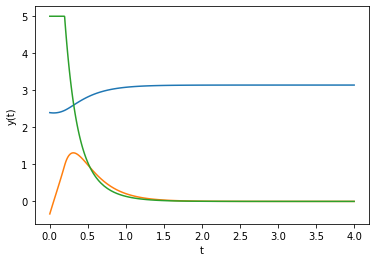

In [16]:
#before moving further, confirm that implicitly found dynamics work in simulation
def UprightState():
    return np.array([np.pi, 0])

t = Variable("t")
td = Variable("td")
garbage = Variable("garbage")

x = np.hstack([t, td])
u = -K@(x  - UprightState())

own_controller = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u)

# dv_0 = td
# dv_1 = (-b*td - mass*gravity*length*pydrake.forwarddiff.sin(t) + u)/(mass*length**2)

# x_dot = np.array([dv_0, dv_1])

# continuous_vector_system = SymbolicVectorSystem(state=x, dynamics=x_dot, output=x)

def acrobot_balancing_example():

    builder = DiagramBuilder()
    pendulum = builder.AddSystem(PendulumPlant())
    
    saturation = builder.AddSystem(Saturation(min_value=[-5], max_value=[5]))
    builder.Connect(saturation.get_output_port(0), pendulum.get_input_port(0))
    wrapangles = WrapToSystem(2)
    wrapangles.set_interval(0, 0, 2. * np.pi)
    wrapto = builder.AddSystem(wrapangles)
    builder.Connect(pendulum.get_output_port(0), wrapto.get_input_port(0))
    controller = builder.AddSystem(own_controller)
    builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))
    
    logger = LogVectorOutput(wrapto.get_output_port(0), builder)
    logger2 = LogVectorOutput(saturation.get_output_port(0), builder)
    
    diagram = builder.Build()
    
    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # Simulate
    simulator.set_target_realtime_rate(0.0)
    duration = 4 if running_as_notebook else 0.1
    for i in range(1):
        context.SetTime(0.)
        np.random.seed(2021)
        context.SetContinuousState(np.append(UprightState(), 0) -
                                 0.5* np.random.randn(3,))
        simulator.Initialize()
        simulator.AdvanceTo(duration)
        
        log = logger.FindLog(context)
        plt.figure()
        plt.plot(log.sample_times(), log.data().transpose())\
        
        log2 = logger2.FindLog(context)
        plt.plot(log2.sample_times(), log2.data().transpose())
        plt.xlabel('t')
        plt.ylabel('y(t)');
    

acrobot_balancing_example()

In [17]:
# now let's close the loop to solve the generalized Lyapunov equation
# note that we are working in x_bar = x - x_0 now because we need 0, 0 for Lyapunov

A_cloop = A - B@K
Q_lyap = np.eye(2)
print(A_cloop)
P = control.lyap(A_cloop.T, Q_lyap, E = E.T)
print(P)
print(np.linalg.eigvals(P)) #make sure this is positive definite

candidate_matrix = E.T@P@E

print(np.linalg.eigvals(candidate_matrix)) #make sure this is also positive definite

print(candidate_matrix)

[[ 0.          1.        ]
 [-5.83601105 -2.52596626]]
[[1.42110175 0.08567496]
 [0.08567496 0.82569391]]
[1.43318457 0.81361109]
[1.42143665 0.05127097]
[[1.42110175 0.02141874]
 [0.02141874 0.05160587]]


In [18]:
# candidate_matrix = np.hstack([candidate_matrix, np.zeros([2, 1])])
# candidate_matrix = np.vstack([candidate_matrix, np.zeros(3)])
candidate_matrix

array([[1.42110175, 0.02141874],
       [0.02141874, 0.05160587]])

In [19]:
#now we will manually transfer V from coordinates of theta, theta_dot to s, c, theta_dot
#replace all theta with s and all theta**2 with 2 - 2*cos(theta)

# as of now we use manual work

In [20]:
# finding the bound
negative_infinity = float('-inf')
coeff = 1e-2

def find_implicit_lambdas(x, xd, V, Vdot, g, x_0, u):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    prog.AddIndeterminates(xd)
    rho = prog.NewContinuousVariables(1, 'rho')[0]
    
    y = np.hstack([x, xd])
    
    l_deg = math.ceil(Vdot.TotalDegree()/2) * 2
    
    lambda_ = prog.NewSosPolynomial(Variables(y), l_deg)[0]
    lambda_g = []
    
    for i in range(g.size): 
        gi_deg = max(l_deg + Vdot.TotalDegree() - g[i].TotalDegree(), 0)
        lambda_g.append(prog.NewFreePolynomial(Variables(y), gi_deg))
        
    lambda_g = np.array(lambda_g)    
    
    s_deg = max(l_deg + Vdot.TotalDegree() - 2, 0)
    lambda_s = prog.NewFreePolynomial(Variables(y), s_deg)
    
    lambda_u_min = prog.NewSosPolynomial(Variables(y), 2)[0]
    lambda_u_max = prog.NewSosPolynomial(Variables(y), 2)[0]
    
    trig = Polynomial(x[0]**2 + x[1]**2 - 1)    
    # level set as optimization variable
    prog.AddSosConstraint(Polynomial((x-x_0).dot(x-x_0))*(V - rho) -lambda_*Vdot \
                          + lambda_g.dot(g) + lambda_s*trig + lambda_u_min*(-0.001 - u) \
                          + lambda_u_max * (u-0.001))
    print(g)
    prog.AddLinearCost(-rho)
        
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
                
    print("Lambda solution status: " + str(k))
    
    assert result.is_success()
    
    lambda_g_results = []
    
    for i in range(g.size):
        lambda_g_results.append(result.GetSolution(lambda_g[i]).RemoveTermsWithSmallCoefficients(coeff))
    
    return result.GetSolution(lambda_).RemoveTermsWithSmallCoefficients(coeff), np.array(lambda_g_results), \
result.GetSolution(lambda_s).RemoveTermsWithSmallCoefficients(coeff), result.GetSolution(rho)


def problem_solver_implicit(S, V_degree, G):
    prog = MathematicalProgram()
    s = prog.NewIndeterminates(1, "s")
    c = prog.NewIndeterminates(1, "c")
    theta_dot = prog.NewIndeterminates(1, "theta_dot")
    
    xd = prog.NewIndeterminates(3, 'xd')
    
    state_V = np.hstack([theta_dot, c, s, [1]])
    
    x = np.hstack([s, c, theta_dot])
    
    x_0 = np.array([0, 1, 0])
    
    
    u = -G@(x - x_0)
        
    g0 = xd[0] - c[0]*theta_dot[0]
    g1 = xd[1] + s[0]*theta_dot[0]
    g2 = p.mass()*(p.length()**2)*xd[2] + p.damping()*theta_dot[0] - p.mass()*p.gravity()*p.length()*s[0] - u
    
    g = np.array([g0, g1, g2])
    
    #V = state_V.T@S@state_V
    V = 1.4211*(2 - 2*x[1]) + 0.0516*x[2]**2 + 0.0428*x[0]*x[2]
    
    Vdot = V.Jacobian(x).dot(xd)
    
    V = Polynomial(V)
    Vdot = Polynomial(Vdot)
    
    g_poly = []
    for i in range(g.size):
        g_poly.append(Polynomial(g[i]))
        
    g_poly = np.array(g_poly)
    
    display(Markdown("$ V(x)="+ToLatex(V.ToExpression(), 9)+"$"))
    for i in range(1):
        lambda_, lambda_g, lambda_s, rho = find_implicit_lambdas(x, xd, V, Vdot, g_poly, x_0, Polynomial(u))
        
        print(rho)
        
        Vdot = V.Jacobian(x).dot(xd)
     
        display(Markdown("$ V(x)="+ToLatex(V.ToExpression(), 9)+"$"))
        
    return V, Q

V_degree = 2
V, Q = problem_solver_implicit(candidate_matrix, V_degree, K_casted)

$ V(x)=(2.842200000 - 2.842200000c_{0} + 0.042800000s_{0} theta_dot_{0} + 0.051600000theta_dot_{0}^{2})$

[<Polynomial "1*xd(0) + -1*c(0) * theta_dot(0)">
 <Polynomial "1*xd(1) + 1*s(0) * theta_dot(0)">
 <Polynomial "0.25*xd(2) + 2.5259662559187128*theta_dot(0) + 5.8360110520799973*s(0)">]
Lambda solution status: 1
5.6843998436759975


$ V(x)=(2.842200000 - 2.842200000c_{0} + 0.042800000s_{0} theta_dot_{0} + 0.051600000theta_dot_{0}^{2})$

In [21]:
#LQR controller certification with torque limits

negative_infinity = float('-inf')
coeff = 1e-2
positive_infinity = float('inf')

def line_search_rho(x, xd, g, V, Vdot, x_0, u, u_min, u_max):     
    rho = 0
    rho_step = 0.1
    
    Vdot_degree = Vdot.TotalDegree()
    V_degree = V.TotalDegree()
    u_deg = u.TotalDegree()
    
    l_deg = math.ceil(V_degree/2) * 2
    
    s_deg = max(l_deg + V_degree - 2, 0)
    
    ul_deg = math.ceil(max(l_deg + V_degree - u_deg, 0)/2)*2
    
    while True: 
        prog = MathematicalProgram()
        prog.AddIndeterminates(x)
        prog.AddIndeterminates(xd)
    
        y = np.hstack([x, xd])
        
        lambda_ = prog.NewSosPolynomial(Variables(y), l_deg)[0]
        
        lambda_g = []
        for i in range(g.size): 
            gi_deg = max(l_deg + Vdot.TotalDegree() - g[i].TotalDegree(), 0)
            lambda_g.append(prog.NewFreePolynomial(Variables(y), gi_deg))
        lambda_g = np.array(lambda_g)
        
        lambda_s = prog.NewFreePolynomial(Variables(y), s_deg)
        trig = Polynomial(x[0]**2 + x[1]**2 - 1)
        
        lambda_u_min = prog.NewSosPolynomial(Variables(y), ul_deg)[0]
        lambda_u_max = prog.NewSosPolynomial(Variables(y), ul_deg)[0]
        
        eps = 1e-3
        
        prog.AddSosConstraint(-Vdot + lambda_*(V - rho) + lambda_g.dot(g) \
                              + lambda_s*trig \
                              + lambda_u_min*(u_min - u) \
                              + lambda_u_max*(u - u_max) \
                              - Polynomial(eps*(x-x_0).dot(x-x_0)))
        
        lambda_chill = prog.NewFreePolynomial(Variables(x), 2)
        prog.AddSosConstraint(V + lambda_chill*trig)
        
        solver = MosekSolver()
        result = solver.Solve(prog)
                
        if result.is_success():
            rho += rho_step
        else:
            break
    
    return rho - rho_step

def find_rho_min_max(x, xd, g_input, V, Vdot, x_0, u_ideal, u, doing_min):
    g = []
    g.append(g_input[0])
    g.append(g_input[1])
    g.append(g_input[2] + u - u_ideal)
    
    g = np.array(g)
        
    rho = 0
    rho_step = 0.1
    
    Vdot_degree = Vdot.TotalDegree()
    V_degree = V.TotalDegree()
    u_deg = u.TotalDegree()
    
    l_deg = math.ceil(V_degree/2) * 2
    
    s_deg = max(l_deg + V_degree - 2, 0)
    
    ul_deg = math.ceil(max(l_deg + V_degree - u_deg, 0)/2)*2
    
    while True: 
        prog = MathematicalProgram()
        prog.AddIndeterminates(x)
        prog.AddIndeterminates(xd)
    
        y = np.hstack([x, xd])
        
        lambda_ = prog.NewSosPolynomial(Variables(y), l_deg)[0]
        
        lambda_g = []
        for i in range(g.size): 
            gi_deg = max(l_deg + Vdot.TotalDegree() - g[i].TotalDegree(), 0)
            lambda_g.append(prog.NewFreePolynomial(Variables(y), gi_deg))
        lambda_g = np.array(lambda_g)
        
        lambda_s = prog.NewFreePolynomial(Variables(y), s_deg)
        trig = Polynomial(x[0]**2 + x[1]**2 - 1)
        
        lambda_u_id = prog.NewSosPolynomial(Variables(y), ul_deg)[0]
        
        eps = 1e-3
        
        if doing_min:
            prog.AddSosConstraint(-Vdot + lambda_*(V - rho) + lambda_g.dot(g) \
                                  + lambda_s*trig \
                                  + lambda_u_id*(u - u_ideal)
                                  - Polynomial(eps*(x-x_0).dot(x-x_0)))
        else:
            prog.AddSosConstraint(-Vdot + lambda_*(V - rho) + lambda_g.dot(g) \
                                  + lambda_s*trig \
                                  + lambda_u_id*(u_ideal - u)
                                  - Polynomial(eps*(x-x_0).dot(x-x_0)))
        
        lambda_chill = prog.NewFreePolynomial(Variables(x), 2)
        prog.AddSosConstraint(V + lambda_chill*trig)
        
        solver = MosekSolver()
        result = solver.Solve(prog)
                
        if result.is_success():
            rho += rho_step
        else:
            break
    
    return rho - rho_step

def certifier_implicit(G, u_min, u_max):
    prog = MathematicalProgram()
    s = prog.NewIndeterminates(1, "s")
    c = prog.NewIndeterminates(1, "c")
    theta_dot = prog.NewIndeterminates(1, "theta_dot")
    x = np.hstack([s, c, theta_dot])
    
    x_0 = np.array([0, 1, 0])
    
    xd = prog.NewIndeterminates(3, 'xd')
      
    u = -G@(x - x_0)
            
    g0 = xd[0] - c[0]*theta_dot[0]
    g1 = xd[1] + s[0]*theta_dot[0]
    g2 = p.mass()*(p.length()**2)*xd[2] + p.damping()*theta_dot[0] - p.mass()*p.gravity()*p.length()*s[0] - u
    
    g = np.array([g0, g1, g2])
    
    V = 1.4211*(2 - 2*x[1]) + 0.0516*x[2]**2 + 0.0428*x[0]*x[2]
    
    Vdot = V.Jacobian(x).dot(xd)
    
    V = Polynomial(V)
    Vdot = Polynomial(Vdot)
    display(Markdown("$ V(x)="+ToLatex(V.ToExpression(), 9)+"$"))
    
    g_poly = []
    for i in range(g.size):
        g_poly.append(Polynomial(g[i]))
        
    g_poly = np.array(g_poly)
        
    u = Polynomial(u)
    
    rho = line_search_rho(x, xd, g_poly, V, Vdot, x_0, u, u_min, u_max)
    rho_min = find_rho_min_max(x, xd, g_poly, V, Vdot, x_0, u_min, u, True)
    rho_max = find_rho_min_max(x, xd, g_poly, V, Vdot, x_0, u_max, u, False)
    
    print('max: ' + str(rho_max))
    print('min: ' + str(rho_min))
    print('regular: ' + str(rho))
    
    return min(rho_max, min(rho, rho_min))

u_min = -5
u_max = 5
rho = certifier_implicit(K_casted, u_min, u_max)
print(rho)

$ V(x)=(2.842200000 - 2.842200000c_{0} + 0.042800000s_{0} theta_dot_{0} + 0.051600000theta_dot_{0}^{2})$

max: 0.4
min: 0.4
regular: 5.599999999999996
0.4


In [22]:
V

<Polynomial "2.8422000000000001*1 + 0.0516*theta_dot(0)^2 + -2.8422000000000001*c(0) + 0.042799999999999998*s(0) * theta_dot(0)">

In [23]:
#before moving further, confirm that implicitly found dynamics work in simulation
def UprightState():
    return np.array([np.pi, 0])

t = Variable("t")
td = Variable("td")

x = np.hstack([t, td])

u = -K@(x  - UprightState())
u = u[0]

dv_0 = td
dv_1 = (-b*td - mass*gravity*length*pydrake.forwarddiff.sin(t) + u)/(mass*length**2)

x_dot = np.array([dv_0, dv_1])

continuous_vector_system = SymbolicVectorSystem(state=x, dynamics=x_dot, output=x)

def pend_balancing_example():

    builder = DiagramBuilder()
    pendulum = builder.AddSystem(continuous_vector_system)

    wrapangles = WrapToSystem(2)
    wrapangles.set_interval(0, 0, 2. * np.pi)
    wrapto = builder.AddSystem(wrapangles)
    builder.Connect(pendulum.get_output_port(0), wrapto.get_input_port(0))
    
    logger = LogVectorOutput(wrapto.get_output_port(0), builder)
    
    diagram = builder.Build()
    
    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # Simulate
    simulator.set_target_realtime_rate(0.0)
    duration = 4.0 if running_as_notebook else 0.1
    points = []
    plotting = False
    for i in range(1):
        context.SetTime(0.)
        trial = UprightState() + 1 * np.random.randn(2,)
        context.SetContinuousState(trial)
        simulator.Initialize()
        simulator.AdvanceTo(duration)
        
        log = logger.FindLog(context)
        
        if plotting: 
            plt.figure()
            plt.plot(log.sample_times(), log.data().transpose())
            plt.xlabel('t')
            plt.ylabel('y(t)')
        
        last = log.data().view()[0]
        last = last[-1]
        
        if last - np.pi < 1e-3:
            points.append(trial)
            
    return points

succ = pend_balancing_example()


succ2 = np.array(succ)

Text(0.5, 1.0, 'V (solid) and Mechanical Energy (dashed)')

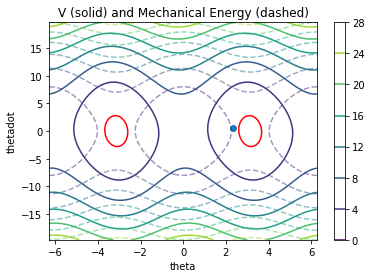

In [24]:
var_list = list(V.indeterminates())
s = var_list[0]
c = var_list[1]
theta_dot = var_list[2]

# Plot the results as contour plots.
nq = 151
nqd = 151
q = np.linspace(-2 * np.pi, 2 * np.pi, nq)
qd = np.linspace(-4 * p.mass()*p.gravity()*p.length(), 4 * p.mass()*p.gravity()*p.length(), nqd)
Q, QD = np.meshgrid(q, qd)
Energy = .5 * p.mass() * p.length()**2 * QD**2 + p.mass()*p.gravity()*p.length() * (1 - np.cos(Q))
Vplot = Q.copy()
env = {s: 0., c: 1., theta_dot: 0}
for i in range(nq):
    for j in range(nqd):
        env[s] = -np.sin(np.pi - Q[i, j])
        env[c] = np.cos(np.pi - Q[i, j])
        env[theta_dot] = QD[i, j]
        Vplot[i, j] = V.Evaluate(env)

# plt.rc("text", usetex=True)
fig, ax = plt.subplots()
cf = ax.contour(Q, QD, Vplot)
fig.colorbar(cf, ax=ax)
ax.contour(Q, QD, Vplot, levels = [0.4], colors = 'r')
ax.contour(Q, QD, Energy, alpha=0.5, linestyles="dashed")
ax.scatter(succ2[:, 0], succ2[:, 1])
ax.set_xlabel("theta")
ax.set_ylabel("thetadot")
ax.set_title("V (solid) and Mechanical Energy (dashed)")

In [25]:
# finding the control input itself using alternations

from pydrake.solvers.mathematicalprogram import MathematicalProgram, SolverOptions, Solve
from pydrake.solvers.csdp import CsdpSolver
from pydrake.solvers.mosek import MosekSolver

negative_infinity = float('-inf')
coeff = 1e-4

def find_implicit_lambdas(x, xd, V, Vdot, g, x_0):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    prog.AddIndeterminates(xd)
            
    y = np.hstack([x, xd])
    
    l_deg = math.ceil(V.TotalDegree()/2) * 2
    
    lambda_ = prog.NewSosPolynomial(Variables(y), l_deg)[0]
        
    lambda_g = []
    
    for i in range(g.size): 
        gi_deg = max(l_deg + V.TotalDegree() - g[i].TotalDegree(), 0)
        lambda_g.append(prog.NewFreePolynomial(Variables(y), gi_deg))
        
    lambda_g = np.array(lambda_g)    
    
    s_deg = max(l_deg + V.TotalDegree() - 2, 0)
    lambda_s = prog.NewFreePolynomial(Variables(y), s_deg)
    
    trig = Polynomial(x[0]**2 + x[1]**2 - 1)
    
    eps = 1e-3
    prog.AddSosConstraint(Polynomial((x-x_0).dot(x-x_0))*(V - 1) -lambda_*Vdot \
                          + lambda_g.dot(g) + lambda_s*trig)
        
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
                
    print("Lambda solution status: " + str(k))
    
    assert result.is_success()
    
    lambda_g_results = []
    
    for i in range(g.size):
        lambda_g_results.append(result.GetSolution(lambda_g[i]).RemoveTermsWithSmallCoefficients(coeff))
    
    return result.GetSolution(lambda_).RemoveTermsWithSmallCoefficients(coeff), np.array(lambda_g_results), \
result.GetSolution(lambda_s).RemoveTermsWithSmallCoefficients(coeff)

def find_implicit_V(x, xd, lambda_, lambda_g, lambda_s, g, V_degree, x_0):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    prog.AddIndeterminates(xd)
            
    V = prog.NewFreePolynomial(Variables(x), V_degree)
    Vdot = V.Jacobian(x).dot(xd)
    # the u business
    u = prog.NewFreePolynomial(Variables(x), 2)
        
    g2 = Polynomial(p.mass()*(p.length()**2)*xd[2] + p.damping()*x[2] \
                    - p.mass()*p.gravity()*p.length()*x[0]) - u
    g[2] = g2
    
    trig = Polynomial(x[0]**2 + x[1]**2 - 1)
    
    eps = 1e-3
    prog.AddSosConstraint(Polynomial((x-x_0).dot(x-x_0))*(V - 1) -lambda_*Vdot \
                          + lambda_g.dot(g) + lambda_s*trig)
    
    mgl = p.mass()*p.length()*p.gravity()
    
    lambda_s2 = prog.NewFreePolynomial(Variables(x), 2)
    prog.AddSosConstraint(V + lambda_s2*trig)
    
    V_decision_variables_dict = V.monomial_to_coefficient_map()
    
    const_term = Monomial()
    cos_term = Monomial(x[1])
    td_sq = Monomial(x[2], 2)
    sin_sq_term = Monomial(x[0], 2)
    cos_sq_term = Monomial(x[1], 2)
    
    prog.AddLinearCost(V_decision_variables_dict[const_term])
    prog.AddLinearCost(-V_decision_variables_dict[cos_term])
    prog.AddLinearCost(V_decision_variables_dict[td_sq])
    prog.AddLinearCost(V_decision_variables_dict[sin_sq_term])
    prog.AddLinearCost(-V_decision_variables_dict[cos_sq_term])
    
    #prog.AddLinearCost(np.trace(Q))    
    prog.AddLinearConstraint(V.ToExpression().Substitute({x[0]: 0, x[1]:1, x[2]:0}) == 0)
    
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
                
    print("V solution status: " + str(k))
    
    assert result.is_success()
    
    print(result.GetSolution(u))
    return result.GetSolution(V), \
result.GetSolution(Q), result.GetSolution(u)


def problem_solver_implicit(S, V_degree, G):
    prog = MathematicalProgram()
    s = prog.NewIndeterminates(1, "s")
    c = prog.NewIndeterminates(1, "c")
    theta_dot = prog.NewIndeterminates(1, "theta_dot")
    
    xd = prog.NewIndeterminates(3, 'xd')
    
    state_V = np.hstack([theta_dot, c, s, [1]])
    
    x = np.hstack([s, c, theta_dot])
    
    x_0 = np.array([0, 1, 0])
    
    u = -G@(x - x_0)
        
    g0 = xd[0] - c[0]*theta_dot[0]
    g1 = xd[1] + s[0]*theta_dot[0]
    g2 = p.mass()*(p.length()**2)*xd[2] + p.damping()*theta_dot[0] - p.mass()*p.gravity()*p.length()*s[0] - u
    
    g = np.array([g0, g1, g2])
    
    #V = state_V.T@S@state_V
    V = 1.4211*(2 - 2*x[1]) + 0.0516*x[2]**2 + 0.0428*x[0]*x[2]
    
    Vdot = V.Jacobian(x).dot(xd)
    
    V = Polynomial(V)
    Vdot = Polynomial(Vdot)
    
    g_poly = []
    for i in range(g.size):
        g_poly.append(Polynomial(g[i]))
        
    g_poly = np.array(g_poly)
    
    display(Markdown("$ V(x)="+ToLatex(V.ToExpression(), 9)+"$"))
    for i in range(10):
        lambda_, lambda_g, lambda_s = find_implicit_lambdas(x, xd, V, Vdot, g_poly, x_0)
        
        
        V, Q, u = find_implicit_V(x, xd, lambda_, lambda_g, lambda_s, g_poly, V_degree, x_0)
        
        g2 = Polynomial(p.mass()*(p.length()**2)*xd[2] + p.damping()*x[2] \
                    - p.mass()*p.gravity()*p.length()*x[0]) - u
        g_poly[2] = g2
        
        Vdot = V.Jacobian(x).dot(xd)
        Vdot = Polynomial(Vdot.ToExpression())
     
        display(Markdown("$ V(x)="+ToLatex(V.ToExpression(), 9)+"$"))
        
        display(Markdown("$ u(x)="+ToLatex(u.ToExpression(), 9)+"$"))
        
    return V, Q, u, x

V_degree = 2
V, Q, u, x = problem_solver_implicit(candidate_matrix, V_degree, K_casted)

$ V(x)=(2.842200000 - 2.842200000c_{0} + 0.042800000s_{0} theta_dot_{0} + 0.051600000theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 1
1.089228387952852e-18*1 + -2.4237167315784589*theta_dot(0) + 0*theta_dot(0)^2 + -1.1212150624496619e-18*c(0) + 0*c(0) * theta_dot(0) + 0*c(0)^2 + -9.5250608087514852*s(0) + 0*s(0) * theta_dot(0) + 0*s(0) * c(0) + 0*s(0)^2


$ V(x)=(2.172848919 + 0.000000000s_{0} - 1.503585588c_{0} - 0.000000000theta_dot_{0} - 0.000000000s_{0} c_{0} + 0.133349463s_{0} theta_dot_{0} + 0.000000000c_{0} theta_dot_{0} - 0.397108787s_{0}^{2} - 0.669263331c_{0}^{2} + 0.048059902theta_dot_{0}^{2})$

$ u(x)=(0.000000000 - 9.525060809s_{0} - 0.000000000c_{0} - 2.423716732theta_dot_{0})$

Lambda solution status: 1
V solution status: 1
-8.9844390761412744e-18*1 + -2.4281821103594172*theta_dot(0) + 0*theta_dot(0)^2 + 7.8977375942586832e-18*c(0) + 0*c(0) * theta_dot(0) + 0*c(0)^2 + -8.2339149943922472*s(0) + 0*s(0) * theta_dot(0) + 0*s(0) * c(0) + 0*s(0)^2


$ V(x)=(1.912640581 - 0.000000000s_{0} - 0.983303832c_{0} - 0.000000000theta_dot_{0} - 0.000000000s_{0} c_{0} + 0.108417929s_{0} theta_dot_{0} + 0.000000000c_{0} theta_dot_{0} - 0.698510775s_{0}^{2} - 0.929336748c_{0}^{2} + 0.025082456theta_dot_{0}^{2})$

$ u(x)=(-0.000000000 - 8.233914994s_{0} + 0.000000000c_{0} - 2.428182110theta_dot_{0})$

Lambda solution status: 1
V solution status: 1
1.095914488617071e-17*1 + -2.4325868506461323*theta_dot(0) + 0*theta_dot(0)^2 + -1.0827492102594693e-17*c(0) + 0*c(0) * theta_dot(0) + 0*c(0)^2 + -8.0692855313641392*s(0) + 0*s(0) * theta_dot(0) + 0*s(0) * c(0) + 0*s(0)^2


$ V(x)=(1.821338363 + 0.000000000s_{0} - 0.800832120c_{0} - 0.000000000theta_dot_{0} - 0.000000000s_{0} c_{0} + 0.074340182s_{0} theta_dot_{0} + 0.000000000c_{0} theta_dot_{0} - 0.932654235s_{0}^{2} - 1.020506243c_{0}^{2} + 0.018560173theta_dot_{0}^{2})$

$ u(x)=(0.000000000 - 8.069285531s_{0} - 0.000000000c_{0} - 2.432586851theta_dot_{0})$

Lambda solution status: 1
V solution status: 1
-1.925034615001017e-18*1 + -2.4362273680999853*theta_dot(0) + 0*theta_dot(0)^2 + 2.189764576772728e-18*c(0) + 0*c(0) * theta_dot(0) + 0*c(0)^2 + -8.2146349601131767*s(0) + 0*s(0) * theta_dot(0) + 0*s(0) * c(0) + 0*s(0)^2


$ V(x)=(1.746474503 - 0.000000000s_{0} - 0.651186084c_{0} + 0.000000000theta_dot_{0} + 0.000000000s_{0} c_{0} + 0.060353287s_{0} theta_dot_{0} - 0.000000000c_{0} theta_dot_{0} - 1.096469071s_{0}^{2} - 1.095288418c_{0}^{2} + 0.019469872theta_dot_{0}^{2})$

$ u(x)=(-0.000000000 - 8.214634960s_{0} + 0.000000000c_{0} - 2.436227368theta_dot_{0})$

Lambda solution status: 1
V solution status: 1
5.4371081093612039e-19*1 + -2.4389916199186077*theta_dot(0) + 0*theta_dot(0)^2 + -5.6956185987809734e-19*c(0) + 0*c(0) * theta_dot(0) + 0*c(0)^2 + -8.1931667964163424*s(0) + 0*s(0) * theta_dot(0) + 0*s(0) * c(0) + 0*s(0)^2


$ V(x)=(1.696592908 + 0.000000000s_{0} - 0.551494178c_{0} - 0.000000000theta_dot_{0} - 0.000000000s_{0} c_{0} + 0.037524495s_{0} theta_dot_{0} + 0.000000000c_{0} theta_dot_{0} - 1.218878314s_{0}^{2} - 1.145098730c_{0}^{2} + 0.015755011theta_dot_{0}^{2})$

$ u(x)=(0.000000000 - 8.193166796s_{0} - 0.000000000c_{0} - 2.438991620theta_dot_{0})$

Lambda solution status: 1
V solution status: 1
8.0580201676198257e-20*1 + -2.4405899741674224*theta_dot(0) + 0*theta_dot(0)^2 + -8.1477299185692897e-20*c(0) + 0*c(0) * theta_dot(0) + 0*c(0)^2 + -8.1347900925073038*s(0) + 0*s(0) * theta_dot(0) + 0*s(0) * c(0) + 0*s(0)^2


$ V(x)=(1.676168120 + 0.000000000s_{0} - 0.510700803c_{0} - 0.000000000theta_dot_{0} - 0.000000000s_{0} c_{0} + 0.023177773s_{0} theta_dot_{0} + 0.000000000c_{0} theta_dot_{0} - 1.290808649s_{0}^{2} - 1.165467317c_{0}^{2} + 0.011131277theta_dot_{0}^{2})$

$ u(x)=(0.000000000 - 8.134790093s_{0} - 0.000000000c_{0} - 2.440589974theta_dot_{0})$

Lambda solution status: 1
V solution status: 1
1.7041576196745838e-19*1 + -2.441820776571932*theta_dot(0) + 0*theta_dot(0)^2 + -9.4592658621784842e-20*c(0) + 0*c(0) * theta_dot(0) + 0*c(0)^2 + -8.1307070596077082*s(0) + 0*s(0) * theta_dot(0) + 0*s(0) * c(0) + 0*s(0)^2


$ V(x)=(1.671272859 - 0.000000000s_{0} - 0.500934089c_{0} + 0.000000000theta_dot_{0} + 0.000000000s_{0} c_{0} + 0.020456058s_{0} theta_dot_{0} - 0.000000000c_{0} theta_dot_{0} - 1.323762842s_{0}^{2} - 1.170338770c_{0}^{2} + 0.010372032theta_dot_{0}^{2})$

$ u(x)=(0.000000000 - 8.130707060s_{0} - 0.000000000c_{0} - 2.441820777theta_dot_{0})$

Lambda solution status: 1
V solution status: 1
1.8097924595616496e-13*1 + -2.4424586678878333*theta_dot(0) + 0*theta_dot(0)^2 + -3.3634406314576536e-13*c(0) + 0*c(0) * theta_dot(0) + 0*c(0)^2 + -8.1328446926248841*s(0) + 0*s(0) * theta_dot(0) + 0*s(0) * c(0) + 0*s(0)^2


$ V(x)=(1.670827645 + 0.000000000s_{0} - 0.500054840c_{0} + 0.000000000theta_dot_{0} - 0.000000000s_{0} c_{0} + 0.020427138s_{0} theta_dot_{0} - 0.000000000c_{0} theta_dot_{0} - 1.351397142s_{0}^{2} - 1.170772805c_{0}^{2} + 0.010037560theta_dot_{0}^{2})$

$ u(x)=(0.000000000 - 8.132844693s_{0} - 0.000000000c_{0} - 2.442458668theta_dot_{0})$

Lambda solution status: 1
V solution status: 1
-5.2487540733456165e-19*1 + -2.4430131788406473*theta_dot(0) + 0*theta_dot(0)^2 + 4.8320141926717387e-19*c(0) + 0*c(0) * theta_dot(0) + 0*c(0)^2 + -8.1273576247520438*s(0) + 0*s(0) * theta_dot(0) + 0*s(0) * c(0) + 0*s(0)^2


$ V(x)=(1.670808212 + 0.000000000s_{0} - 0.500025811c_{0} - 0.000000000theta_dot_{0} - 0.000000000s_{0} c_{0} + 0.020677288s_{0} theta_dot_{0} + 0.000000000c_{0} theta_dot_{0} - 1.368186496s_{0}^{2} - 1.170782401c_{0}^{2} + 0.009917204theta_dot_{0}^{2})$

$ u(x)=(-0.000000000 - 8.127357625s_{0} + 0.000000000c_{0} - 2.443013179theta_dot_{0})$

Lambda solution status: 1
V solution status: 1
4.9726154166779926e-20*1 + -2.4431917392173332*theta_dot(0) + 0*theta_dot(0)^2 + -1.3612332872662497e-19*c(0) + 0*c(0) * theta_dot(0) + 0*c(0)^2 + -8.1212477255378488*s(0) + 0*s(0) * theta_dot(0) + 0*s(0) * c(0) + 0*s(0)^2


$ V(x)=(1.670802097 + 0.000000000s_{0} - 0.500018711c_{0} - 0.000000000theta_dot_{0} - 0.000000000s_{0} c_{0} + 0.020946176s_{0} theta_dot_{0} - 0.000000000c_{0} theta_dot_{0} - 1.379383456s_{0}^{2} - 1.170783386c_{0}^{2} + 0.009889056theta_dot_{0}^{2})$

$ u(x)=(0.000000000 - 8.121247726s_{0} - 0.000000000c_{0} - 2.443191739theta_dot_{0})$

Text(0.5, 1.0, 'V (solid) and Mechanical Energy (dashed)')

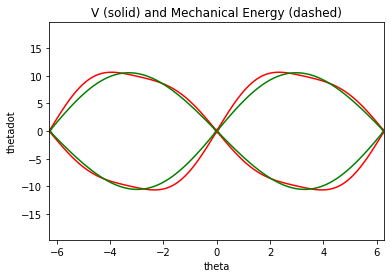

In [26]:
var_list = list(V.indeterminates())
s = var_list[0]
c = var_list[1]
theta_dot = var_list[2]

V_old = 1.4211*(2 - 2*c) + 0.0516*theta_dot**2 + 0.0428*s*theta_dot

# Plot the results as contour plots.
nq = 151
nqd = 151
q = np.linspace(-2 * np.pi, 2 * np.pi, nq)
qd = np.linspace(-4 * p.mass()*p.gravity()*p.length(), 4 * p.mass()*p.gravity()*p.length(), nqd)
Q, QD = np.meshgrid(q, qd)
Energy = .5 * p.mass() * p.length()**2 * QD**2 + p.mass()*p.gravity()*p.length() * (1 - np.cos(Q))
Vplot = Q.copy()
Vplot_old = Q.copy()
env = {s: 0., c: 1., theta_dot: 0}
for i in range(nq):
    for j in range(nqd):
        env[s] = np.sin(Q[i, j] - np.pi)
        env[c] = np.cos(Q[i, j] - np.pi)
        env[theta_dot] = QD[i, j]
        Vplot[i, j] = V.Evaluate(env)
        Vplot_old[i, j] = V_old.Evaluate(env)

# plt.rc("text", usetex=True)
fig, ax = plt.subplots()
#cf = ax.contour(Q, QD, Vplot)
#fig.colorbar(cf, ax=ax)
ax.contour(Q, QD, Vplot, levels = [1], colors = 'r')
ax.contour(Q, QD, Vplot_old, levels = [5.68], colors = 'g')
#ax.contour(Q, QD, Energy, alpha=0.5, linestyles="dashed")
ax.set_xlabel("theta")
ax.set_ylabel("thetadot")
ax.set_title("V (solid) and Mechanical Energy (dashed)")

In [228]:
list(u.indeterminates())

[Variable('s(0)', Continuous),
 Variable('c(0)', Continuous),
 Variable('theta_dot(0)', Continuous)]

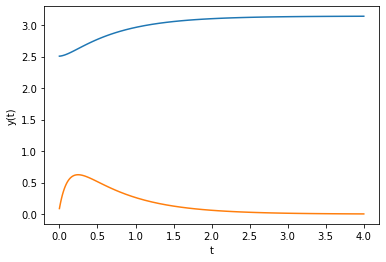

In [27]:
#before moving further, confirm that implicitly found dynamics work in simulation
def UprightState():
    return np.array([np.pi, 0])

t = Variable("t")
td = Variable("td")

var_list = list(u.indeterminates())
s = var_list[0]
c = var_list[1]
theta_dot = var_list[2]

subs = {}
subs[s] = pydrake.forwarddiff.sin(t - np.pi) 
subs[c] = pydrake.forwarddiff.cos(t - np.pi)
subs[theta_dot] = td

u_new = u.ToExpression().Substitute(subs)

x = np.hstack([t, td])
u_old = -K@(x  - UprightState())
u_old = u_old[0]

dv_0 = td
dv_1 = (-b*td - mass*gravity*length*pydrake.forwarddiff.sin(t) + u_new)/(mass*length**2)

x_dot = np.array([dv_0, dv_1])

continuous_vector_system = SymbolicVectorSystem(state=x, dynamics=x_dot, output=x)

def acrobot_balancing_example():

    builder = DiagramBuilder()
    pendulum = builder.AddSystem(continuous_vector_system)

    wrapangles = WrapToSystem(2)
    wrapangles.set_interval(0, 0, 2. * np.pi)
    wrapto = builder.AddSystem(wrapangles)
    builder.Connect(pendulum.get_output_port(0), wrapto.get_input_port(0))
    
    logger = LogVectorOutput(wrapto.get_output_port(0), builder)
    
    diagram = builder.Build()
    
    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # Simulate
    simulator.set_target_realtime_rate(0.0)
    duration = 4.0 if running_as_notebook else 0.1
    for i in range(1):
        context.SetTime(0.)
        np.random.seed(10000)
        context.SetContinuousState(UprightState() +
                                0.5 * np.random.randn(2,))
        simulator.Initialize()
        simulator.AdvanceTo(duration)
        
        log = logger.FindLog(context)
        plt.figure()
        plt.plot(log.sample_times(), log.data().transpose())
        plt.xlabel('t')
        plt.ylabel('y(t)');
    

acrobot_balancing_example()

In [28]:
K_casted

array([10.74101105,  0.        ,  2.42596626])

In [33]:
#polynomial controller search with torque limits

negative_infinity = float('-inf')
coeff = 1e-4
positive_infinity = float('inf')

def line_search_rho(x, xd, g, V, Vdot, x_0, u, u_min, u_max):     
    global coeff
    
    rho = 0
    rho_step = 0.1
    
    Vdot_degree = Vdot.TotalDegree()
    V_degree = V.TotalDegree()
    u_deg = u.TotalDegree()
    
    l_deg = math.ceil(V_degree/2) * 2
    
    s_deg = max(l_deg + V_degree - 2, 0)
    
    ul_deg = math.ceil(max(l_deg + V_degree - u_deg, 0)/2)*2
    ul_deg = 2
    lambda_arr = []
    
    while True: 
        prog = MathematicalProgram()
        prog.AddIndeterminates(x)
        prog.AddIndeterminates(xd)
    
        y = np.hstack([x, xd])
        
        lambda_ = prog.NewSosPolynomial(Variables(y), l_deg)[0]
        
        lambda_g = []
        for i in range(g.size): 
            gi_deg = max(l_deg + Vdot.TotalDegree() - g[i].TotalDegree(), 0)
            lambda_g.append(prog.NewFreePolynomial(Variables(y), gi_deg))
        lambda_g = np.array(lambda_g)
        
        lambda_s = prog.NewFreePolynomial(Variables(y), s_deg)
        trig = Polynomial(x[0]**2 + x[1]**2 - 1)
        
        lambda_u_min = prog.NewSosPolynomial(Variables(y), ul_deg)[0]
        lambda_u_max = prog.NewSosPolynomial(Variables(y), ul_deg)[0]
        
        eps = 1e-3
        
        prog.AddSosConstraint(-Vdot + lambda_*(V - rho) + lambda_g.dot(g) \
                              + lambda_s*trig \
                              + lambda_u_min*(u_min - u) \
                              + lambda_u_max*(u - u_max) \
                              - Polynomial(eps*(x-x_0).dot(x-x_0)))
        
#         lambda_chill = prog.NewFreePolynomial(Variables(x), 2)
#         prog.AddSosConstraint(V + lambda_chill*trig)
        
        solver = MosekSolver()
        result = solver.Solve(prog)
        
        curr_lambdas = []
        if result.is_success():
            rho += rho_step
            
            lambda_g_results = []
            for i in range(g.size):
                lambda_g_results.append(result.GetSolution(lambda_g[i]).RemoveTermsWithSmallCoefficients(coeff))
            
            curr_lambdas.append(result.GetSolution(lambda_).RemoveTermsWithSmallCoefficients(coeff))
            curr_lambdas.append(lambda_g_results)
            curr_lambdas.append(result.GetSolution(lambda_s).RemoveTermsWithSmallCoefficients(coeff))
            curr_lambdas.append(result.GetSolution(lambda_u_min).RemoveTermsWithSmallCoefficients(coeff))
            curr_lambdas.append(result.GetSolution(lambda_u_max).RemoveTermsWithSmallCoefficients(coeff))
            
            lambda_arr.append(curr_lambdas)

        else:
            break
    
    if len(lambda_arr) == 0:
        k = result.get_solver_details().solution_status
        raise Exception("Search for rho in unsaturated region ended with: " + str(k))
        
    return rho - rho_step, lambda_arr[-1]


def find_rho_min_max(x, xd, g_input, V, Vdot, x_0, u_ideal, u, doing_min):
    global coeff
    
    g = []
    g.append(g_input[0])
    g.append(g_input[1])
    g.append(g_input[2])
    
    g = np.array(g)
    
    g2 = Polynomial(p.mass()*(p.length()**2)*xd[2] + p.damping()*x[2] \
                        - p.mass()*p.gravity()*p.length()*x[0]) - u_ideal
    g[2] = g2
        
    rho = 0
    rho_step = 0.1
    
    Vdot_degree = Vdot.TotalDegree()
    V_degree = V.TotalDegree()
    u_deg = u.TotalDegree()
    
    l_deg = math.ceil(V_degree/2) * 2
    
    s_deg = max(l_deg + V_degree - 2, 0)
    
    ul_deg = math.ceil(max(l_deg + V_degree - u_deg, 0)/2)*2
    ul_deg = 2
    
    lambda_arr = [] 
    
    rho_cut_off = 11
    while True: 
        prog = MathematicalProgram()
        prog.AddIndeterminates(x)
        prog.AddIndeterminates(xd)
    
        y = np.hstack([x, xd])
        
        lambda_ = prog.NewSosPolynomial(Variables(y), l_deg)[0]
        
        lambda_g = []
        for i in range(g.size): 
            gi_deg = max(l_deg + Vdot.TotalDegree() - g[i].TotalDegree(), 0)
            lambda_g.append(prog.NewFreePolynomial(Variables(y), gi_deg))
        lambda_g = np.array(lambda_g)
        
        lambda_s = prog.NewFreePolynomial(Variables(y), s_deg)
        trig = Polynomial(x[0]**2 + x[1]**2 - 1)
        
        lambda_u_id = prog.NewSosPolynomial(Variables(y), ul_deg)[0]
        
        eps = 1e-3
        
        if doing_min:
            prog.AddSosConstraint(-Vdot + lambda_*(V - rho) + lambda_g.dot(g) \
                                  + lambda_s*trig \
                                  + lambda_u_id*(u - u_ideal) \
                                  - Polynomial(eps*(x-x_0).dot(x-x_0)))
        else:
            prog.AddSosConstraint(-Vdot + lambda_*(V - rho) + lambda_g.dot(g) \
                                  + lambda_s*trig \
                                  + lambda_u_id*(u_ideal - u) \
                                  - Polynomial(eps*(x-x_0).dot(x-x_0)))
        
#         lambda_chill = prog.NewFreePolynomial(Variables(x), 2)
#         prog.AddSosConstraint(V + lambda_chill*trig)
        
        solver = MosekSolver()
        result = solver.Solve(prog)
        
        curr_lambdas = []
        if result.is_success():
            #print(rho)
            rho += rho_step
            
            lambda_g_results = []
            for i in range(g.size):
                lambda_g_results.append(result.GetSolution(lambda_g[i]).RemoveTermsWithSmallCoefficients(coeff))
            
            curr_lambdas.append(result.GetSolution(lambda_).RemoveTermsWithSmallCoefficients(coeff))
            curr_lambdas.append(lambda_g_results)
            curr_lambdas.append(result.GetSolution(lambda_s).RemoveTermsWithSmallCoefficients(coeff))
            curr_lambdas.append(result.GetSolution(lambda_u_id).RemoveTermsWithSmallCoefficients(coeff))
            
            lambda_arr.append(curr_lambdas)
            
            if rho > rho_cut_off:
                print("Ending because this is global now")
                break
        else:
            break
    
    if len(lambda_arr) == 0:
        k = result.get_solver_details().solution_status
        raise Exception("Search for rho in saturated region ended with: " + str(k))
        
    return rho - rho_step, lambda_arr[-1]

def fixed_rho_min_max(x, xd, g_input, V, Vdot, x_0, u_ideal, u, doing_min, rho):
    global coeff
    
    g = []
    g.append(g_input[0])
    g.append(g_input[1])
    g.append(g_input[2])
    
    g = np.array(g)
    
    g2 = Polynomial(p.mass()*(p.length()**2)*xd[2] + p.damping()*x[2] \
                        - p.mass()*p.gravity()*p.length()*x[0]) - u_ideal
    g[2] = g2
    
    Vdot_degree = Vdot.TotalDegree()
    V_degree = V.TotalDegree()
    u_deg = u.TotalDegree()
    
    l_deg = math.ceil(V_degree/2) * 2
    
    s_deg = max(l_deg + V_degree - 2, 0)
    
    ul_deg = math.ceil(max(l_deg + V_degree - u_deg, 0)/2)*2
    ul_deg = 2
        
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    prog.AddIndeterminates(xd)

    y = np.hstack([x, xd])

    lambda_ = prog.NewSosPolynomial(Variables(y), l_deg)[0]

    lambda_g = []
    for i in range(g.size): 
        gi_deg = max(l_deg + Vdot.TotalDegree() - g[i].TotalDegree(), 0)
        lambda_g.append(prog.NewFreePolynomial(Variables(y), gi_deg))
    lambda_g = np.array(lambda_g)

    lambda_s = prog.NewFreePolynomial(Variables(y), s_deg)
    trig = Polynomial(x[0]**2 + x[1]**2 - 1)

    lambda_u_id = prog.NewSosPolynomial(Variables(y), ul_deg)[0]

    eps = 1e-3

    if doing_min:
        prog.AddSosConstraint(-Vdot + lambda_*(V - rho) + lambda_g.dot(g) \
                              + lambda_s*trig \
                              + lambda_u_id*(u - u_ideal) \
                              - Polynomial(eps*(x-x_0).dot(x-x_0)))
    else:
        prog.AddSosConstraint(-Vdot + lambda_*(V - rho) + lambda_g.dot(g) \
                              + lambda_s*trig \
                              + lambda_u_id*(u_ideal - u) \
                              - Polynomial(eps*(x-x_0).dot(x-x_0)))

#     lambda_chill = prog.NewFreePolynomial(Variables(x), 2)
#     prog.AddSosConstraint(V + lambda_chill*trig)

    solver = MosekSolver()
    result = solver.Solve(prog)

    curr_lambdas = []
    if result.is_success():
        #print(rho)
        lambda_g_results = []
        for i in range(g.size):
            lambda_g_results.append(result.GetSolution(lambda_g[i]).RemoveTermsWithSmallCoefficients(coeff))

        curr_lambdas.append(result.GetSolution(lambda_).RemoveTermsWithSmallCoefficients(coeff))
        curr_lambdas.append(lambda_g_results)
        curr_lambdas.append(result.GetSolution(lambda_s).RemoveTermsWithSmallCoefficients(coeff))
        curr_lambdas.append(result.GetSolution(lambda_u_id).RemoveTermsWithSmallCoefficients(coeff))

    else:
        k = result.get_solver_details().solution_status
        raise Exception("Search for rho in saturated region ended with: " + str(k))
        
    return curr_lambdas

def fixed_rho(x, xd, g, V, Vdot, x_0, u, u_min, u_max, rho):     
    global coeff
    
    Vdot_degree = Vdot.TotalDegree()
    V_degree = V.TotalDegree()
    u_deg = u.TotalDegree()
    
    l_deg = math.ceil(V_degree/2) * 2
    s_deg = max(l_deg + V_degree - 2, 0)
    
    ul_deg = math.ceil(max(l_deg + V_degree - u_deg, 0)/2)*2
    ul_deg = 2

    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    prog.AddIndeterminates(xd)

    y = np.hstack([x, xd])

    lambda_ = prog.NewSosPolynomial(Variables(y), l_deg)[0]

    lambda_g = []
    for i in range(g.size): 
        gi_deg = max(l_deg + Vdot.TotalDegree() - g[i].TotalDegree(), 0)
        lambda_g.append(prog.NewFreePolynomial(Variables(y), gi_deg))
    lambda_g = np.array(lambda_g)

    lambda_s = prog.NewFreePolynomial(Variables(y), s_deg)
    trig = Polynomial(x[0]**2 + x[1]**2 - 1)

    lambda_u_min = prog.NewSosPolynomial(Variables(y), ul_deg)[0]
    lambda_u_max = prog.NewSosPolynomial(Variables(y), ul_deg)[0]

    eps = 1e-3

    prog.AddSosConstraint(-Vdot + lambda_*(V - rho) + lambda_g.dot(g) \
                          + lambda_s*trig \
                          + lambda_u_min*(u_min - u) \
                          + lambda_u_max*(u - u_max) \
                          - Polynomial(eps*(x-x_0).dot(x-x_0)))

#     lambda_chill = prog.NewFreePolynomial(Variables(x), 2)
#     prog.AddSosConstraint(V + lambda_chill*trig)

    solver = MosekSolver()
    result = solver.Solve(prog)

    curr_lambdas = []
    if result.is_success():

        lambda_g_results = []
        for i in range(g.size):
            lambda_g_results.append(result.GetSolution(lambda_g[i]).RemoveTermsWithSmallCoefficients(coeff))

        curr_lambdas.append(result.GetSolution(lambda_).RemoveTermsWithSmallCoefficients(coeff))
        curr_lambdas.append(lambda_g_results)
        curr_lambdas.append(result.GetSolution(lambda_s).RemoveTermsWithSmallCoefficients(coeff))
        curr_lambdas.append(result.GetSolution(lambda_u_min).RemoveTermsWithSmallCoefficients(coeff))
        curr_lambdas.append(result.GetSolution(lambda_u_max).RemoveTermsWithSmallCoefficients(coeff))

    else:
        k = result.get_solver_details().solution_status
        print("Unsaturated fixed rho search ended with: " + str(k))
        
        raise Exception("Solution Never Converged")
 
        
    return curr_lambdas

def find_implicit_controller(x, xd, lambda_rhos, lambda_rho_mins, lambda_rho_maxs, g, V_degree, x_0, \
                            u_min, u_max, rho):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    prog.AddIndeterminates(xd)
    
    y = np.hstack([x, xd])
            
    V = prog.NewFreePolynomial(Variables(x), V_degree)
    Vdot = V.Jacobian(x).dot(xd)
    
    u = prog.NewFreePolynomial(Variables(x), 3)
        
    g2 = Polynomial(p.mass()*(p.length()**2)*xd[2] + p.damping()*x[2] \
                    - p.mass()*p.gravity()*p.length()*x[0]) - u
    g[2] = g2
    
    trig = Polynomial(x[0]**2 + x[1]**2 - 1)
    
    eps = 1e-3
        
    prog.AddSosConstraint(-Vdot + lambda_rhos[0]*(V - rho) + np.array(lambda_rhos[1]).dot(g) \
                          + lambda_rhos[2]*trig \
                          + lambda_rhos[3]*(u_min - u) \
                          + lambda_rhos[4]*(u - u_max) \
                          - Polynomial(eps*(x-x_0).dot(x-x_0)))
    
    g2 = Polynomial(p.mass()*(p.length()**2)*xd[2] + p.damping()*x[2] \
                    - p.mass()*p.gravity()*p.length()*x[0]) - u_min
    g[2] = g2
    
    prog.AddSosConstraint(-Vdot + lambda_rho_mins[0]*(V - rho) + np.array(lambda_rho_mins[1]).dot(g) \
                          + lambda_rho_mins[2]*trig \
                          + lambda_rho_mins[3]*(u - u_min) \
                          - Polynomial(eps*(x-x_0).dot(x-x_0)))
    
    g2 = Polynomial(p.mass()*(p.length()**2)*xd[2] + p.damping()*x[2] \
                    - p.mass()*p.gravity()*p.length()*x[0]) - u_max
    g[2] = g2
    
    
    prog.AddSosConstraint(-Vdot + lambda_rho_maxs[0]*(V - rho) + np.array(lambda_rho_maxs[1]).dot(g) \
                          + lambda_rho_maxs[2]*trig \
                          + lambda_rho_maxs[3]*(u_max - u) \
                          - Polynomial(eps*(x-x_0).dot(x-x_0)))
        
    lambda_s2 = prog.NewFreePolynomial(Variables(x), 2)
    prog.AddSosConstraint(V + lambda_s2*trig)
    
    V_decision_variables_dict = V.monomial_to_coefficient_map()
    
    const_term = Monomial()
    cos_term = Monomial(x[1])
    td_sq = Monomial(x[2], 2)
    sin_sq_term = Monomial(x[0], 2)
    cos_sq_term = Monomial(x[1], 2)
    
    prog.AddLinearCost(V_decision_variables_dict[const_term])
    prog.AddLinearCost(-V_decision_variables_dict[cos_term])
    prog.AddLinearCost(V_decision_variables_dict[td_sq])
    prog.AddLinearCost(V_decision_variables_dict[sin_sq_term])
    prog.AddLinearCost(-V_decision_variables_dict[cos_sq_term])
    
    #prog.AddLinearCost(np.trace(Q))    
    prog.AddLinearConstraint(V.ToExpression().Substitute({x[0]: 0, x[1]:1, x[2]:0}) == 0)
    
#     prog.AddLinearConstraint(V.ToExpression().Substitute({x[0]: 0, x[1]:1, x[2]:0, \
#                                                           xd[0]: 0, xd[1]: 0, xd[2]:0}) == 0)
    
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
                    
    print("V solution status: " + str(k))
    
    #assert result.is_success()
    return result.GetSolution(V).RemoveTermsWithSmallCoefficients(coeff), \
result.GetSolution(u).RemoveTermsWithSmallCoefficients(coeff)

def certifier_implicit(G, u_min, u_max):
    prog = MathematicalProgram()
    s = prog.NewIndeterminates(1, "s")
    c = prog.NewIndeterminates(1, "c")
    theta_dot = prog.NewIndeterminates(1, "theta_dot")
    x = np.hstack([s, c, theta_dot])
    
    x_0 = np.array([0, 1, 0])
    
    xd = prog.NewIndeterminates(3, 'xd')
      
    u = -G@(x - x_0)
            
    g0 = xd[0] - c[0]*theta_dot[0]
    g1 = xd[1] + s[0]*theta_dot[0]
    g2 = p.mass()*(p.length()**2)*xd[2] + p.damping()*theta_dot[0] - p.mass()*p.gravity()*p.length()*s[0] - u
    
    g = np.array([g0, g1, g2])
    
    V = 1.4211*(2 - 2*x[1]) + 0.0516*x[2]**2 + 0.0428*x[0]*x[2]
    
    Vdot = V.Jacobian(x).dot(xd)
    
    V = Polynomial(V)
    Vdot = Polynomial(Vdot)
    display(Markdown("$ V(x)="+ToLatex(V.ToExpression(), 9)+"$"))
    
    g_poly = []
    for i in range(g.size):
        g_poly.append(Polynomial(g[i]))
        
    g_poly = np.array(g_poly)
        
    u = Polynomial(u)
    
    for i in range(25): 
        print("Welcome to STEP: " + str(i))
        
        rho, lambda_rhos = line_search_rho(x, xd, g_poly, V, Vdot, x_0, u, u_min, u_max)
        print('regular: ' + str(rho))
        
        rho_max, lambda_rho_maxs = find_rho_min_max(x, xd, g_poly, V, Vdot, x_0, u_max, u, False)
        rho_min, lambda_rho_mins = find_rho_min_max(x, xd, g_poly, V, Vdot, x_0, u_min, u, True)
        print('max: ' + str(rho_max))
        print('min: ' + str(rho_min))
        
        picked_rho = min(rho, min(rho_max, rho_min))
        
        lambda_rhos = fixed_rho(x, xd, g_poly, V, Vdot, x_0, u, u_min, u_max, picked_rho)
        lambda_rhos_maxs = fixed_rho_min_max(x, xd, g_poly, V, Vdot, x_0, u_max, u, False, picked_rho)
        lambda_rhos_mins = fixed_rho_min_max(x, xd, g_poly, V, Vdot, x_0, u_min, u, True, picked_rho)
        

            

        V, u = find_implicit_controller(x, xd, lambda_rhos, lambda_rho_mins, lambda_rho_maxs, g_poly, \
                                             V_degree, x_0, u_min, u_max, picked_rho)

        g2 = Polynomial(p.mass()*(p.length()**2)*xd[2] + p.damping()*x[2] \
                        - p.mass()*p.gravity()*p.length()*x[0]) - u
        g_poly[2] = g2

        display(Markdown("$ V(x)="+ToLatex(V.ToExpression(), 9)+"$"))
        display(Markdown("$ u(x)="+ToLatex(u.ToExpression(), 9)+"$"))

        Vdot = V.Jacobian(x).dot(xd)
    
    return V, u, rho_max, rho

u_min = -6
u_max = 6
V, u, rho_max, rho = certifier_implicit(K_casted, u_min, u_max)

$ V(x)=(2.842200000 - 2.842200000c_{0} + 0.042800000s_{0} theta_dot_{0} + 0.051600000theta_dot_{0}^{2})$

Welcome to STEP: 0
regular: 5.599999999999996
max: 0.5
min: 0.5
V solution status: 1


$ V(x)=(2.718489297 - 2.594856500c_{0} + 0.047484576s_{0} theta_dot_{0} - 0.189630639s_{0}^{2} - 0.123632862c_{0}^{2} + 0.044048950theta_dot_{0}^{2})$

$ u(x)=( - 10.573594978s_{0} - 2.627628958theta_dot_{0})$

Welcome to STEP: 1
regular: 5.099999999999998
max: 0.5
min: 0.5
V solution status: 1


$ V(x)=(2.531888441 - 2.221647618c_{0} + 0.050054700s_{0} theta_dot_{0} - 0.331666240s_{0}^{2} - 0.310240860c_{0}^{2} + 0.040021260theta_dot_{0}^{2})$

$ u(x)=( - 10.342138318s_{0} - 3.068392186theta_dot_{0} - 0.126466782s_{0} c_{0} + 0.783670961c_{0} theta_dot_{0})$

Welcome to STEP: 2
regular: 4.4
max: 0.5
min: 0.5
V solution status: 1


$ V(x)=(2.379238605 - 1.916353653c_{0} + 0.053421690s_{0} theta_dot_{0} - 0.464780784s_{0}^{2} - 0.462884975c_{0}^{2} + 0.037065919theta_dot_{0}^{2})$

$ u(x)=( - 9.982679343s_{0} - 2.900181463theta_dot_{0} - 0.086918205s_{0} c_{0} + 0.868293510c_{0} theta_dot_{0})$

Welcome to STEP: 3
regular: 3.800000000000002
max: 0.5
min: 0.5
V solution status: 1


$ V(x)=(2.249438018 - 1.656760140c_{0} + 0.056487304s_{0} theta_dot_{0} - 0.586068688s_{0}^{2} - 0.592677852c_{0}^{2} + 0.034663973theta_dot_{0}^{2})$

$ u(x)=( - 9.628181205s_{0} - 2.616123215theta_dot_{0} - 0.032496153s_{0} c_{0} - 0.000113435s_{0} theta_dot_{0} + 0.808254322c_{0} theta_dot_{0})$

Welcome to STEP: 4
regular: 3.3000000000000016
max: 0.5
min: 0.5
V solution status: 1


$ V(x)=(2.137493592 - 1.432885162c_{0} + 0.058860472s_{0} theta_dot_{0} - 0.696063412s_{0}^{2} - 0.704608449c_{0}^{2} + 0.032636869theta_dot_{0}^{2})$

$ u(x)=( - 9.284657560s_{0} - 2.298586349theta_dot_{0} + 0.030131827s_{0} c_{0} + 0.691772206c_{0} theta_dot_{0})$

Welcome to STEP: 5
regular: 2.800000000000001
max: 0.5
min: 0.5
V solution status: 1


$ V(x)=(2.043088277 - 1.244085365c_{0} + 0.060904781s_{0} theta_dot_{0} - 0.800733346s_{0}^{2} - 0.799002879c_{0}^{2} + 0.030923547theta_dot_{0}^{2})$

$ u(x)=( - 8.952803689s_{0} - 1.978010195theta_dot_{0} + 0.101422258s_{0} c_{0} + 0.553095318c_{0} theta_dot_{0})$

Welcome to STEP: 6
regular: 2.400000000000001
max: 0.5
min: 0.5
V solution status: 1


$ V(x)=(1.962261325 - 1.082456202c_{0} + 0.061810345s_{0} theta_dot_{0} - 0.893355389s_{0}^{2} - 0.879805121c_{0}^{2} + 0.029654772theta_dot_{0}^{2})$

$ u(x)=( - 8.644191059s_{0} - 1.687624489theta_dot_{0} + 0.169850147s_{0} c_{0} + 0.406400124c_{0} theta_dot_{0})$

Welcome to STEP: 7
regular: 2.1000000000000005
max: 0.5
min: 0.5
V solution status: 1


$ V(x)=(1.892394573 - 0.942743246c_{0} + 0.062136075s_{0} theta_dot_{0} - 0.971615656s_{0}^{2} - 0.949651258c_{0}^{2} + 0.028709617theta_dot_{0}^{2})$

$ u(x)=( - 8.367263825s_{0} - 1.428396990theta_dot_{0} + 0.228353993s_{0} c_{0} + 0.255481982c_{0} theta_dot_{0})$

Welcome to STEP: 8
regular: 1.8000000000000005
max: 0.5
min: 0.5
V solution status: 1


$ V(x)=(1.833569026 - 0.825107529c_{0} + 0.062586489s_{0} theta_dot_{0} - 1.041638931s_{0}^{2} - 1.008461468c_{0}^{2} + 0.028136416theta_dot_{0}^{2})$

$ u(x)=( - 8.101714000s_{0} - 1.209317281theta_dot_{0} + 0.277792931s_{0} c_{0} + 0.130337113c_{0} theta_dot_{0})$

Welcome to STEP: 9
regular: 1.6000000000000003
max: 0.5
min: 0.5
V solution status: 1


$ V(x)=(1.782586464 - 0.723132403c_{0} + 0.062760596s_{0} theta_dot_{0} - 1.101576257s_{0}^{2} - 1.059453949c_{0}^{2} + 0.027843538theta_dot_{0}^{2})$

$ u(x)=( - 7.834293976s_{0} - 1.023115768theta_dot_{0} + 0.313003260s_{0} c_{0} + 0.022787806c_{0} theta_dot_{0})$

Welcome to STEP: 10
regular: 1.4000000000000001
max: 0.5
min: 0.5
V solution status: 1


$ V(x)=(1.738263763 - 0.634500850c_{0} + 0.062813687s_{0} theta_dot_{0} - 1.153680994s_{0}^{2} - 1.103762924c_{0}^{2} + 0.027757983theta_dot_{0}^{2})$

$ u(x)=( - 7.559507885s_{0} - 0.881037779theta_dot_{0} + 0.319107226s_{0} c_{0} - 0.047711738c_{0} theta_dot_{0})$

Welcome to STEP: 11
regular: 1.2
max: 0.5
min: 0.5
V solution status: 1


$ V(x)=(1.699418980 - 0.556799895c_{0} + 0.062572605s_{0} theta_dot_{0} - 1.199349387s_{0}^{2} - 1.142619119c_{0}^{2} + 0.027666775theta_dot_{0}^{2})$

$ u(x)=( - 7.296879737s_{0} - 0.778105273theta_dot_{0} + 0.306225809s_{0} c_{0} - 0.083753564c_{0} theta_dot_{0})$

Welcome to STEP: 12
regular: 1.0999999999999999
max: 0.5
min: 0.5
V solution status: 1


$ V(x)=(1.665791666 - 0.489522399c_{0} + 0.061606477s_{0} theta_dot_{0} - 1.238989271s_{0}^{2} - 1.176269318c_{0}^{2} + 0.027251351theta_dot_{0}^{2})$

$ u(x)=( - 7.057592400s_{0} - 0.706004289theta_dot_{0} + 0.275594644s_{0} c_{0} - 0.092949720c_{0} theta_dot_{0})$

Welcome to STEP: 13
regular: 0.8999999999999999
max: 0.5
min: 0.5
V solution status: 1


$ V(x)=(1.636920943 - 0.431771454c_{0} + 0.059244021s_{0} theta_dot_{0} - 1.272260709s_{0}^{2} - 1.205149405c_{0}^{2} + 0.026452700theta_dot_{0}^{2})$

$ u(x)=( - 6.897247160s_{0} - 0.713600534theta_dot_{0} + 0.245896238s_{0} c_{0} - 0.056087998c_{0} theta_dot_{0})$

Welcome to STEP: 14
regular: 0.7999999999999999
max: 0.5
min: 0.5
V solution status: 1


$ V(x)=(1.614324711 - 0.386585340c_{0} + 0.055395739s_{0} theta_dot_{0} - 1.298921458s_{0}^{2} - 1.227739429c_{0}^{2} + 0.025451209theta_dot_{0}^{2})$

$ u(x)=( - 6.732009797s_{0} - 0.657755257theta_dot_{0} + 0.231273715s_{0} c_{0} - 0.061978146c_{0} theta_dot_{0})$

Welcome to STEP: 15
regular: 0.7
max: 0.6
min: 0.6
V solution status: 1


$ V(x)=(1.603596385 - 0.365137514c_{0} + 0.050895426s_{0} theta_dot_{0} - 1.319710849s_{0}^{2} - 1.238458935c_{0}^{2} + 0.024975821theta_dot_{0}^{2})$

$ u(x)=( - 6.624499353s_{0} - 0.555858477theta_dot_{0} + 0.266071846s_{0} c_{0} - 0.104899773c_{0} theta_dot_{0})$

Welcome to STEP: 16
regular: 0.7
Ending because this is global now
Ending because this is global now
max: 10.999999999999977
min: 10.999999999999977
V solution status: 1


$ V(x)=(1.601956699 - 0.361886490c_{0} + 0.047739595s_{0} theta_dot_{0} - 1.335075904s_{0}^{2} - 1.240069983c_{0}^{2} + 0.025365784theta_dot_{0}^{2})$

$ u(x)=( - 6.610301915s_{0} - 0.641927889theta_dot_{0} + 0.294788641s_{0} c_{0} - 0.016360846c_{0} theta_dot_{0})$

Welcome to STEP: 17
regular: 0.7
Ending because this is global now
Ending because this is global now
max: 10.999999999999977
min: 10.999999999999977
V solution status: 1


$ V(x)=(1.600822213 - 0.359670019c_{0} + 0.045431202s_{0} theta_dot_{0} - 1.346391773s_{0}^{2} - 1.241152017c_{0}^{2} + 0.025463740theta_dot_{0}^{2})$

$ u(x)=( - 6.543312168s_{0} - 0.656482754theta_dot_{0} + 0.300863212s_{0} c_{0} + 0.016457626c_{0} theta_dot_{0})$

Welcome to STEP: 18
regular: 0.7
Ending because this is global now
Ending because this is global now
max: 10.999999999999977
min: 10.999999999999977
V solution status: 0


$ V(x)=(1.601294683 - 0.360662389c_{0} + 0.049892435s_{0} theta_dot_{0} - 1.349023276s_{0}^{2} - 1.240631614c_{0}^{2} + 0.028450913theta_dot_{0}^{2})$

$ u(x)=( - 6.500615956s_{0} - 0.743488535theta_dot_{0} + 0.205832984s_{0} c_{0} - 0.000161880s_{0} theta_dot_{0} + 0.008004097c_{0} theta_dot_{0})$

Welcome to STEP: 19
regular: 0.7
Ending because this is global now
Ending because this is global now
max: 10.999999999999977
min: 10.999999999999977
V solution status: 0


$ V(x)=(1.600474540 - 0.359098108c_{0} + 0.047462271s_{0} theta_dot_{0} - 1.358093093s_{0}^{2} - 1.241376414c_{0}^{2} + 0.026917309theta_dot_{0}^{2})$

$ u(x)=(-0.000128105 - 6.507600187s_{0} - 0.717181037theta_dot_{0} + 0.295015687s_{0} c_{0} - 0.000255550s_{0} theta_dot_{0} + 0.005781800c_{0} theta_dot_{0} - 0.000119005s_{0}^{2} + 0.000109182c_{0}^{2})$

Welcome to STEP: 20
regular: 0.7
Ending because this is global now
Ending because this is global now
max: 10.999999999999977
min: 10.999999999999977
V solution status: 0


$ V(x)=(1.599795920 - 0.357824222c_{0} + 0.045959410s_{0} theta_dot_{0} - 1.364738445s_{0}^{2} - 1.241971816c_{0}^{2} + 0.026199989theta_dot_{0}^{2})$

$ u(x)=(-0.000191493 - 6.509031200s_{0} - 0.735200576theta_dot_{0} + 0.336815139s_{0} c_{0} - 0.000403543s_{0} theta_dot_{0} + 0.019383544c_{0} theta_dot_{0} + 0.000183575c_{0}^{2})$

Welcome to STEP: 21
regular: 0.7
Ending because this is global now
Ending because this is global now
max: 10.999999999999977
min: 10.999999999999977
V solution status: 1


$ V(x)=(1.585371241 - 0.355462819c_{0} + 0.044871187s_{0} theta_dot_{0} - 1.365830634s_{0}^{2} - 1.229908421c_{0}^{2} + 0.025681992theta_dot_{0}^{2})$

$ u(x)=(-0.000260711 - 6.510942130s_{0} - 0.585184410theta_dot_{0} + 0.493880919s_{0} c_{0} - 0.000469544s_{0} theta_dot_{0} - 0.067977902c_{0} theta_dot_{0} - 0.000208847s_{0}^{2} + 0.000259778c_{0}^{2})$

Welcome to STEP: 22
regular: 0.7
Ending because this is global now
Ending because this is global now
max: 10.999999999999977
min: 10.999999999999977
V solution status: 1


$ V(x)=(1.575793828 - 0.354143921c_{0} + 0.043898961s_{0} theta_dot_{0} - 1.366144366s_{0}^{2} - 1.221649906c_{0}^{2} + 0.025617148theta_dot_{0}^{2})$

$ u(x)=(-0.000244356 - 6.488325870s_{0} - 0.453141834theta_dot_{0} + 0.606110903s_{0} c_{0} - 0.001039975s_{0} theta_dot_{0} - 0.139817348c_{0} theta_dot_{0} - 0.001032835s_{0}^{2} + 0.000267400c_{0}^{2} - 0.000114225theta_dot_{0}^{2})$

Welcome to STEP: 23
regular: 0.7
Ending because this is global now
Ending because this is global now
max: 10.999999999999977
min: 10.999999999999977
V solution status: 1


$ V(x)=(1.575115906 - 0.352704803c_{0} + 0.043616889s_{0} theta_dot_{0} - 1.367196444s_{0}^{2} - 1.222411115c_{0}^{2} + 0.025454765theta_dot_{0}^{2})$

$ u(x)=(-0.000747543 - 6.414714670s_{0} - 0.460789942theta_dot_{0} + 0.589593911s_{0} c_{0} - 0.000747420s_{0} theta_dot_{0} - 0.116460815c_{0} theta_dot_{0} - 0.000266050s_{0}^{2} + 0.000748522c_{0}^{2})$

Welcome to STEP: 24
regular: 0.7
Ending because this is global now
Ending because this is global now
max: 10.999999999999977
min: 10.999999999999977
V solution status: 1


$ V(x)=(1.574911077 - 0.352272420c_{0} + 0.043479477s_{0} theta_dot_{0} - 1.368130017s_{0}^{2} - 1.222638692c_{0}^{2} + 0.025419593theta_dot_{0}^{2})$

$ u(x)=(-0.000955985 - 6.396979713s_{0} - 0.425555933theta_dot_{0} + 0.634415405s_{0} c_{0} - 0.000660565s_{0} theta_dot_{0} - 0.126646878c_{0} theta_dot_{0} + 0.000958264c_{0}^{2})$

In [30]:
u

<Polynomial "-0.8320713202597666*theta_dot(0) + -0.22619658790990313*c(0) * theta_dot(0) + -8.1938328079851086*s(0) + -0.0001097327626473723*s(0) * theta_dot(0) + 1.5391856554887848*s(0) * c(0) + -0.00011956371041997269*s(0)^2">

Text(0.5, 1.0, 'V (solid) and Mechanical Energy (dashed)')

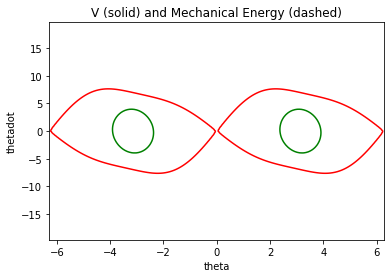

In [31]:
var_list = list(V.indeterminates())
s = var_list[0]
c = var_list[1]
theta_dot = var_list[2]

V_old = 1.4211*(2 - 2*c) + 0.0516*theta_dot**2 + 0.0428*s*theta_dot

# Plot the results as contour plots.
nq = 151
nqd = 151
q = np.linspace(-2 * np.pi, 2 * np.pi, nq)
qd = np.linspace(-4 * p.mass()*p.gravity()*p.length(), 4 * p.mass()*p.gravity()*p.length(), nqd)
Q, QD = np.meshgrid(q, qd)
Energy = .5 * p.mass() * p.length()**2 * QD**2 + p.mass()*p.gravity()*p.length() * (1 - np.cos(Q))
Vplot = Q.copy()
Vplot_old = Q.copy()
env = {s: 0., c: 1., theta_dot: 0}
for i in range(nq):
    for j in range(nqd):
        env[s] = np.sin(Q[i, j] - np.pi)
        env[c] = np.cos(np.pi - Q[i, j])
        env[theta_dot] = QD[i, j]
        Vplot[i, j] = V.Evaluate(env)
        Vplot_old[i, j] = V_old.Evaluate(env)

# plt.rc("text", usetex=True)
fig, ax = plt.subplots()
#cf = ax.contour(Q, QD, Vplot)
#fig.colorbar(cf, ax=ax)
ax.contour(Q, QD, Vplot, levels = [1.2], colors = 'r')
ax.contour(Q, QD, Vplot_old, levels = [0.8], colors = 'g')
#ax.contour(Q, QD, Energy, alpha=0.5, linestyles="dashed")
ax.set_xlabel("theta")
ax.set_ylabel("thetadot")
ax.set_title("V (solid) and Mechanical Energy (dashed)")

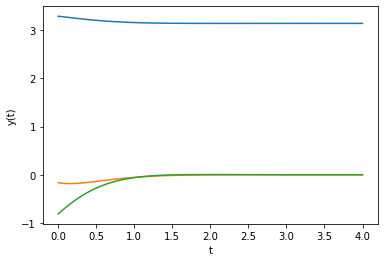

In [32]:
#before moving further, confirm that implicitly found dynamics work in simulation
def UprightState():
    return np.array([np.pi, 0])

t = Variable("t")
td = Variable("td")
garbage = Variable("garbage")
x = np.hstack([t, td])

var_list = list(u.indeterminates())
s = var_list[0]
c = var_list[1]
theta_dot = var_list[2]

subs = {}
subs[s] = pydrake.forwarddiff.sin(t - np.pi) 
subs[c] = pydrake.forwarddiff.cos(t - np.pi)
subs[theta_dot] = td

u_new = u.ToExpression().Substitute(subs)

own_controller = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=[u_new])


def acrobot_balancing_example():

    builder = DiagramBuilder()
    pendulum = builder.AddSystem(PendulumPlant())
    
    saturation = builder.AddSystem(Saturation(min_value=[-7], max_value=[7]))
    builder.Connect(saturation.get_output_port(0), pendulum.get_input_port(0))
    wrapangles = WrapToSystem(2)
    wrapangles.set_interval(0, 0, 2. * np.pi)
    wrapto = builder.AddSystem(wrapangles)
    builder.Connect(pendulum.get_output_port(0), wrapto.get_input_port(0))
    controller = builder.AddSystem(own_controller)
    builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))
    
    logger = LogVectorOutput(wrapto.get_output_port(0), builder)
    logger2 = LogVectorOutput(saturation.get_output_port(0), builder)
    
    diagram = builder.Build()
    
    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # Simulate
    simulator.set_target_realtime_rate(0.0)
    duration = 4 if running_as_notebook else 0.1
    for i in range(1):
        context.SetTime(0.)
#         np.random.seed(10000)
        context.SetContinuousState(np.append(UprightState(), 0) -
                                 0.5* np.random.randn(3,))
        simulator.Initialize()
        simulator.AdvanceTo(duration)
        
        log = logger.FindLog(context)
        plt.figure()
        plt.plot(log.sample_times(), log.data().transpose())
        
        log2 = logger2.FindLog(context)
        plt.plot(log2.sample_times(), log2.data().transpose())
        plt.xlabel('t')
        plt.ylabel('y(t)');
    

acrobot_balancing_example()

In [443]:
from pydrake.solvers.mathematicalprogram import SolverOptions

In [444]:
op = SolverOptions()

In [447]:
op.GetOptions(MosekSolver().solver_id())

{}

In [448]:
op.get_print_to_console()

False